In [1]:
import torch
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import re

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
import os

DATA_DIR = 'data_processed/filtered/New'
print(os.listdir(DATA_DIR))

['disgust']


In [3]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torchvision.transforms as T
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

In [4]:
image_size = 64
batch_size = 4
#stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
stats = (0.5,), (0.5,)

In [5]:

# train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
#     T.Resize(image_size),
#     T.CenterCrop(image_size),
#     transforms.Grayscale(num_output_channels=1),
#     T.ToTensor(),
#     T.Normalize(*stats)]))


# train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

import os
import random
from PIL import Image



# # define the path to the folder containing the original images
# data_dir = "data_processed/filtered/New/disgust"

# # define the number of augmented images to generate
# num_augmented_images = 1000

# # define the data augmentation transforms
# augmentations = T.Compose([
#     T.RandomResizedCrop(224),
#     T.RandomHorizontalFlip(),
#     T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
#     T.RandomRotation(degrees=15),
#     T.ToTensor(),
#     T.Normalize([0.5], [0.5])
# ])

# # loop over the original images in the folder and perform data augmentation on a random subset
# for filename in os.listdir(data_dir):
#     if filename.endswith(".jpg") or filename.endswith(".png"):
#         img_path = os.path.join(data_dir, filename)
#         img = Image.open(img_path)
#         if random.random() < 0.5:
#             # apply data augmentation to the image
#             augmented_img = augmentations(img)
#             # convert tensor to PIL image
#             augmented_img_pil = T.ToPILImage()(augmented_img)
#             # save the augmented image to the same folder
#             new_filename = "augmented_" + filename
#             augmented_img_pil.save(os.path.join(data_dir, new_filename))
#             num_augmented_images -= 1
#             if num_augmented_images == 0:
#                 break



train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    transforms.Grayscale(num_output_channels=1),
    T.ToTensor(),
    T.Normalize(*stats)]))


train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

# # create the data loader for the augmented training dataset
# train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=3, pin_memory=True)



In [6]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [8]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

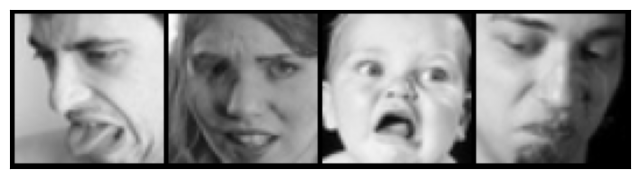

In [9]:
show_batch(train_dl)

In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
device = get_default_device()
device

device(type='cuda')

In [12]:
train_dl = DeviceDataLoader(train_dl, device)

Discriminator Network

In [13]:
import torch.nn as nn

discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [14]:
discriminator = to_device(discriminator, device)

In [15]:
latent_size = 134

In [16]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([4, 1, 64, 64])


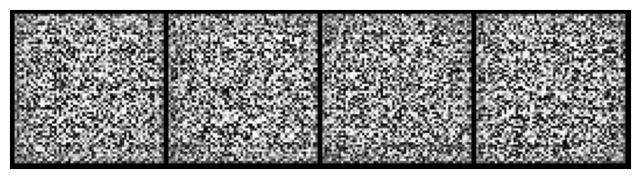

In [17]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [18]:
generator = to_device(generator, device)

In [19]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [20]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [21]:
from torchvision.utils import save_image

In [22]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [23]:
# def save_samples(index, latent_tensors, show=True):
#     fake_images = generator(latent_tensors)
#     fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
#     save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
#     print('Saving', fake_fname)
#     if show:
#         fig, ax = plt.subplots(figsize=(8, 8))
#         ax.set_xticks([]); ax.set_yticks([])
#         ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))






def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    
    for i in range(fake_images.shape[0]):
        fake_fname = 'generated-image-{0:0=4d}-{1:0=2d}.png'.format(index, i)
        save_image(denorm(fake_images[i]), os.path.join(sample_dir, fake_fname))
        print('Saving', fake_fname)
        if show:
            fig, ax = plt.subplots(figsize=(8, 8))
            ax.set_xticks([]); ax.set_yticks([])
            ax.imshow(fake_images[i].cpu().detach().permute(1, 2, 0))
            plt.show()


In [24]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-image-0000-00.png


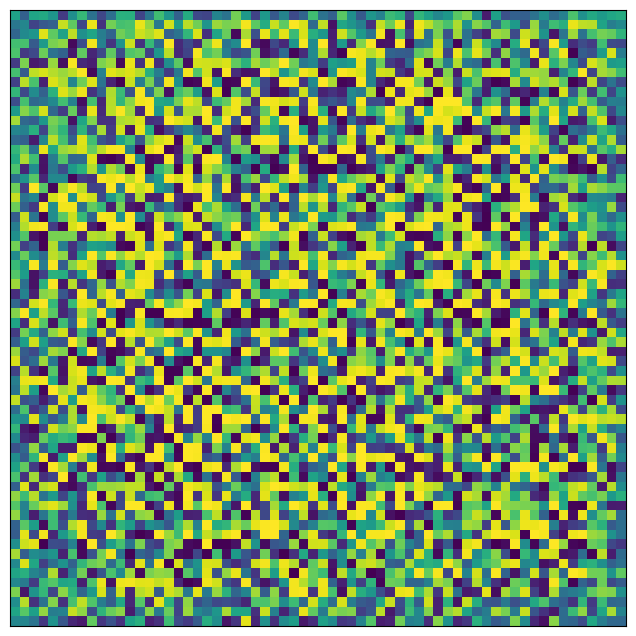

Saving generated-image-0000-01.png


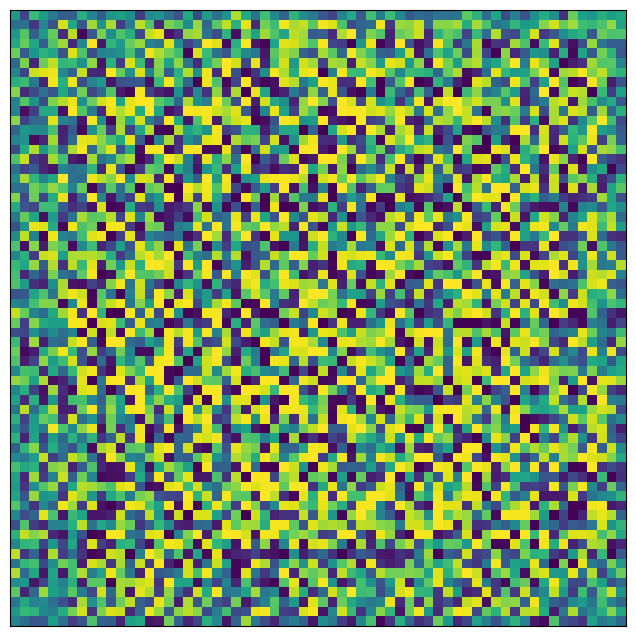

Saving generated-image-0000-02.png


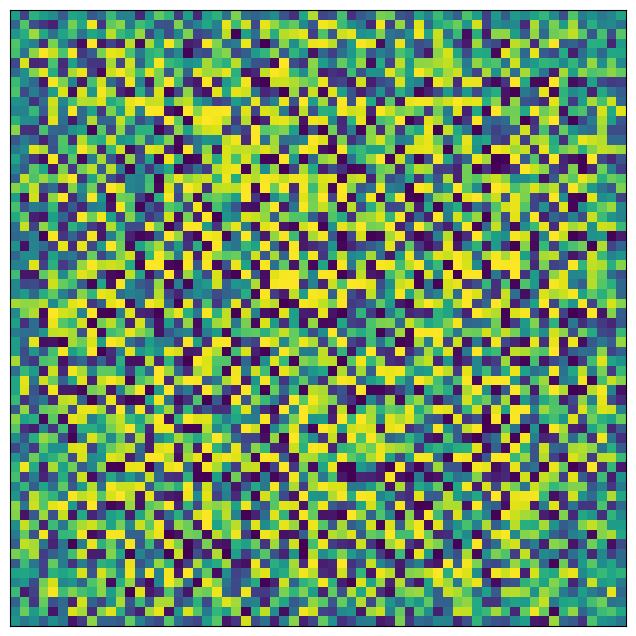

Saving generated-image-0000-03.png


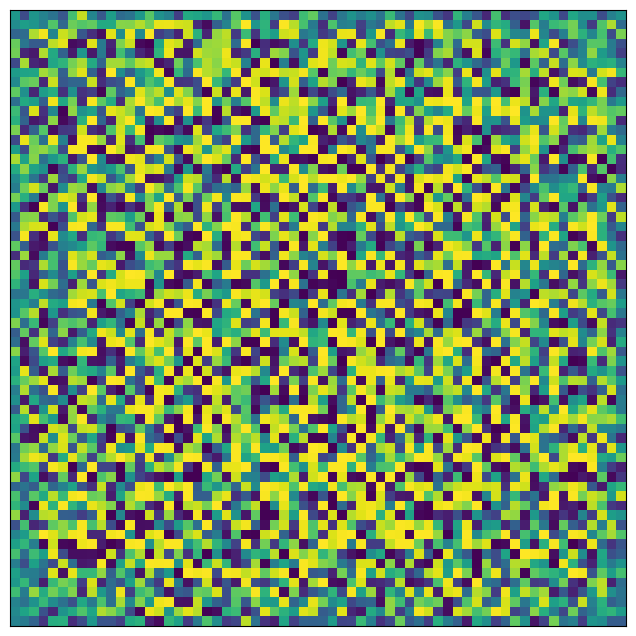

Saving generated-image-0000-04.png


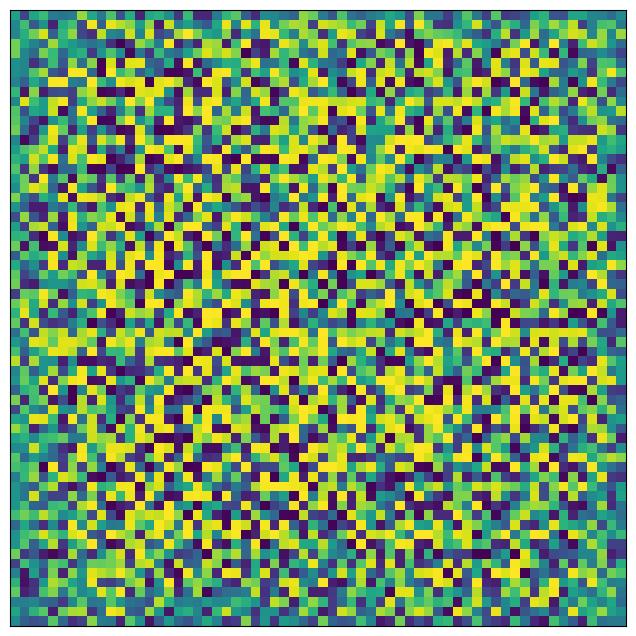

Saving generated-image-0000-05.png


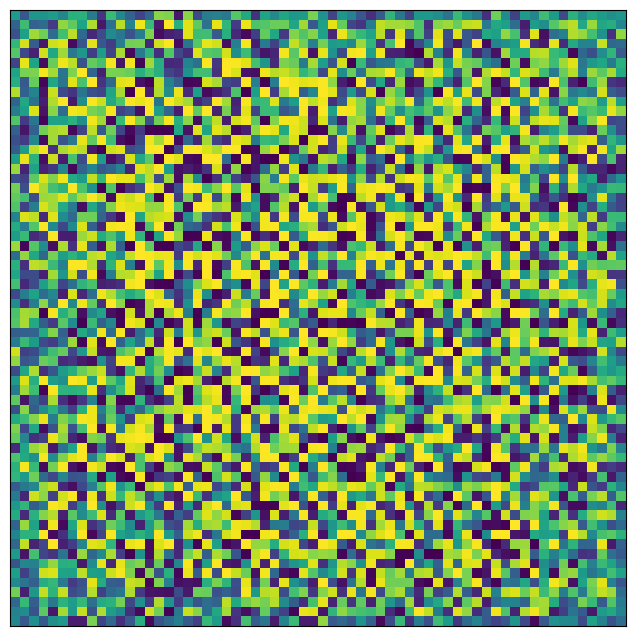

Saving generated-image-0000-06.png


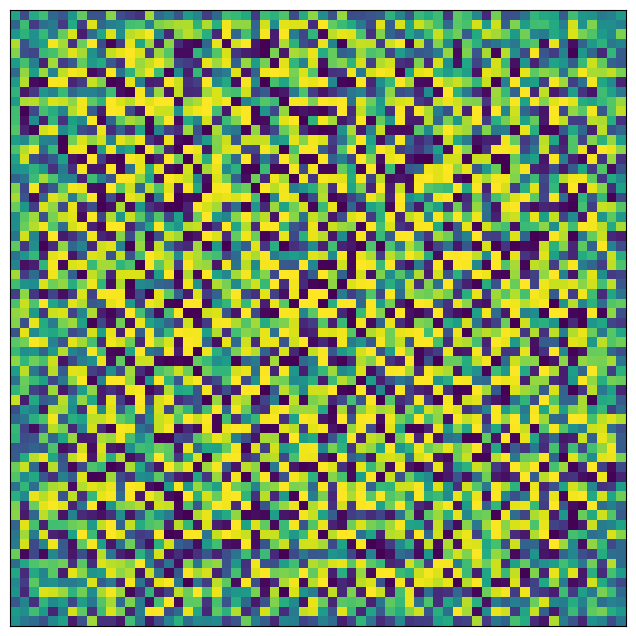

Saving generated-image-0000-07.png


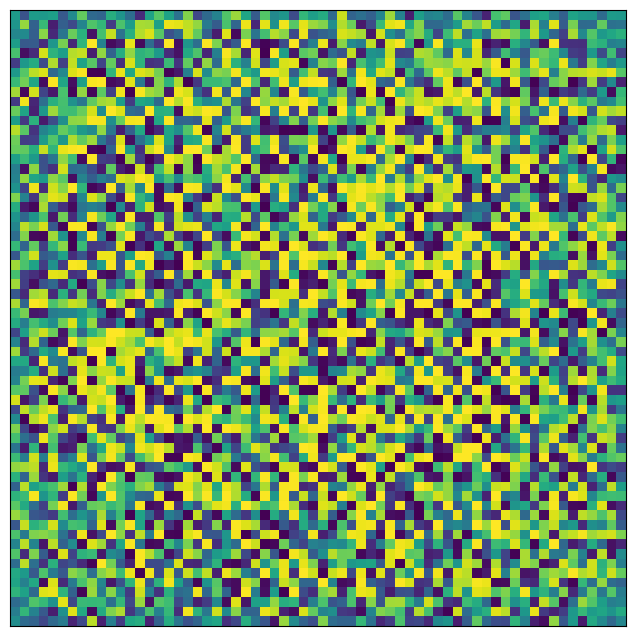

Saving generated-image-0000-08.png


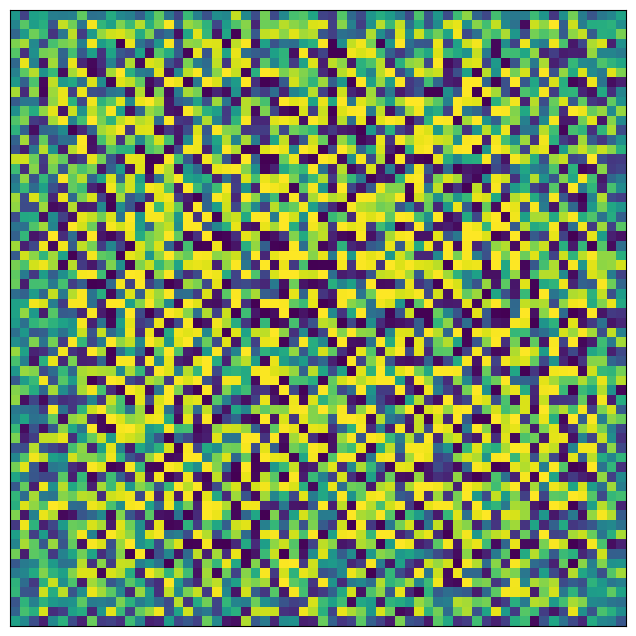

Saving generated-image-0000-09.png


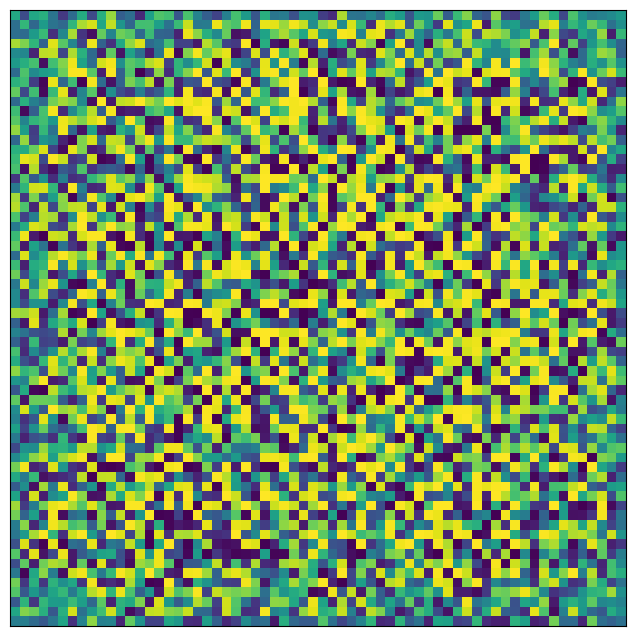

Saving generated-image-0000-10.png


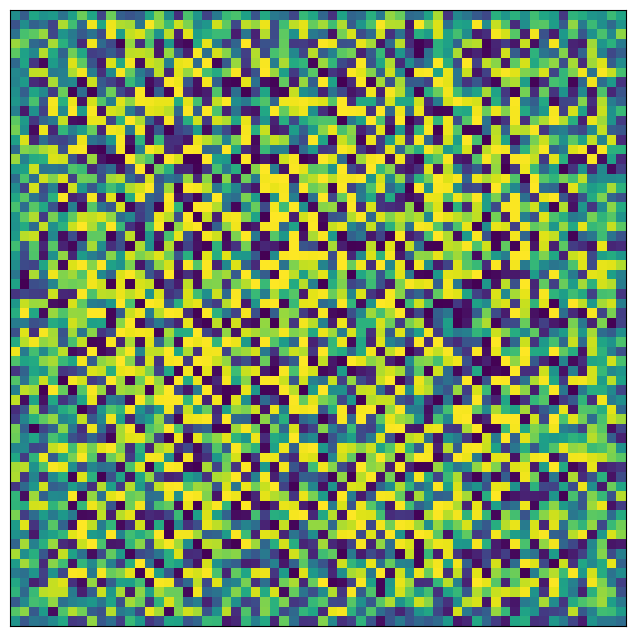

Saving generated-image-0000-11.png


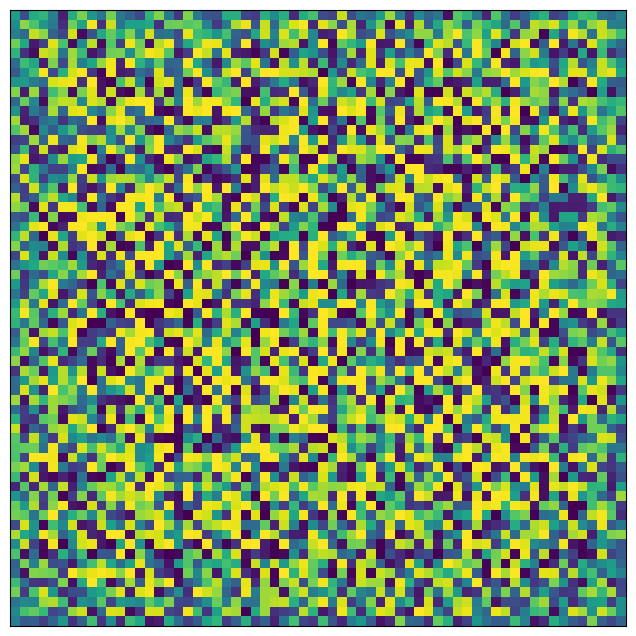

Saving generated-image-0000-12.png


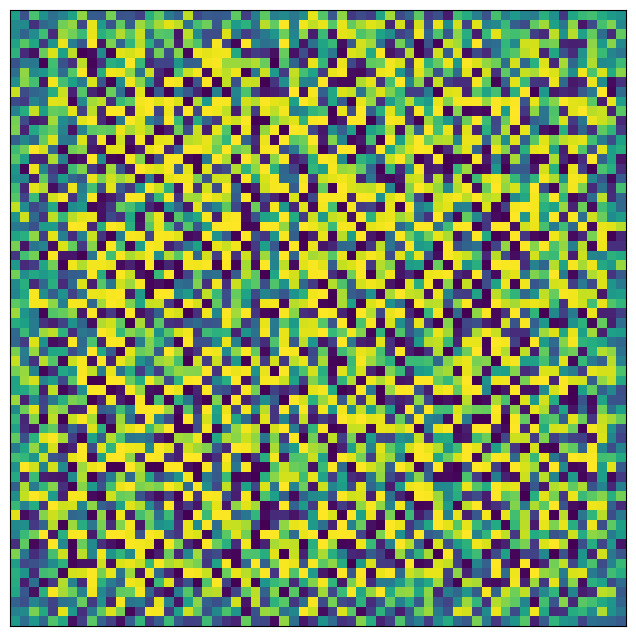

Saving generated-image-0000-13.png


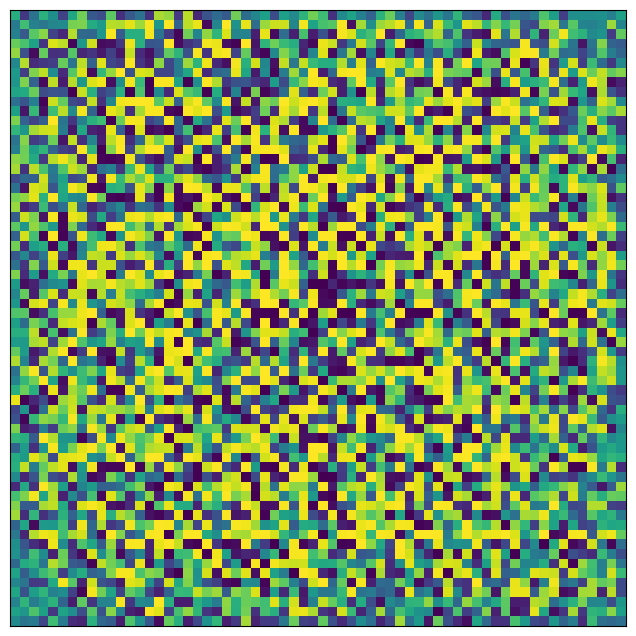

Saving generated-image-0000-14.png


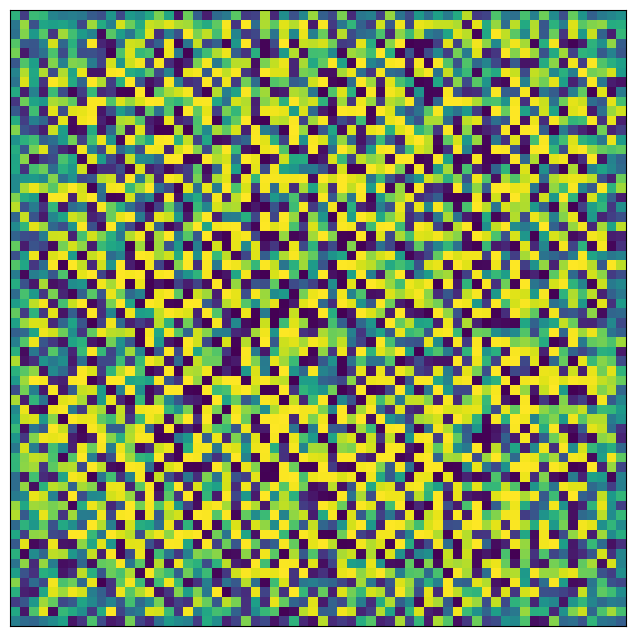

Saving generated-image-0000-15.png


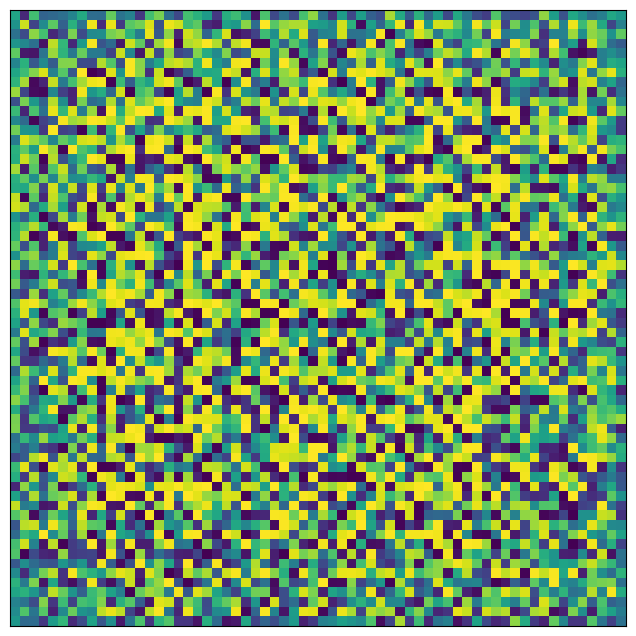

Saving generated-image-0000-16.png


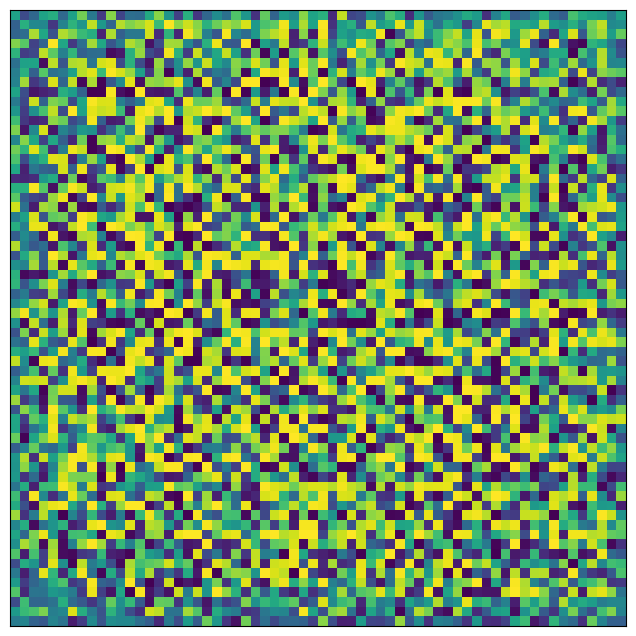

Saving generated-image-0000-17.png


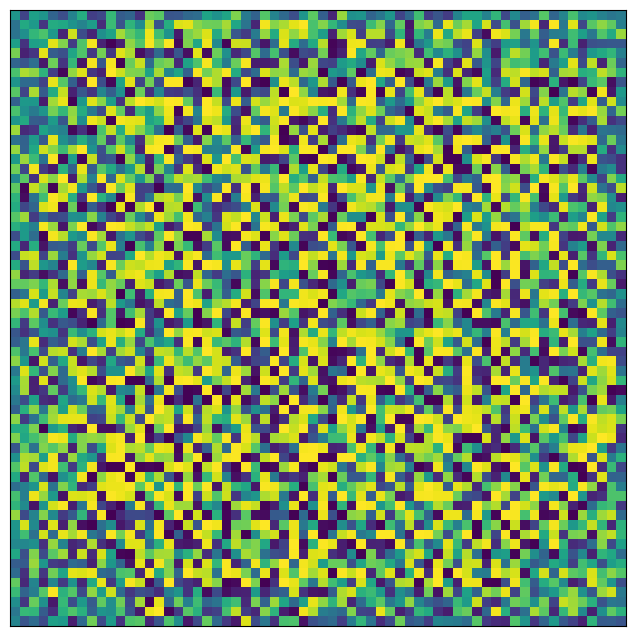

Saving generated-image-0000-18.png


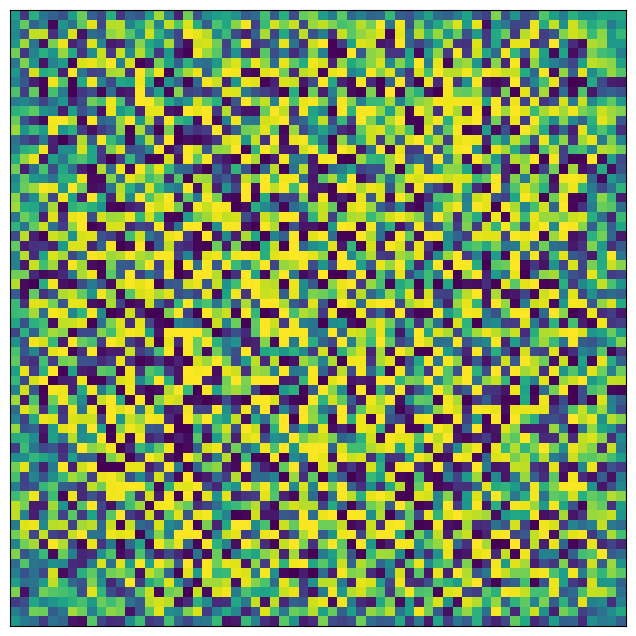

Saving generated-image-0000-19.png


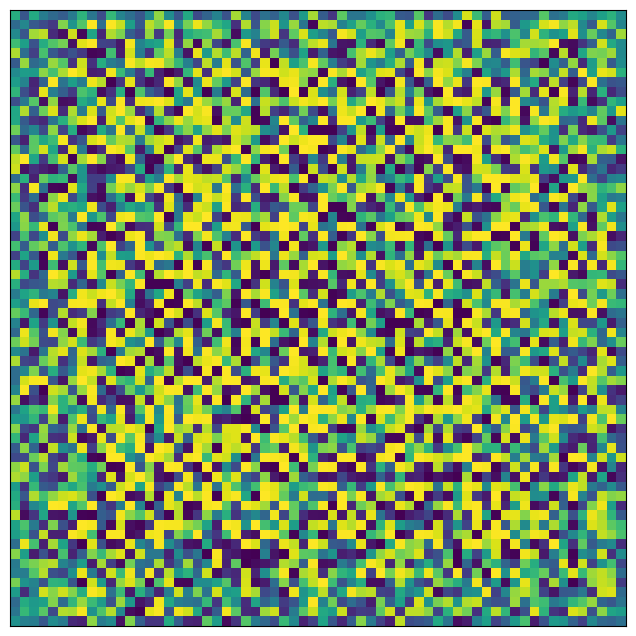

Saving generated-image-0000-20.png


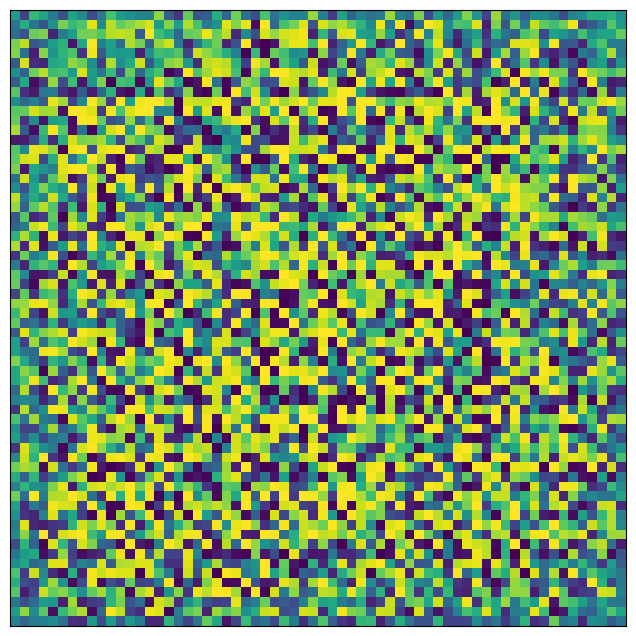

Saving generated-image-0000-21.png


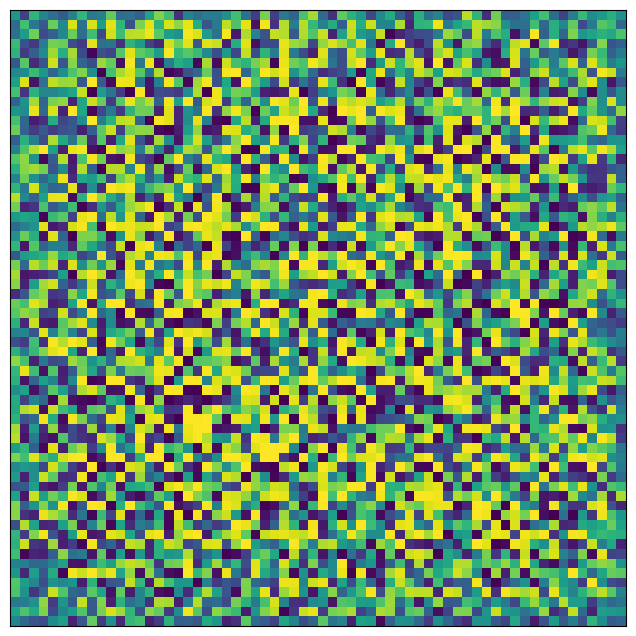

Saving generated-image-0000-22.png


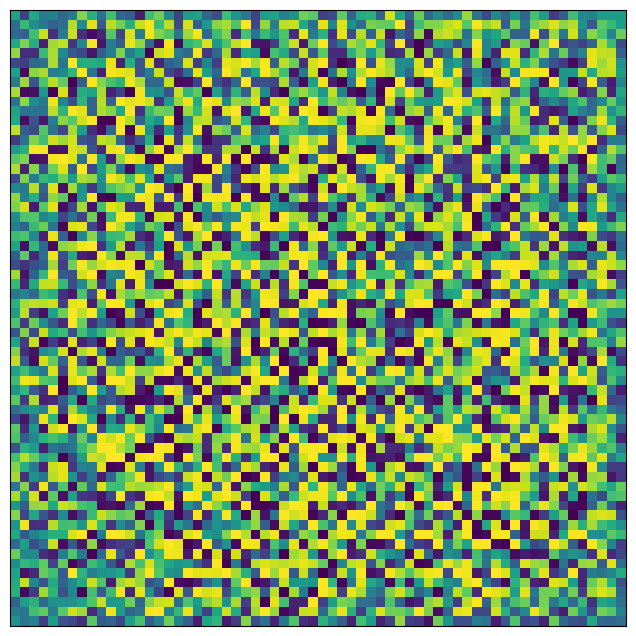

Saving generated-image-0000-23.png


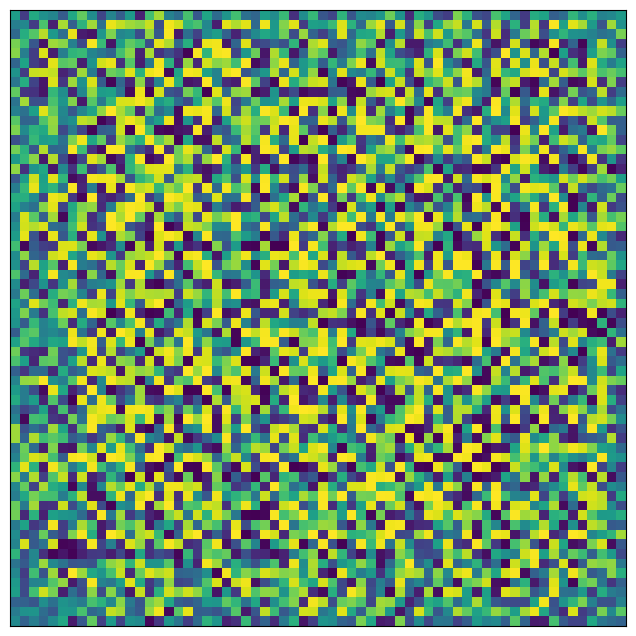

Saving generated-image-0000-24.png


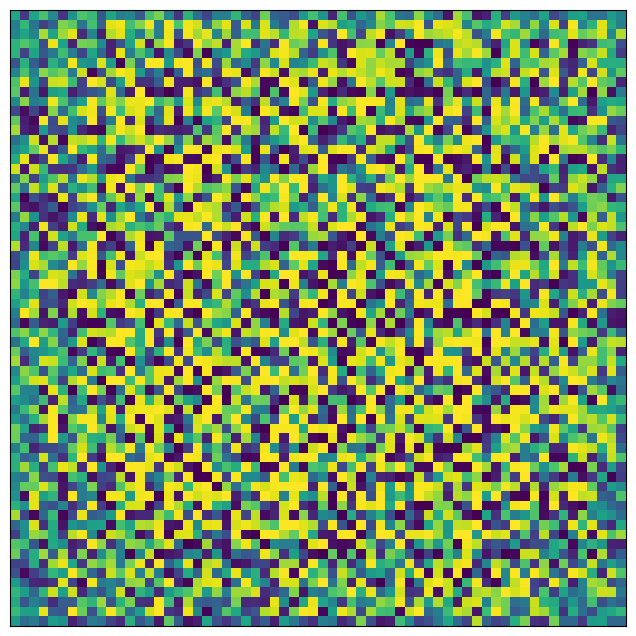

Saving generated-image-0000-25.png


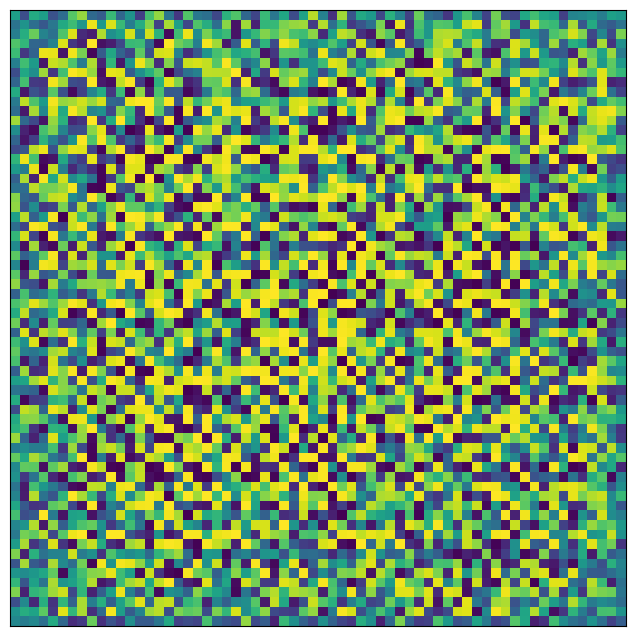

Saving generated-image-0000-26.png


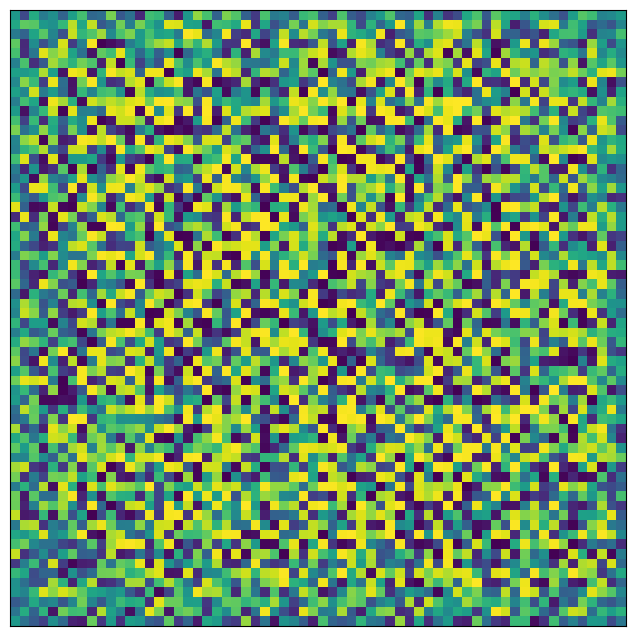

Saving generated-image-0000-27.png


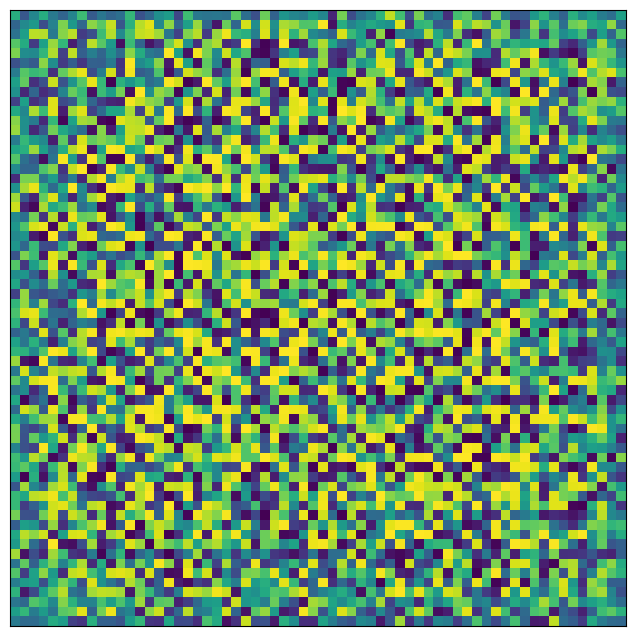

Saving generated-image-0000-28.png


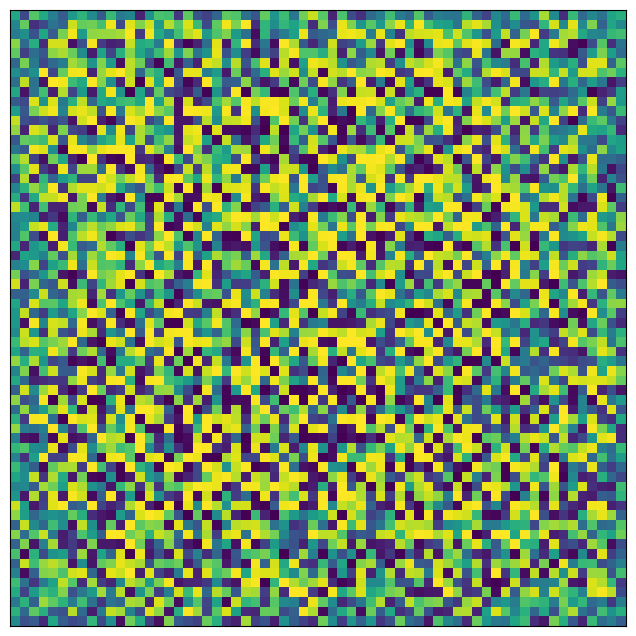

Saving generated-image-0000-29.png


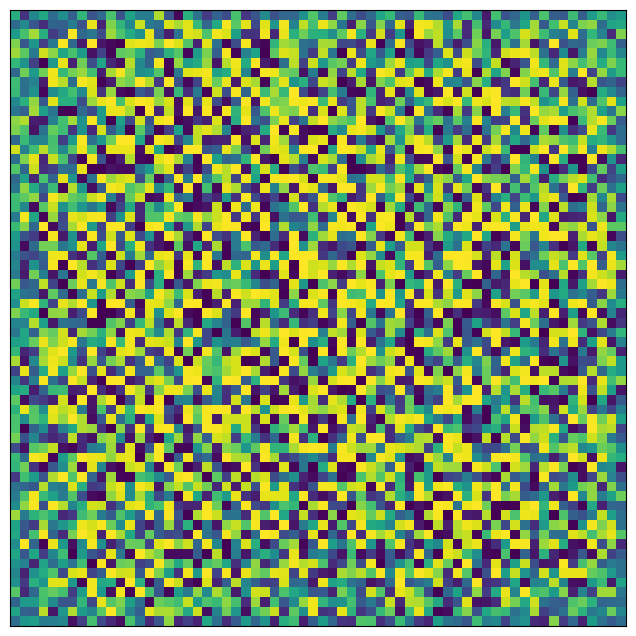

Saving generated-image-0000-30.png


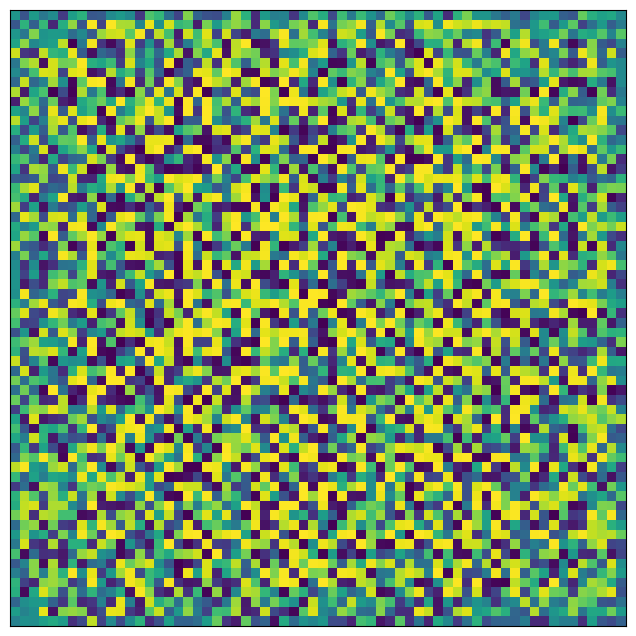

Saving generated-image-0000-31.png


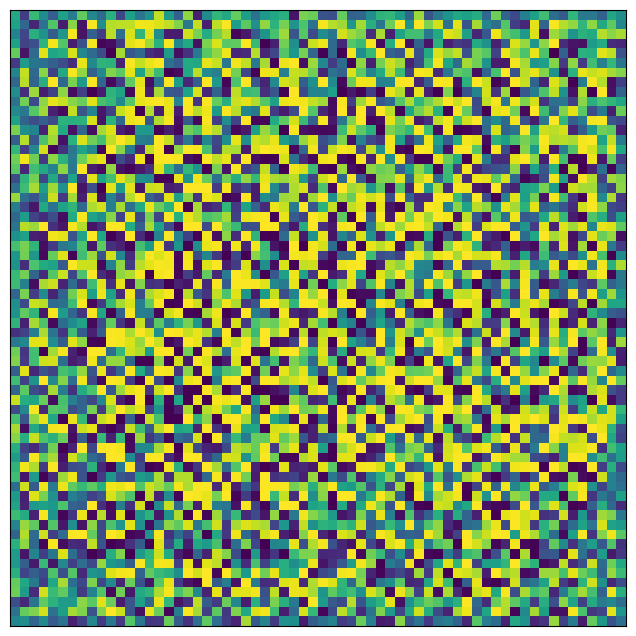

Saving generated-image-0000-32.png


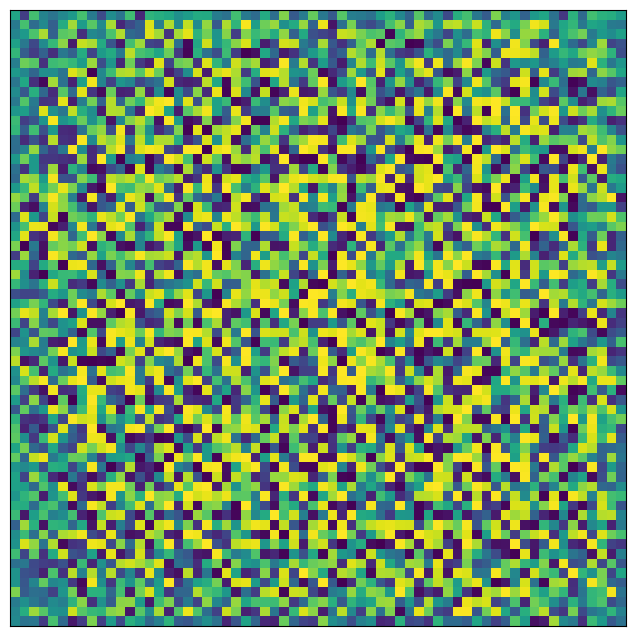

Saving generated-image-0000-33.png


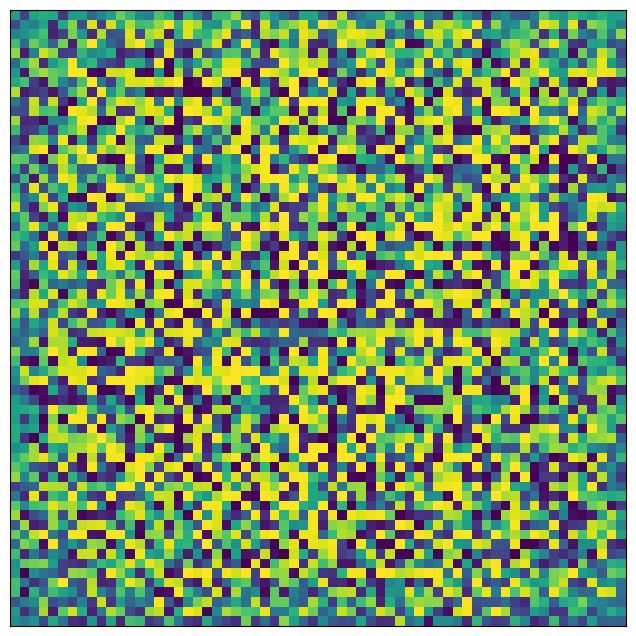

Saving generated-image-0000-34.png


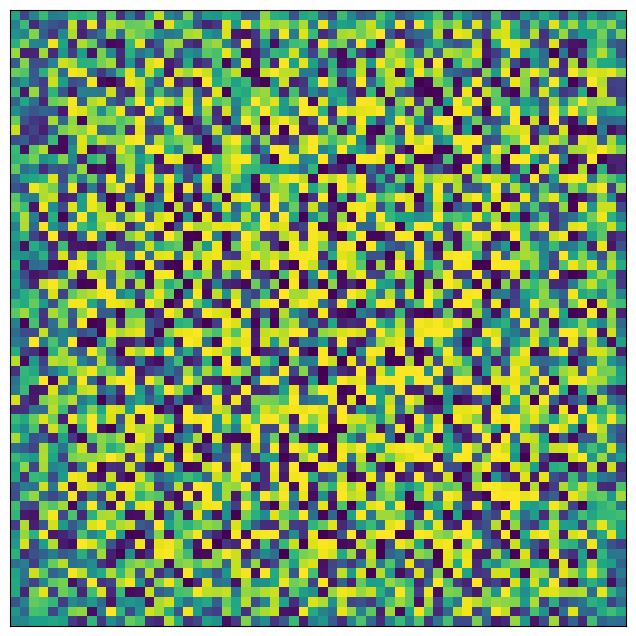

Saving generated-image-0000-35.png


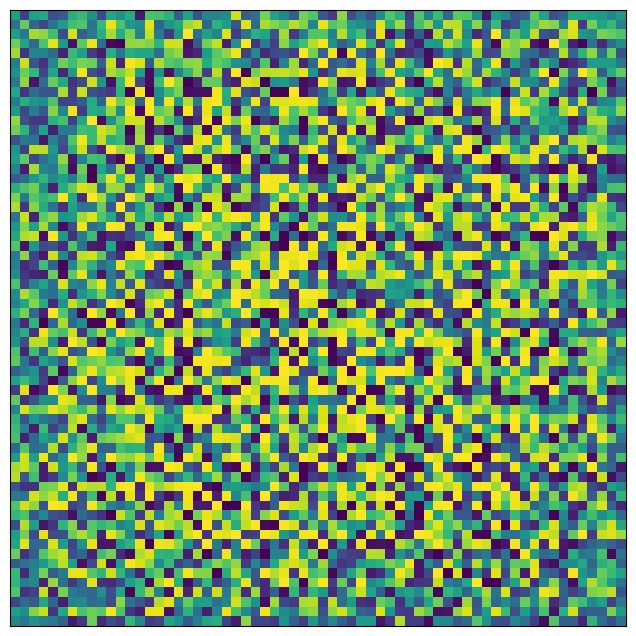

Saving generated-image-0000-36.png


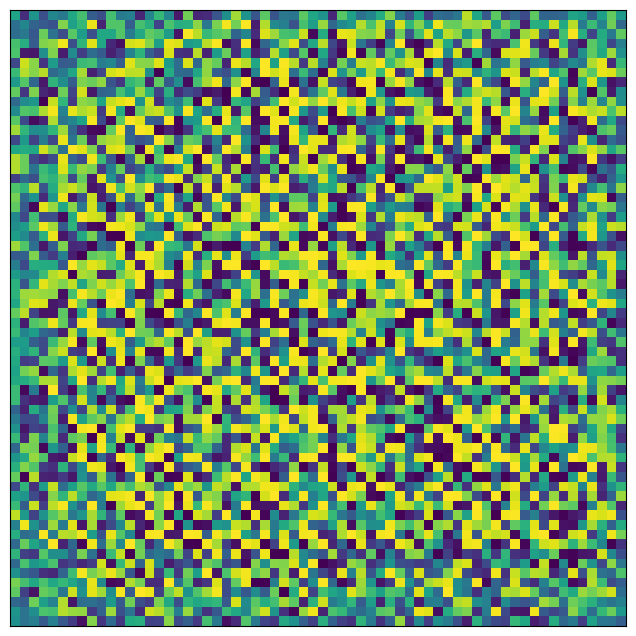

Saving generated-image-0000-37.png


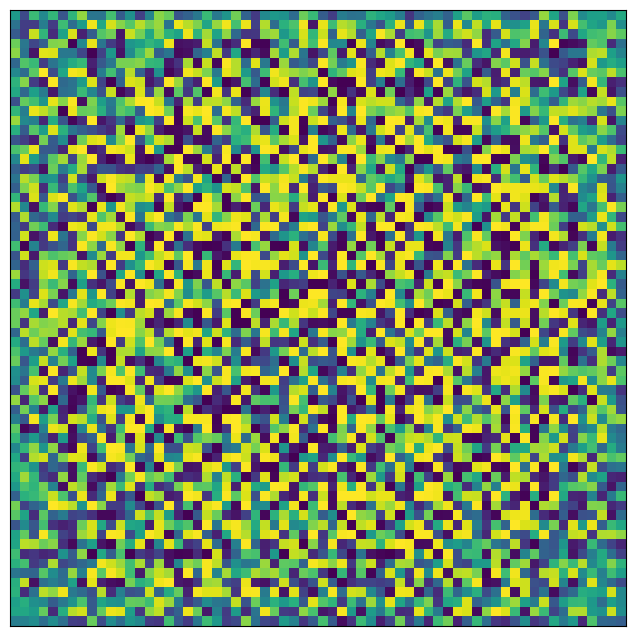

Saving generated-image-0000-38.png


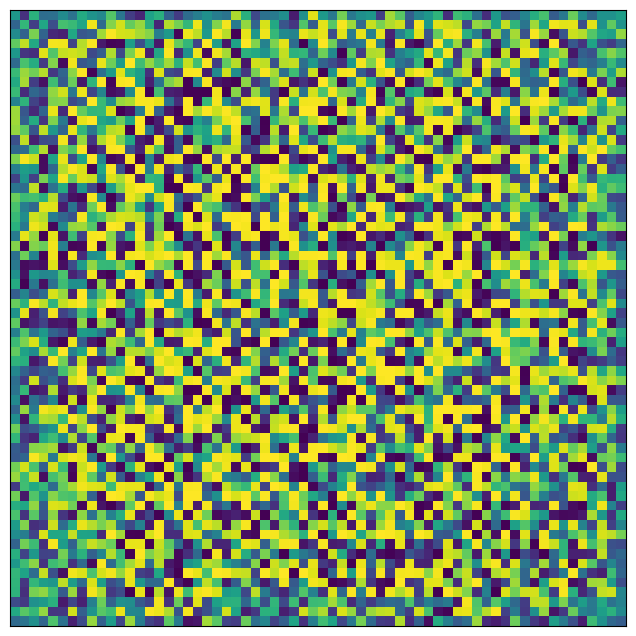

Saving generated-image-0000-39.png


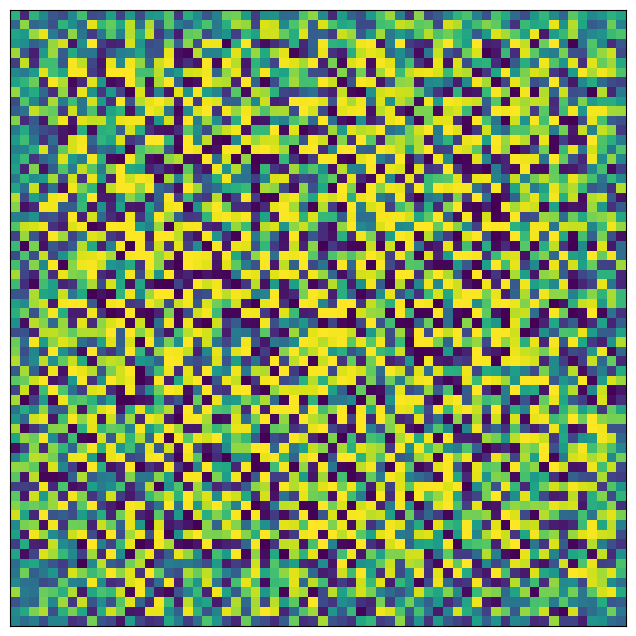

Saving generated-image-0000-40.png


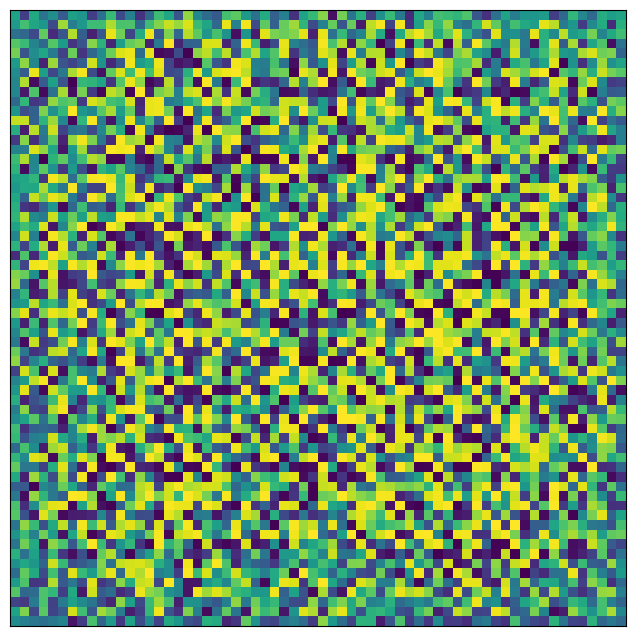

Saving generated-image-0000-41.png


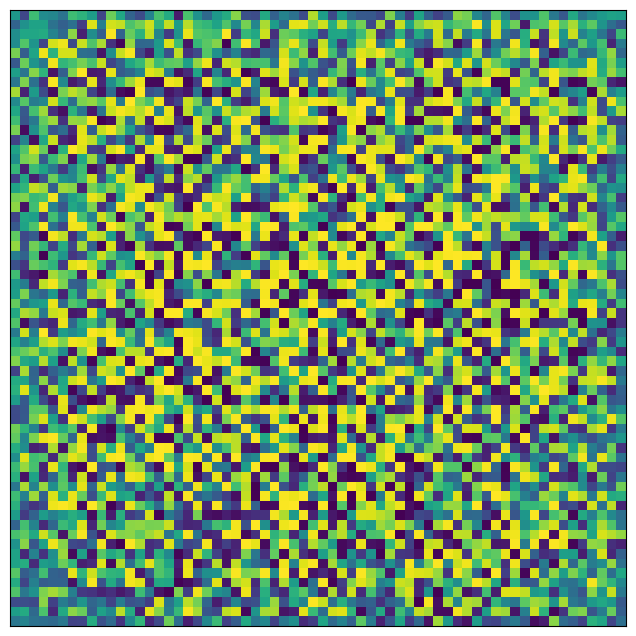

Saving generated-image-0000-42.png


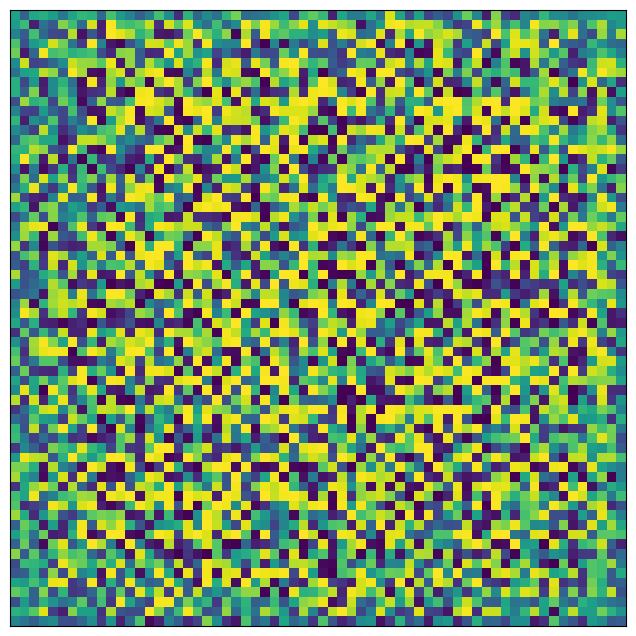

Saving generated-image-0000-43.png


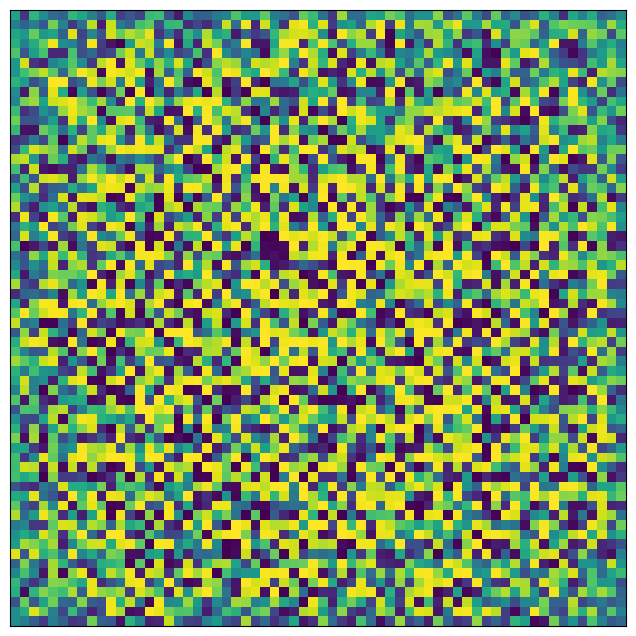

Saving generated-image-0000-44.png


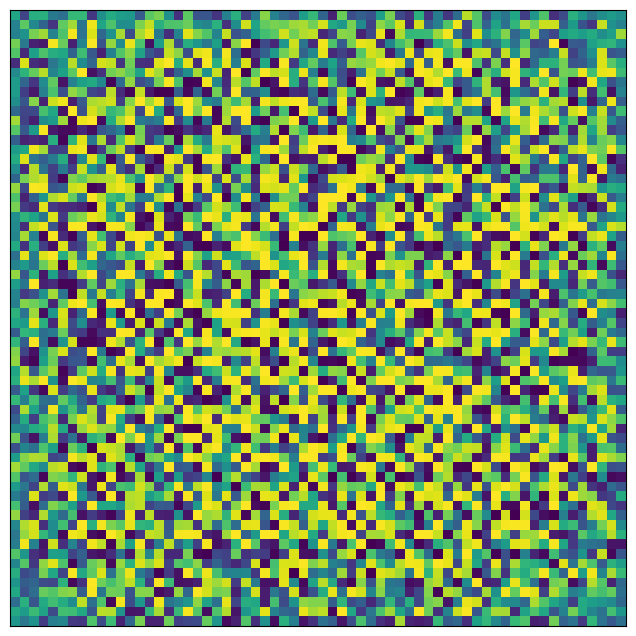

Saving generated-image-0000-45.png


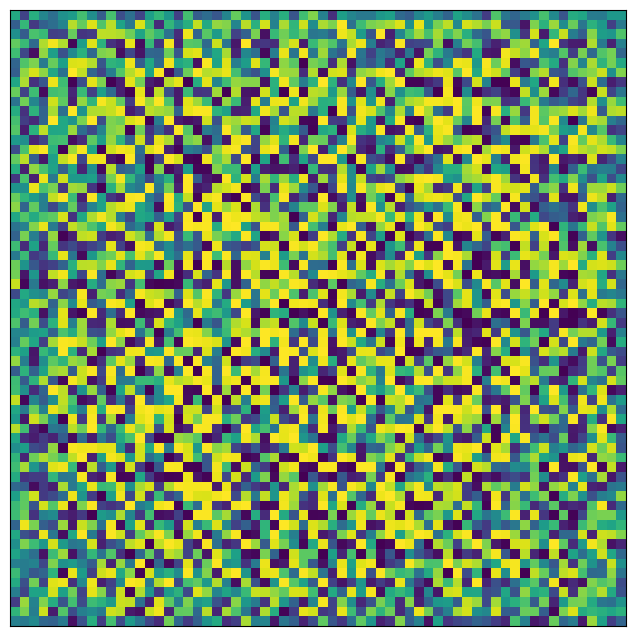

Saving generated-image-0000-46.png


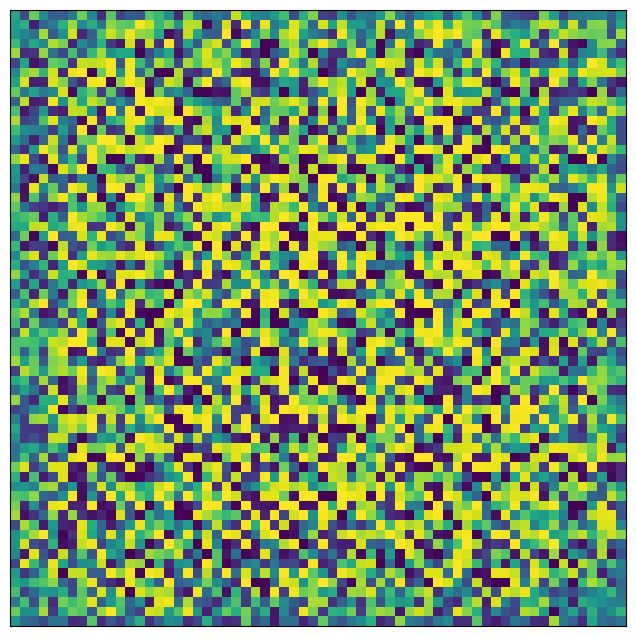

Saving generated-image-0000-47.png


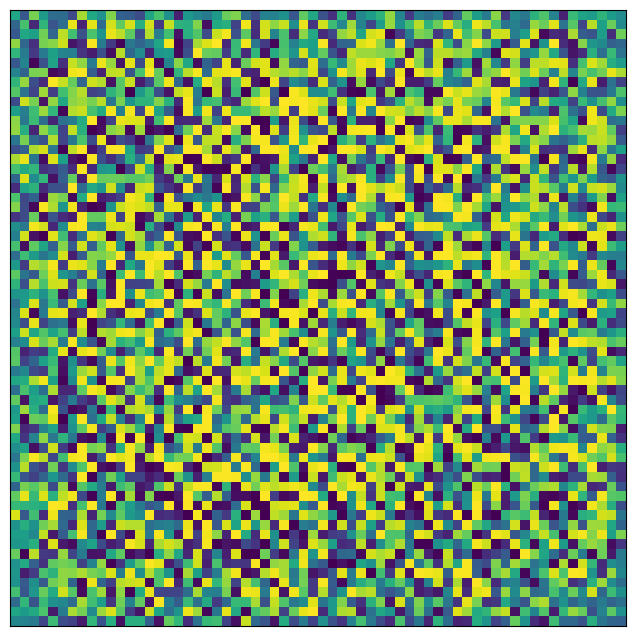

Saving generated-image-0000-48.png


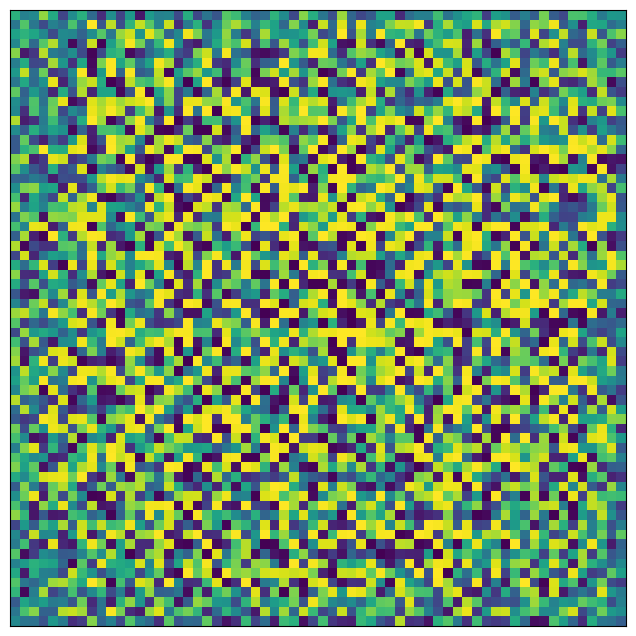

Saving generated-image-0000-49.png


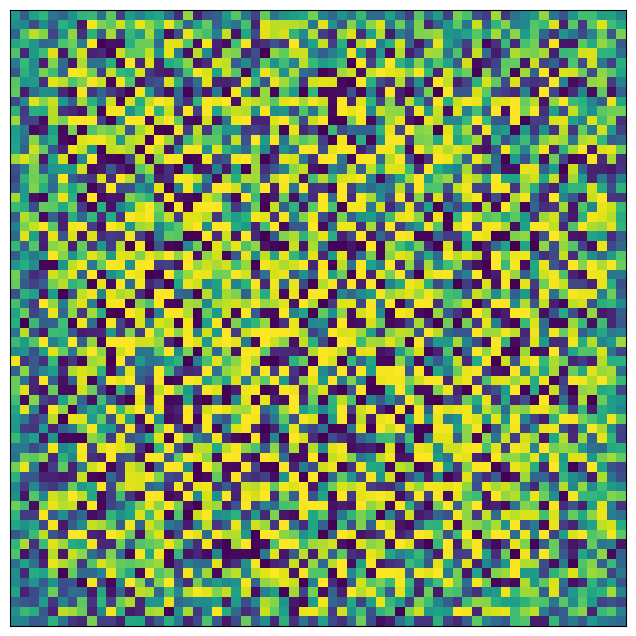

Saving generated-image-0000-50.png


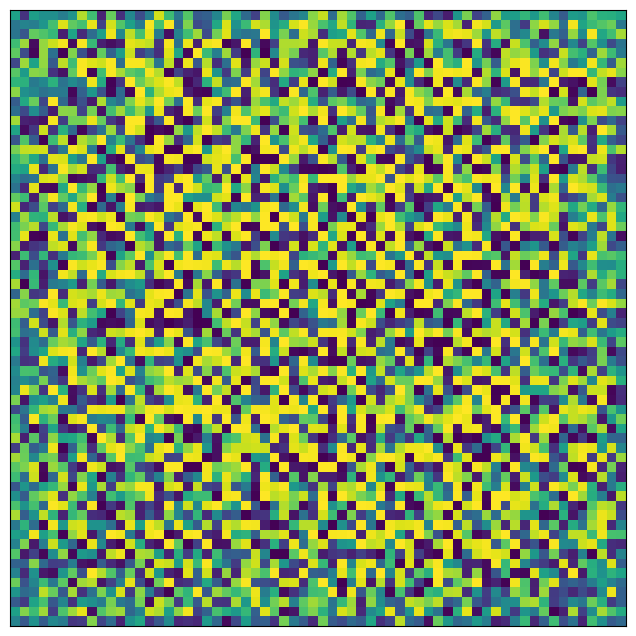

Saving generated-image-0000-51.png


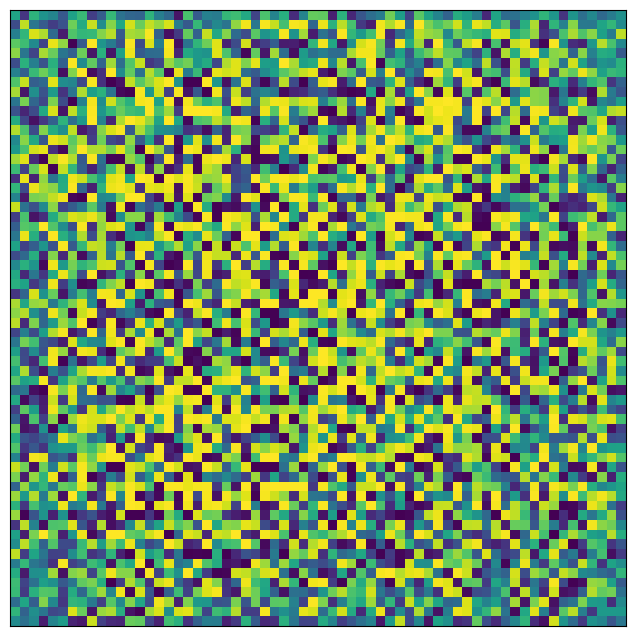

Saving generated-image-0000-52.png


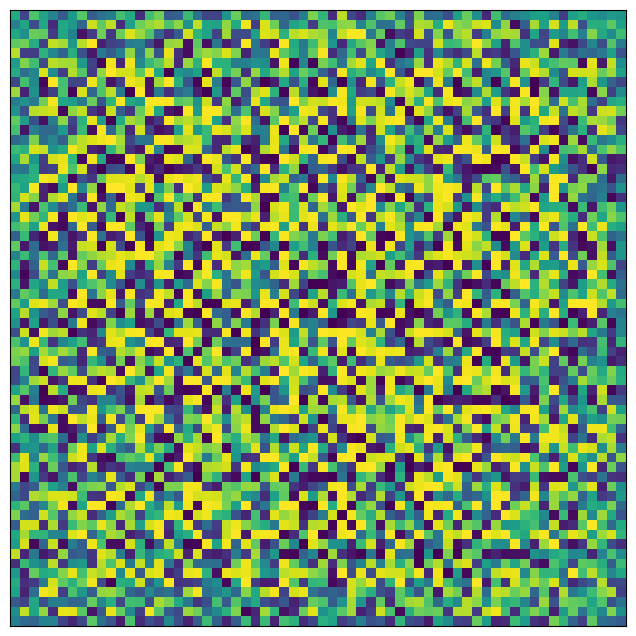

Saving generated-image-0000-53.png


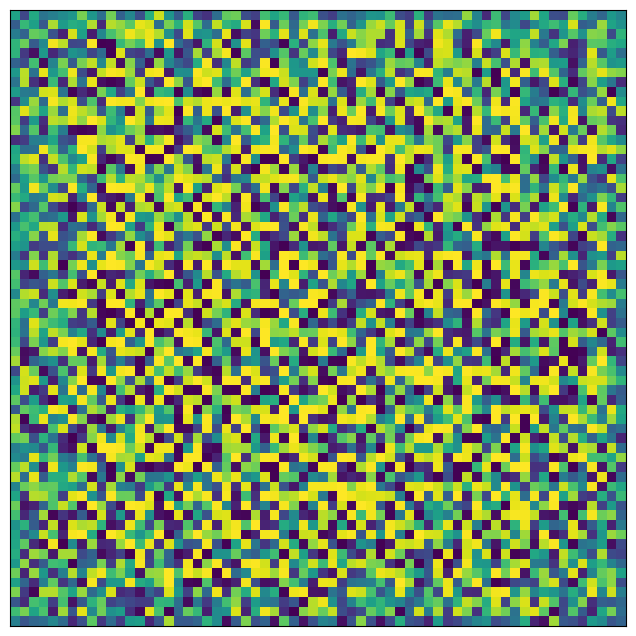

Saving generated-image-0000-54.png


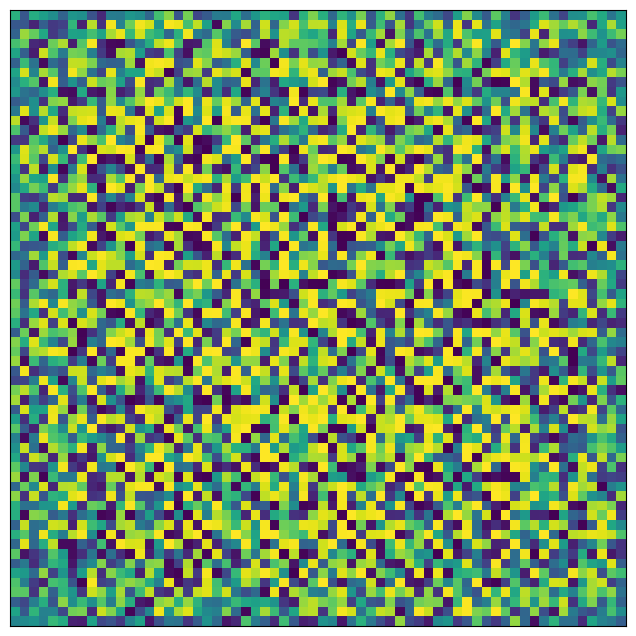

Saving generated-image-0000-55.png


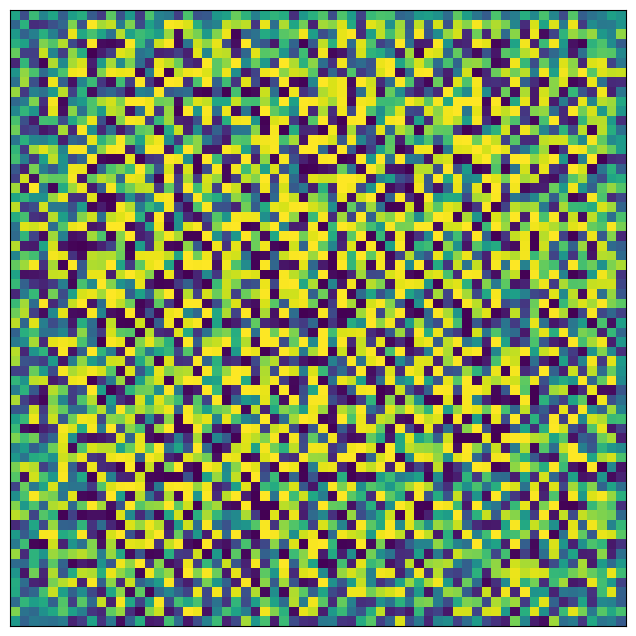

Saving generated-image-0000-56.png


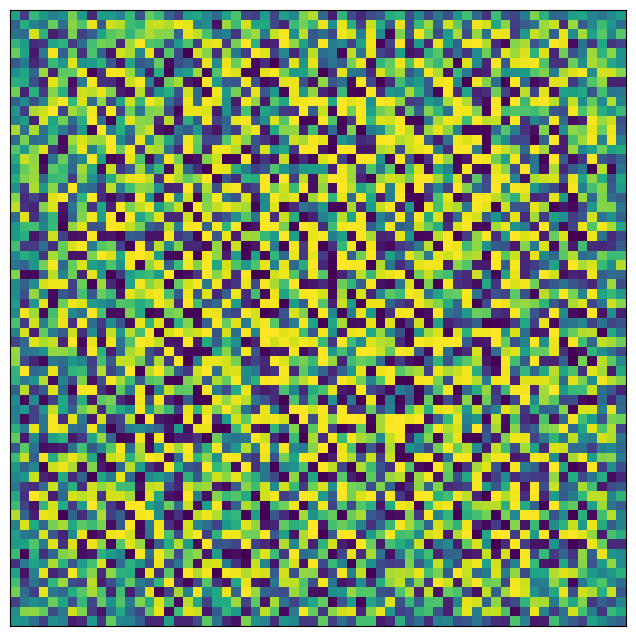

Saving generated-image-0000-57.png


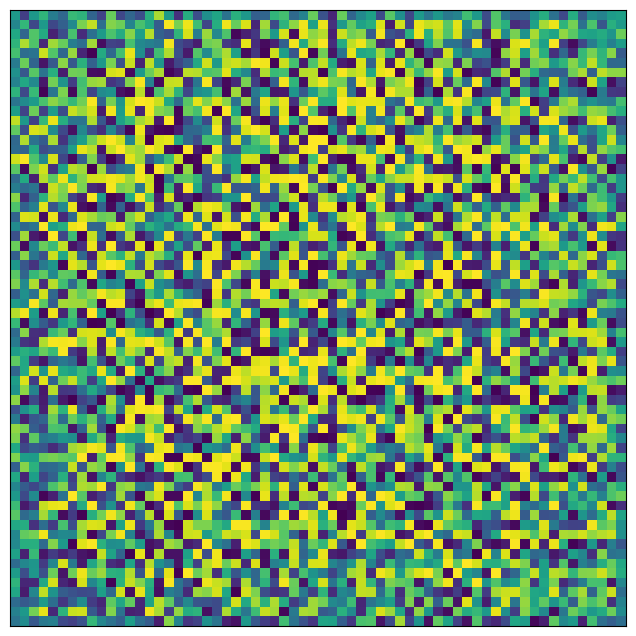

Saving generated-image-0000-58.png


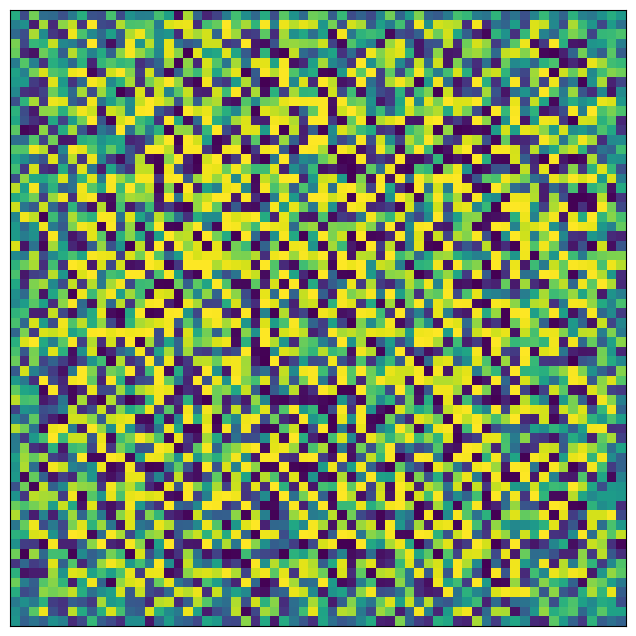

Saving generated-image-0000-59.png


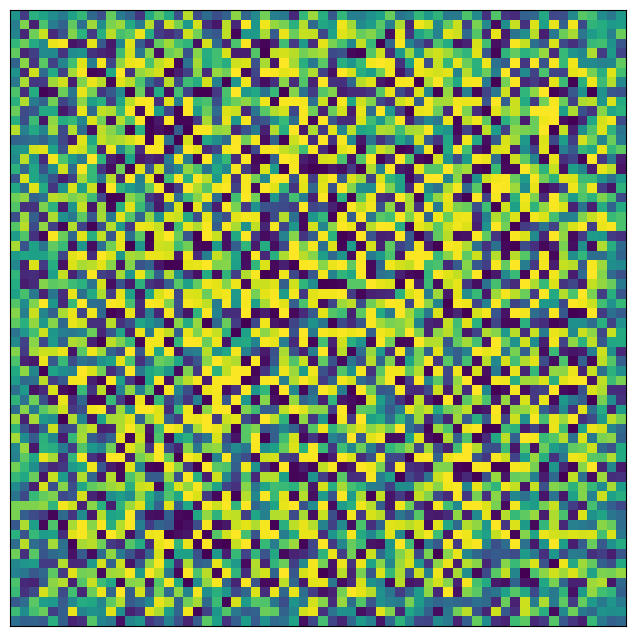

Saving generated-image-0000-60.png


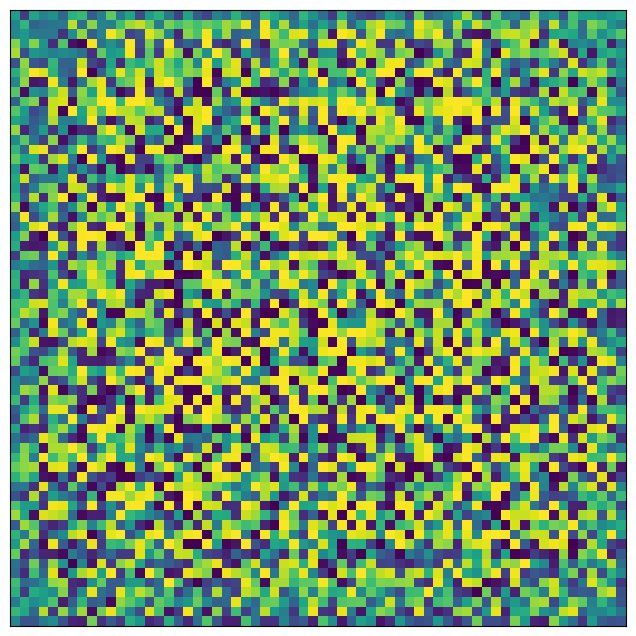

Saving generated-image-0000-61.png


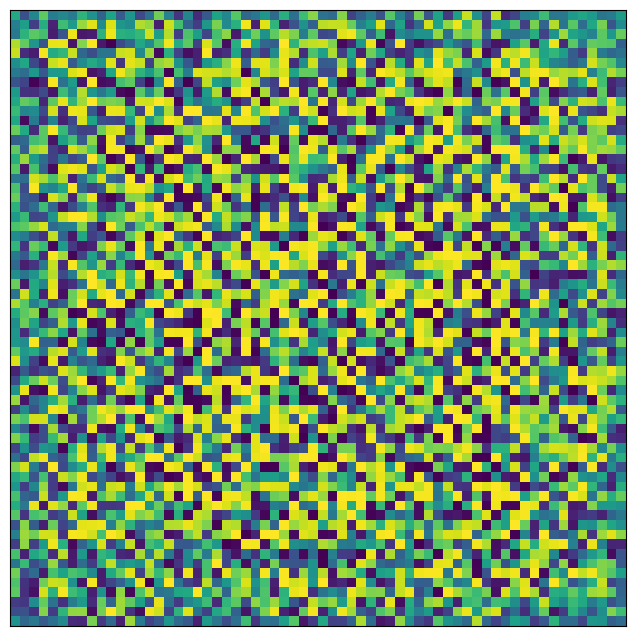

Saving generated-image-0000-62.png


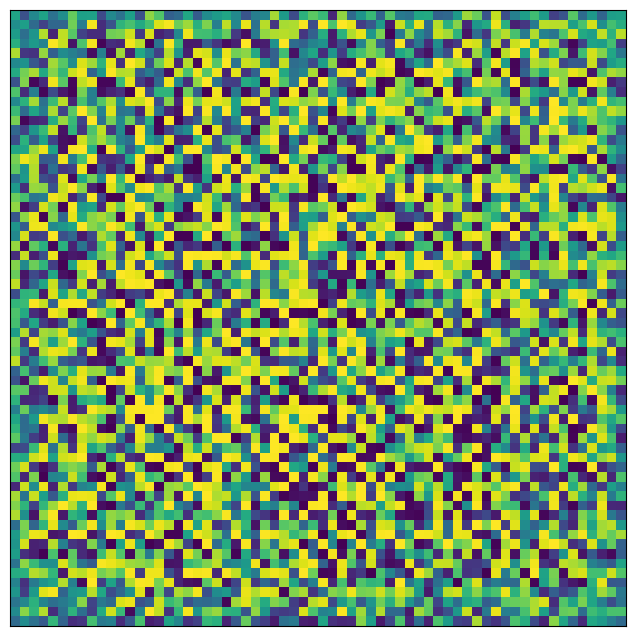

Saving generated-image-0000-63.png


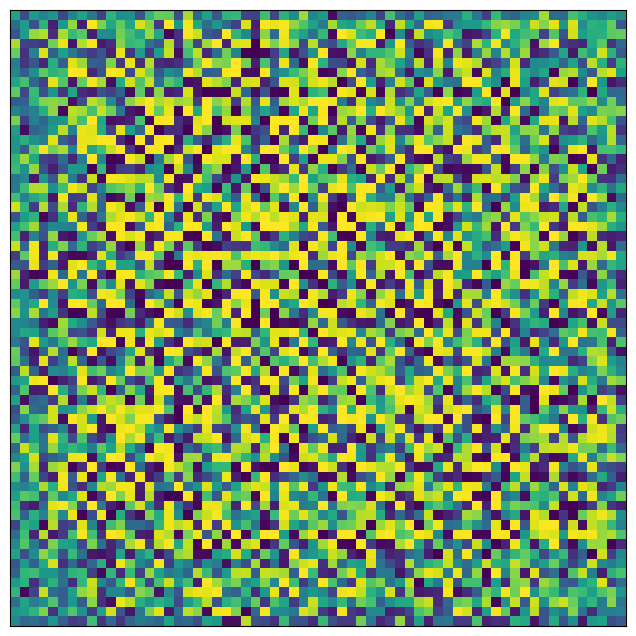

In [25]:
save_samples(0, fixed_latent)

In [26]:
from tqdm.notebook import tqdm
import torch.nn.functional as F


In [27]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [28]:
lr = 0.0002
epochs = 150

In [29]:
history = fit(epochs, lr)

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [1/150], loss_g: 17.0034, loss_d: 0.0507, real_score: 0.9526, fake_score: 0.0000
Saving generated-image-0001-00.png
Saving generated-image-0001-01.png
Saving generated-image-0001-02.png
Saving generated-image-0001-03.png
Saving generated-image-0001-04.png
Saving generated-image-0001-05.png
Saving generated-image-0001-06.png
Saving generated-image-0001-07.png
Saving generated-image-0001-08.png
Saving generated-image-0001-09.png
Saving generated-image-0001-10.png
Saving generated-image-0001-11.png
Saving generated-image-0001-12.png
Saving generated-image-0001-13.png
Saving generated-image-0001-14.png
Saving generated-image-0001-15.png
Saving generated-image-0001-16.png
Saving generated-image-0001-17.png
Saving generated-image-0001-18.png
Saving generated-image-0001-19.png
Saving generated-image-0001-20.png
Saving generated-image-0001-21.png
Saving generated-image-0001-22.png
Saving generated-image-0001-23.png
Saving generated-image-0001-24.png
Saving generated-image-0001-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [2/150], loss_g: 7.4873, loss_d: 0.0038, real_score: 0.9972, fake_score: 0.0010
Saving generated-image-0002-00.png
Saving generated-image-0002-01.png
Saving generated-image-0002-02.png
Saving generated-image-0002-03.png
Saving generated-image-0002-04.png
Saving generated-image-0002-05.png
Saving generated-image-0002-06.png
Saving generated-image-0002-07.png
Saving generated-image-0002-08.png
Saving generated-image-0002-09.png
Saving generated-image-0002-10.png
Saving generated-image-0002-11.png
Saving generated-image-0002-12.png
Saving generated-image-0002-13.png
Saving generated-image-0002-14.png
Saving generated-image-0002-15.png
Saving generated-image-0002-16.png
Saving generated-image-0002-17.png
Saving generated-image-0002-18.png
Saving generated-image-0002-19.png
Saving generated-image-0002-20.png
Saving generated-image-0002-21.png
Saving generated-image-0002-22.png
Saving generated-image-0002-23.png
Saving generated-image-0002-24.png
Saving generated-image-0002-25.png
Savi

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [3/150], loss_g: 11.2728, loss_d: 0.0025, real_score: 0.9980, fake_score: 0.0005
Saving generated-image-0003-00.png
Saving generated-image-0003-01.png
Saving generated-image-0003-02.png
Saving generated-image-0003-03.png
Saving generated-image-0003-04.png
Saving generated-image-0003-05.png
Saving generated-image-0003-06.png
Saving generated-image-0003-07.png
Saving generated-image-0003-08.png
Saving generated-image-0003-09.png
Saving generated-image-0003-10.png
Saving generated-image-0003-11.png
Saving generated-image-0003-12.png
Saving generated-image-0003-13.png
Saving generated-image-0003-14.png
Saving generated-image-0003-15.png
Saving generated-image-0003-16.png
Saving generated-image-0003-17.png
Saving generated-image-0003-18.png
Saving generated-image-0003-19.png
Saving generated-image-0003-20.png
Saving generated-image-0003-21.png
Saving generated-image-0003-22.png
Saving generated-image-0003-23.png
Saving generated-image-0003-24.png
Saving generated-image-0003-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [4/150], loss_g: 5.4886, loss_d: 0.2440, real_score: 0.8289, fake_score: 0.0068
Saving generated-image-0004-00.png
Saving generated-image-0004-01.png
Saving generated-image-0004-02.png
Saving generated-image-0004-03.png
Saving generated-image-0004-04.png
Saving generated-image-0004-05.png
Saving generated-image-0004-06.png
Saving generated-image-0004-07.png
Saving generated-image-0004-08.png
Saving generated-image-0004-09.png
Saving generated-image-0004-10.png
Saving generated-image-0004-11.png
Saving generated-image-0004-12.png
Saving generated-image-0004-13.png
Saving generated-image-0004-14.png
Saving generated-image-0004-15.png
Saving generated-image-0004-16.png
Saving generated-image-0004-17.png
Saving generated-image-0004-18.png
Saving generated-image-0004-19.png
Saving generated-image-0004-20.png
Saving generated-image-0004-21.png
Saving generated-image-0004-22.png
Saving generated-image-0004-23.png
Saving generated-image-0004-24.png
Saving generated-image-0004-25.png
Savi

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [5/150], loss_g: 6.6396, loss_d: 0.0085, real_score: 0.9990, fake_score: 0.0074
Saving generated-image-0005-00.png
Saving generated-image-0005-01.png
Saving generated-image-0005-02.png
Saving generated-image-0005-03.png
Saving generated-image-0005-04.png
Saving generated-image-0005-05.png
Saving generated-image-0005-06.png
Saving generated-image-0005-07.png
Saving generated-image-0005-08.png
Saving generated-image-0005-09.png
Saving generated-image-0005-10.png
Saving generated-image-0005-11.png
Saving generated-image-0005-12.png
Saving generated-image-0005-13.png
Saving generated-image-0005-14.png
Saving generated-image-0005-15.png
Saving generated-image-0005-16.png
Saving generated-image-0005-17.png
Saving generated-image-0005-18.png
Saving generated-image-0005-19.png
Saving generated-image-0005-20.png
Saving generated-image-0005-21.png
Saving generated-image-0005-22.png
Saving generated-image-0005-23.png
Saving generated-image-0005-24.png
Saving generated-image-0005-25.png
Savi

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [6/150], loss_g: 7.0778, loss_d: 0.0015, real_score: 0.9997, fake_score: 0.0012
Saving generated-image-0006-00.png
Saving generated-image-0006-01.png
Saving generated-image-0006-02.png
Saving generated-image-0006-03.png
Saving generated-image-0006-04.png
Saving generated-image-0006-05.png
Saving generated-image-0006-06.png
Saving generated-image-0006-07.png
Saving generated-image-0006-08.png
Saving generated-image-0006-09.png
Saving generated-image-0006-10.png
Saving generated-image-0006-11.png
Saving generated-image-0006-12.png
Saving generated-image-0006-13.png
Saving generated-image-0006-14.png
Saving generated-image-0006-15.png
Saving generated-image-0006-16.png
Saving generated-image-0006-17.png
Saving generated-image-0006-18.png
Saving generated-image-0006-19.png
Saving generated-image-0006-20.png
Saving generated-image-0006-21.png
Saving generated-image-0006-22.png
Saving generated-image-0006-23.png
Saving generated-image-0006-24.png
Saving generated-image-0006-25.png
Savi

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [7/150], loss_g: 1.1686, loss_d: 2.0545, real_score: 0.3924, fake_score: 0.0741
Saving generated-image-0007-00.png
Saving generated-image-0007-01.png
Saving generated-image-0007-02.png
Saving generated-image-0007-03.png
Saving generated-image-0007-04.png
Saving generated-image-0007-05.png
Saving generated-image-0007-06.png
Saving generated-image-0007-07.png
Saving generated-image-0007-08.png
Saving generated-image-0007-09.png
Saving generated-image-0007-10.png
Saving generated-image-0007-11.png
Saving generated-image-0007-12.png
Saving generated-image-0007-13.png
Saving generated-image-0007-14.png
Saving generated-image-0007-15.png
Saving generated-image-0007-16.png
Saving generated-image-0007-17.png
Saving generated-image-0007-18.png
Saving generated-image-0007-19.png
Saving generated-image-0007-20.png
Saving generated-image-0007-21.png
Saving generated-image-0007-22.png
Saving generated-image-0007-23.png
Saving generated-image-0007-24.png
Saving generated-image-0007-25.png
Savi

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [8/150], loss_g: 9.5628, loss_d: 0.4500, real_score: 0.6778, fake_score: 0.0005
Saving generated-image-0008-00.png
Saving generated-image-0008-01.png
Saving generated-image-0008-02.png
Saving generated-image-0008-03.png
Saving generated-image-0008-04.png
Saving generated-image-0008-05.png
Saving generated-image-0008-06.png
Saving generated-image-0008-07.png
Saving generated-image-0008-08.png
Saving generated-image-0008-09.png
Saving generated-image-0008-10.png
Saving generated-image-0008-11.png
Saving generated-image-0008-12.png
Saving generated-image-0008-13.png
Saving generated-image-0008-14.png
Saving generated-image-0008-15.png
Saving generated-image-0008-16.png
Saving generated-image-0008-17.png
Saving generated-image-0008-18.png
Saving generated-image-0008-19.png
Saving generated-image-0008-20.png
Saving generated-image-0008-21.png
Saving generated-image-0008-22.png
Saving generated-image-0008-23.png
Saving generated-image-0008-24.png
Saving generated-image-0008-25.png
Savi

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [9/150], loss_g: 2.0987, loss_d: 0.3746, real_score: 0.9370, fake_score: 0.2075
Saving generated-image-0009-00.png
Saving generated-image-0009-01.png
Saving generated-image-0009-02.png
Saving generated-image-0009-03.png
Saving generated-image-0009-04.png
Saving generated-image-0009-05.png
Saving generated-image-0009-06.png
Saving generated-image-0009-07.png
Saving generated-image-0009-08.png
Saving generated-image-0009-09.png
Saving generated-image-0009-10.png
Saving generated-image-0009-11.png
Saving generated-image-0009-12.png
Saving generated-image-0009-13.png
Saving generated-image-0009-14.png
Saving generated-image-0009-15.png
Saving generated-image-0009-16.png
Saving generated-image-0009-17.png
Saving generated-image-0009-18.png
Saving generated-image-0009-19.png
Saving generated-image-0009-20.png
Saving generated-image-0009-21.png
Saving generated-image-0009-22.png
Saving generated-image-0009-23.png
Saving generated-image-0009-24.png
Saving generated-image-0009-25.png
Savi

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [10/150], loss_g: 2.5466, loss_d: 0.2044, real_score: 0.9748, fake_score: 0.1559
Saving generated-image-0010-00.png
Saving generated-image-0010-01.png
Saving generated-image-0010-02.png
Saving generated-image-0010-03.png
Saving generated-image-0010-04.png
Saving generated-image-0010-05.png
Saving generated-image-0010-06.png
Saving generated-image-0010-07.png
Saving generated-image-0010-08.png
Saving generated-image-0010-09.png
Saving generated-image-0010-10.png
Saving generated-image-0010-11.png
Saving generated-image-0010-12.png
Saving generated-image-0010-13.png
Saving generated-image-0010-14.png
Saving generated-image-0010-15.png
Saving generated-image-0010-16.png
Saving generated-image-0010-17.png
Saving generated-image-0010-18.png
Saving generated-image-0010-19.png
Saving generated-image-0010-20.png
Saving generated-image-0010-21.png
Saving generated-image-0010-22.png
Saving generated-image-0010-23.png
Saving generated-image-0010-24.png
Saving generated-image-0010-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [11/150], loss_g: 2.2798, loss_d: 0.2514, real_score: 0.8314, fake_score: 0.0309
Saving generated-image-0011-00.png
Saving generated-image-0011-01.png
Saving generated-image-0011-02.png
Saving generated-image-0011-03.png
Saving generated-image-0011-04.png
Saving generated-image-0011-05.png
Saving generated-image-0011-06.png
Saving generated-image-0011-07.png
Saving generated-image-0011-08.png
Saving generated-image-0011-09.png
Saving generated-image-0011-10.png
Saving generated-image-0011-11.png
Saving generated-image-0011-12.png
Saving generated-image-0011-13.png
Saving generated-image-0011-14.png
Saving generated-image-0011-15.png
Saving generated-image-0011-16.png
Saving generated-image-0011-17.png
Saving generated-image-0011-18.png
Saving generated-image-0011-19.png
Saving generated-image-0011-20.png
Saving generated-image-0011-21.png
Saving generated-image-0011-22.png
Saving generated-image-0011-23.png
Saving generated-image-0011-24.png
Saving generated-image-0011-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [12/150], loss_g: 3.0902, loss_d: 0.2376, real_score: 0.8668, fake_score: 0.0821
Saving generated-image-0012-00.png
Saving generated-image-0012-01.png
Saving generated-image-0012-02.png
Saving generated-image-0012-03.png
Saving generated-image-0012-04.png
Saving generated-image-0012-05.png
Saving generated-image-0012-06.png
Saving generated-image-0012-07.png
Saving generated-image-0012-08.png
Saving generated-image-0012-09.png
Saving generated-image-0012-10.png
Saving generated-image-0012-11.png
Saving generated-image-0012-12.png
Saving generated-image-0012-13.png
Saving generated-image-0012-14.png
Saving generated-image-0012-15.png
Saving generated-image-0012-16.png
Saving generated-image-0012-17.png
Saving generated-image-0012-18.png
Saving generated-image-0012-19.png
Saving generated-image-0012-20.png
Saving generated-image-0012-21.png
Saving generated-image-0012-22.png
Saving generated-image-0012-23.png
Saving generated-image-0012-24.png
Saving generated-image-0012-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [13/150], loss_g: 2.1616, loss_d: 3.0089, real_score: 0.1553, fake_score: 0.0216
Saving generated-image-0013-00.png
Saving generated-image-0013-01.png
Saving generated-image-0013-02.png
Saving generated-image-0013-03.png
Saving generated-image-0013-04.png
Saving generated-image-0013-05.png
Saving generated-image-0013-06.png
Saving generated-image-0013-07.png
Saving generated-image-0013-08.png
Saving generated-image-0013-09.png
Saving generated-image-0013-10.png
Saving generated-image-0013-11.png
Saving generated-image-0013-12.png
Saving generated-image-0013-13.png
Saving generated-image-0013-14.png
Saving generated-image-0013-15.png
Saving generated-image-0013-16.png
Saving generated-image-0013-17.png
Saving generated-image-0013-18.png
Saving generated-image-0013-19.png
Saving generated-image-0013-20.png
Saving generated-image-0013-21.png
Saving generated-image-0013-22.png
Saving generated-image-0013-23.png
Saving generated-image-0013-24.png
Saving generated-image-0013-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [14/150], loss_g: 4.4620, loss_d: 0.2268, real_score: 0.9994, fake_score: 0.1910
Saving generated-image-0014-00.png
Saving generated-image-0014-01.png
Saving generated-image-0014-02.png
Saving generated-image-0014-03.png
Saving generated-image-0014-04.png
Saving generated-image-0014-05.png
Saving generated-image-0014-06.png
Saving generated-image-0014-07.png
Saving generated-image-0014-08.png
Saving generated-image-0014-09.png
Saving generated-image-0014-10.png
Saving generated-image-0014-11.png
Saving generated-image-0014-12.png
Saving generated-image-0014-13.png
Saving generated-image-0014-14.png
Saving generated-image-0014-15.png
Saving generated-image-0014-16.png
Saving generated-image-0014-17.png
Saving generated-image-0014-18.png
Saving generated-image-0014-19.png
Saving generated-image-0014-20.png
Saving generated-image-0014-21.png
Saving generated-image-0014-22.png
Saving generated-image-0014-23.png
Saving generated-image-0014-24.png
Saving generated-image-0014-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [15/150], loss_g: 4.4003, loss_d: 0.3511, real_score: 0.7766, fake_score: 0.0704
Saving generated-image-0015-00.png
Saving generated-image-0015-01.png
Saving generated-image-0015-02.png
Saving generated-image-0015-03.png
Saving generated-image-0015-04.png
Saving generated-image-0015-05.png
Saving generated-image-0015-06.png
Saving generated-image-0015-07.png
Saving generated-image-0015-08.png
Saving generated-image-0015-09.png
Saving generated-image-0015-10.png
Saving generated-image-0015-11.png
Saving generated-image-0015-12.png
Saving generated-image-0015-13.png
Saving generated-image-0015-14.png
Saving generated-image-0015-15.png
Saving generated-image-0015-16.png
Saving generated-image-0015-17.png
Saving generated-image-0015-18.png
Saving generated-image-0015-19.png
Saving generated-image-0015-20.png
Saving generated-image-0015-21.png
Saving generated-image-0015-22.png
Saving generated-image-0015-23.png
Saving generated-image-0015-24.png
Saving generated-image-0015-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [16/150], loss_g: 4.4000, loss_d: 0.1591, real_score: 0.9684, fake_score: 0.1131
Saving generated-image-0016-00.png
Saving generated-image-0016-01.png
Saving generated-image-0016-02.png
Saving generated-image-0016-03.png
Saving generated-image-0016-04.png
Saving generated-image-0016-05.png
Saving generated-image-0016-06.png
Saving generated-image-0016-07.png
Saving generated-image-0016-08.png
Saving generated-image-0016-09.png
Saving generated-image-0016-10.png
Saving generated-image-0016-11.png
Saving generated-image-0016-12.png
Saving generated-image-0016-13.png
Saving generated-image-0016-14.png
Saving generated-image-0016-15.png
Saving generated-image-0016-16.png
Saving generated-image-0016-17.png
Saving generated-image-0016-18.png
Saving generated-image-0016-19.png
Saving generated-image-0016-20.png
Saving generated-image-0016-21.png
Saving generated-image-0016-22.png
Saving generated-image-0016-23.png
Saving generated-image-0016-24.png
Saving generated-image-0016-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [17/150], loss_g: 2.1932, loss_d: 1.0275, real_score: 0.5884, fake_score: 0.1866
Saving generated-image-0017-00.png
Saving generated-image-0017-01.png
Saving generated-image-0017-02.png
Saving generated-image-0017-03.png
Saving generated-image-0017-04.png
Saving generated-image-0017-05.png
Saving generated-image-0017-06.png
Saving generated-image-0017-07.png
Saving generated-image-0017-08.png
Saving generated-image-0017-09.png
Saving generated-image-0017-10.png
Saving generated-image-0017-11.png
Saving generated-image-0017-12.png
Saving generated-image-0017-13.png
Saving generated-image-0017-14.png
Saving generated-image-0017-15.png
Saving generated-image-0017-16.png
Saving generated-image-0017-17.png
Saving generated-image-0017-18.png
Saving generated-image-0017-19.png
Saving generated-image-0017-20.png
Saving generated-image-0017-21.png
Saving generated-image-0017-22.png
Saving generated-image-0017-23.png
Saving generated-image-0017-24.png
Saving generated-image-0017-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [18/150], loss_g: 1.9034, loss_d: 0.8518, real_score: 0.6298, fake_score: 0.1135
Saving generated-image-0018-00.png
Saving generated-image-0018-01.png
Saving generated-image-0018-02.png
Saving generated-image-0018-03.png
Saving generated-image-0018-04.png
Saving generated-image-0018-05.png
Saving generated-image-0018-06.png
Saving generated-image-0018-07.png
Saving generated-image-0018-08.png
Saving generated-image-0018-09.png
Saving generated-image-0018-10.png
Saving generated-image-0018-11.png
Saving generated-image-0018-12.png
Saving generated-image-0018-13.png
Saving generated-image-0018-14.png
Saving generated-image-0018-15.png
Saving generated-image-0018-16.png
Saving generated-image-0018-17.png
Saving generated-image-0018-18.png
Saving generated-image-0018-19.png
Saving generated-image-0018-20.png
Saving generated-image-0018-21.png
Saving generated-image-0018-22.png
Saving generated-image-0018-23.png
Saving generated-image-0018-24.png
Saving generated-image-0018-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [19/150], loss_g: 3.9766, loss_d: 0.0837, real_score: 0.9907, fake_score: 0.0710
Saving generated-image-0019-00.png
Saving generated-image-0019-01.png
Saving generated-image-0019-02.png
Saving generated-image-0019-03.png
Saving generated-image-0019-04.png
Saving generated-image-0019-05.png
Saving generated-image-0019-06.png
Saving generated-image-0019-07.png
Saving generated-image-0019-08.png
Saving generated-image-0019-09.png
Saving generated-image-0019-10.png
Saving generated-image-0019-11.png
Saving generated-image-0019-12.png
Saving generated-image-0019-13.png
Saving generated-image-0019-14.png
Saving generated-image-0019-15.png
Saving generated-image-0019-16.png
Saving generated-image-0019-17.png
Saving generated-image-0019-18.png
Saving generated-image-0019-19.png
Saving generated-image-0019-20.png
Saving generated-image-0019-21.png
Saving generated-image-0019-22.png
Saving generated-image-0019-23.png
Saving generated-image-0019-24.png
Saving generated-image-0019-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [20/150], loss_g: 8.1480, loss_d: 0.0071, real_score: 0.9935, fake_score: 0.0005
Saving generated-image-0020-00.png
Saving generated-image-0020-01.png
Saving generated-image-0020-02.png
Saving generated-image-0020-03.png
Saving generated-image-0020-04.png
Saving generated-image-0020-05.png
Saving generated-image-0020-06.png
Saving generated-image-0020-07.png
Saving generated-image-0020-08.png
Saving generated-image-0020-09.png
Saving generated-image-0020-10.png
Saving generated-image-0020-11.png
Saving generated-image-0020-12.png
Saving generated-image-0020-13.png
Saving generated-image-0020-14.png
Saving generated-image-0020-15.png
Saving generated-image-0020-16.png
Saving generated-image-0020-17.png
Saving generated-image-0020-18.png
Saving generated-image-0020-19.png
Saving generated-image-0020-20.png
Saving generated-image-0020-21.png
Saving generated-image-0020-22.png
Saving generated-image-0020-23.png
Saving generated-image-0020-24.png
Saving generated-image-0020-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [21/150], loss_g: 3.0126, loss_d: 0.0228, real_score: 0.9942, fake_score: 0.0168
Saving generated-image-0021-00.png
Saving generated-image-0021-01.png
Saving generated-image-0021-02.png
Saving generated-image-0021-03.png
Saving generated-image-0021-04.png
Saving generated-image-0021-05.png
Saving generated-image-0021-06.png
Saving generated-image-0021-07.png
Saving generated-image-0021-08.png
Saving generated-image-0021-09.png
Saving generated-image-0021-10.png
Saving generated-image-0021-11.png
Saving generated-image-0021-12.png
Saving generated-image-0021-13.png
Saving generated-image-0021-14.png
Saving generated-image-0021-15.png
Saving generated-image-0021-16.png
Saving generated-image-0021-17.png
Saving generated-image-0021-18.png
Saving generated-image-0021-19.png
Saving generated-image-0021-20.png
Saving generated-image-0021-21.png
Saving generated-image-0021-22.png
Saving generated-image-0021-23.png
Saving generated-image-0021-24.png
Saving generated-image-0021-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [22/150], loss_g: 5.3491, loss_d: 0.0113, real_score: 0.9982, fake_score: 0.0094
Saving generated-image-0022-00.png
Saving generated-image-0022-01.png
Saving generated-image-0022-02.png
Saving generated-image-0022-03.png
Saving generated-image-0022-04.png
Saving generated-image-0022-05.png
Saving generated-image-0022-06.png
Saving generated-image-0022-07.png
Saving generated-image-0022-08.png
Saving generated-image-0022-09.png
Saving generated-image-0022-10.png
Saving generated-image-0022-11.png
Saving generated-image-0022-12.png
Saving generated-image-0022-13.png
Saving generated-image-0022-14.png
Saving generated-image-0022-15.png
Saving generated-image-0022-16.png
Saving generated-image-0022-17.png
Saving generated-image-0022-18.png
Saving generated-image-0022-19.png
Saving generated-image-0022-20.png
Saving generated-image-0022-21.png
Saving generated-image-0022-22.png
Saving generated-image-0022-23.png
Saving generated-image-0022-24.png
Saving generated-image-0022-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [23/150], loss_g: 6.6829, loss_d: 1.4943, real_score: 0.9733, fake_score: 0.6727
Saving generated-image-0023-00.png
Saving generated-image-0023-01.png
Saving generated-image-0023-02.png
Saving generated-image-0023-03.png
Saving generated-image-0023-04.png
Saving generated-image-0023-05.png
Saving generated-image-0023-06.png
Saving generated-image-0023-07.png
Saving generated-image-0023-08.png
Saving generated-image-0023-09.png
Saving generated-image-0023-10.png
Saving generated-image-0023-11.png
Saving generated-image-0023-12.png
Saving generated-image-0023-13.png
Saving generated-image-0023-14.png
Saving generated-image-0023-15.png
Saving generated-image-0023-16.png
Saving generated-image-0023-17.png
Saving generated-image-0023-18.png
Saving generated-image-0023-19.png
Saving generated-image-0023-20.png
Saving generated-image-0023-21.png
Saving generated-image-0023-22.png
Saving generated-image-0023-23.png
Saving generated-image-0023-24.png
Saving generated-image-0023-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [24/150], loss_g: 3.3093, loss_d: 0.9387, real_score: 0.4164, fake_score: 0.0547
Saving generated-image-0024-00.png
Saving generated-image-0024-01.png
Saving generated-image-0024-02.png
Saving generated-image-0024-03.png
Saving generated-image-0024-04.png
Saving generated-image-0024-05.png
Saving generated-image-0024-06.png
Saving generated-image-0024-07.png
Saving generated-image-0024-08.png
Saving generated-image-0024-09.png
Saving generated-image-0024-10.png
Saving generated-image-0024-11.png
Saving generated-image-0024-12.png
Saving generated-image-0024-13.png
Saving generated-image-0024-14.png
Saving generated-image-0024-15.png
Saving generated-image-0024-16.png
Saving generated-image-0024-17.png
Saving generated-image-0024-18.png
Saving generated-image-0024-19.png
Saving generated-image-0024-20.png
Saving generated-image-0024-21.png
Saving generated-image-0024-22.png
Saving generated-image-0024-23.png
Saving generated-image-0024-24.png
Saving generated-image-0024-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [25/150], loss_g: 6.7978, loss_d: 0.0873, real_score: 0.9200, fake_score: 0.0013
Saving generated-image-0025-00.png
Saving generated-image-0025-01.png
Saving generated-image-0025-02.png
Saving generated-image-0025-03.png
Saving generated-image-0025-04.png
Saving generated-image-0025-05.png
Saving generated-image-0025-06.png
Saving generated-image-0025-07.png
Saving generated-image-0025-08.png
Saving generated-image-0025-09.png
Saving generated-image-0025-10.png
Saving generated-image-0025-11.png
Saving generated-image-0025-12.png
Saving generated-image-0025-13.png
Saving generated-image-0025-14.png
Saving generated-image-0025-15.png
Saving generated-image-0025-16.png
Saving generated-image-0025-17.png
Saving generated-image-0025-18.png
Saving generated-image-0025-19.png
Saving generated-image-0025-20.png
Saving generated-image-0025-21.png
Saving generated-image-0025-22.png
Saving generated-image-0025-23.png
Saving generated-image-0025-24.png
Saving generated-image-0025-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [26/150], loss_g: 6.6301, loss_d: 0.6340, real_score: 0.9983, fake_score: 0.4412
Saving generated-image-0026-00.png
Saving generated-image-0026-01.png
Saving generated-image-0026-02.png
Saving generated-image-0026-03.png
Saving generated-image-0026-04.png
Saving generated-image-0026-05.png
Saving generated-image-0026-06.png
Saving generated-image-0026-07.png
Saving generated-image-0026-08.png
Saving generated-image-0026-09.png
Saving generated-image-0026-10.png
Saving generated-image-0026-11.png
Saving generated-image-0026-12.png
Saving generated-image-0026-13.png
Saving generated-image-0026-14.png
Saving generated-image-0026-15.png
Saving generated-image-0026-16.png
Saving generated-image-0026-17.png
Saving generated-image-0026-18.png
Saving generated-image-0026-19.png
Saving generated-image-0026-20.png
Saving generated-image-0026-21.png
Saving generated-image-0026-22.png
Saving generated-image-0026-23.png
Saving generated-image-0026-24.png
Saving generated-image-0026-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [27/150], loss_g: 6.2135, loss_d: 0.0131, real_score: 0.9893, fake_score: 0.0023
Saving generated-image-0027-00.png
Saving generated-image-0027-01.png
Saving generated-image-0027-02.png
Saving generated-image-0027-03.png
Saving generated-image-0027-04.png
Saving generated-image-0027-05.png
Saving generated-image-0027-06.png
Saving generated-image-0027-07.png
Saving generated-image-0027-08.png
Saving generated-image-0027-09.png
Saving generated-image-0027-10.png
Saving generated-image-0027-11.png
Saving generated-image-0027-12.png
Saving generated-image-0027-13.png
Saving generated-image-0027-14.png
Saving generated-image-0027-15.png
Saving generated-image-0027-16.png
Saving generated-image-0027-17.png
Saving generated-image-0027-18.png
Saving generated-image-0027-19.png
Saving generated-image-0027-20.png
Saving generated-image-0027-21.png
Saving generated-image-0027-22.png
Saving generated-image-0027-23.png
Saving generated-image-0027-24.png
Saving generated-image-0027-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [28/150], loss_g: 3.7162, loss_d: 0.7973, real_score: 0.6430, fake_score: 0.2461
Saving generated-image-0028-00.png
Saving generated-image-0028-01.png
Saving generated-image-0028-02.png
Saving generated-image-0028-03.png
Saving generated-image-0028-04.png
Saving generated-image-0028-05.png
Saving generated-image-0028-06.png
Saving generated-image-0028-07.png
Saving generated-image-0028-08.png
Saving generated-image-0028-09.png
Saving generated-image-0028-10.png
Saving generated-image-0028-11.png
Saving generated-image-0028-12.png
Saving generated-image-0028-13.png
Saving generated-image-0028-14.png
Saving generated-image-0028-15.png
Saving generated-image-0028-16.png
Saving generated-image-0028-17.png
Saving generated-image-0028-18.png
Saving generated-image-0028-19.png
Saving generated-image-0028-20.png
Saving generated-image-0028-21.png
Saving generated-image-0028-22.png
Saving generated-image-0028-23.png
Saving generated-image-0028-24.png
Saving generated-image-0028-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [29/150], loss_g: 2.7600, loss_d: 1.0954, real_score: 0.5967, fake_score: 0.3171
Saving generated-image-0029-00.png
Saving generated-image-0029-01.png
Saving generated-image-0029-02.png
Saving generated-image-0029-03.png
Saving generated-image-0029-04.png
Saving generated-image-0029-05.png
Saving generated-image-0029-06.png
Saving generated-image-0029-07.png
Saving generated-image-0029-08.png
Saving generated-image-0029-09.png
Saving generated-image-0029-10.png
Saving generated-image-0029-11.png
Saving generated-image-0029-12.png
Saving generated-image-0029-13.png
Saving generated-image-0029-14.png
Saving generated-image-0029-15.png
Saving generated-image-0029-16.png
Saving generated-image-0029-17.png
Saving generated-image-0029-18.png
Saving generated-image-0029-19.png
Saving generated-image-0029-20.png
Saving generated-image-0029-21.png
Saving generated-image-0029-22.png
Saving generated-image-0029-23.png
Saving generated-image-0029-24.png
Saving generated-image-0029-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [30/150], loss_g: 5.3730, loss_d: 0.8069, real_score: 0.4604, fake_score: 0.0085
Saving generated-image-0030-00.png
Saving generated-image-0030-01.png
Saving generated-image-0030-02.png
Saving generated-image-0030-03.png
Saving generated-image-0030-04.png
Saving generated-image-0030-05.png
Saving generated-image-0030-06.png
Saving generated-image-0030-07.png
Saving generated-image-0030-08.png
Saving generated-image-0030-09.png
Saving generated-image-0030-10.png
Saving generated-image-0030-11.png
Saving generated-image-0030-12.png
Saving generated-image-0030-13.png
Saving generated-image-0030-14.png
Saving generated-image-0030-15.png
Saving generated-image-0030-16.png
Saving generated-image-0030-17.png
Saving generated-image-0030-18.png
Saving generated-image-0030-19.png
Saving generated-image-0030-20.png
Saving generated-image-0030-21.png
Saving generated-image-0030-22.png
Saving generated-image-0030-23.png
Saving generated-image-0030-24.png
Saving generated-image-0030-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [31/150], loss_g: 4.2891, loss_d: 0.1459, real_score: 0.9908, fake_score: 0.1244
Saving generated-image-0031-00.png
Saving generated-image-0031-01.png
Saving generated-image-0031-02.png
Saving generated-image-0031-03.png
Saving generated-image-0031-04.png
Saving generated-image-0031-05.png
Saving generated-image-0031-06.png
Saving generated-image-0031-07.png
Saving generated-image-0031-08.png
Saving generated-image-0031-09.png
Saving generated-image-0031-10.png
Saving generated-image-0031-11.png
Saving generated-image-0031-12.png
Saving generated-image-0031-13.png
Saving generated-image-0031-14.png
Saving generated-image-0031-15.png
Saving generated-image-0031-16.png
Saving generated-image-0031-17.png
Saving generated-image-0031-18.png
Saving generated-image-0031-19.png
Saving generated-image-0031-20.png
Saving generated-image-0031-21.png
Saving generated-image-0031-22.png
Saving generated-image-0031-23.png
Saving generated-image-0031-24.png
Saving generated-image-0031-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [32/150], loss_g: 0.5633, loss_d: 0.1915, real_score: 0.9168, fake_score: 0.0929
Saving generated-image-0032-00.png
Saving generated-image-0032-01.png
Saving generated-image-0032-02.png
Saving generated-image-0032-03.png
Saving generated-image-0032-04.png
Saving generated-image-0032-05.png
Saving generated-image-0032-06.png
Saving generated-image-0032-07.png
Saving generated-image-0032-08.png
Saving generated-image-0032-09.png
Saving generated-image-0032-10.png
Saving generated-image-0032-11.png
Saving generated-image-0032-12.png
Saving generated-image-0032-13.png
Saving generated-image-0032-14.png
Saving generated-image-0032-15.png
Saving generated-image-0032-16.png
Saving generated-image-0032-17.png
Saving generated-image-0032-18.png
Saving generated-image-0032-19.png
Saving generated-image-0032-20.png
Saving generated-image-0032-21.png
Saving generated-image-0032-22.png
Saving generated-image-0032-23.png
Saving generated-image-0032-24.png
Saving generated-image-0032-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [33/150], loss_g: 5.2324, loss_d: 0.1472, real_score: 0.9461, fake_score: 0.0830
Saving generated-image-0033-00.png
Saving generated-image-0033-01.png
Saving generated-image-0033-02.png
Saving generated-image-0033-03.png
Saving generated-image-0033-04.png
Saving generated-image-0033-05.png
Saving generated-image-0033-06.png
Saving generated-image-0033-07.png
Saving generated-image-0033-08.png
Saving generated-image-0033-09.png
Saving generated-image-0033-10.png
Saving generated-image-0033-11.png
Saving generated-image-0033-12.png
Saving generated-image-0033-13.png
Saving generated-image-0033-14.png
Saving generated-image-0033-15.png
Saving generated-image-0033-16.png
Saving generated-image-0033-17.png
Saving generated-image-0033-18.png
Saving generated-image-0033-19.png
Saving generated-image-0033-20.png
Saving generated-image-0033-21.png
Saving generated-image-0033-22.png
Saving generated-image-0033-23.png
Saving generated-image-0033-24.png
Saving generated-image-0033-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [34/150], loss_g: 5.5205, loss_d: 0.0131, real_score: 0.9907, fake_score: 0.0037
Saving generated-image-0034-00.png
Saving generated-image-0034-01.png
Saving generated-image-0034-02.png
Saving generated-image-0034-03.png
Saving generated-image-0034-04.png
Saving generated-image-0034-05.png
Saving generated-image-0034-06.png
Saving generated-image-0034-07.png
Saving generated-image-0034-08.png
Saving generated-image-0034-09.png
Saving generated-image-0034-10.png
Saving generated-image-0034-11.png
Saving generated-image-0034-12.png
Saving generated-image-0034-13.png
Saving generated-image-0034-14.png
Saving generated-image-0034-15.png
Saving generated-image-0034-16.png
Saving generated-image-0034-17.png
Saving generated-image-0034-18.png
Saving generated-image-0034-19.png
Saving generated-image-0034-20.png
Saving generated-image-0034-21.png
Saving generated-image-0034-22.png
Saving generated-image-0034-23.png
Saving generated-image-0034-24.png
Saving generated-image-0034-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [35/150], loss_g: 4.6411, loss_d: 0.0478, real_score: 0.9676, fake_score: 0.0140
Saving generated-image-0035-00.png
Saving generated-image-0035-01.png
Saving generated-image-0035-02.png
Saving generated-image-0035-03.png
Saving generated-image-0035-04.png
Saving generated-image-0035-05.png
Saving generated-image-0035-06.png
Saving generated-image-0035-07.png
Saving generated-image-0035-08.png
Saving generated-image-0035-09.png
Saving generated-image-0035-10.png
Saving generated-image-0035-11.png
Saving generated-image-0035-12.png
Saving generated-image-0035-13.png
Saving generated-image-0035-14.png
Saving generated-image-0035-15.png
Saving generated-image-0035-16.png
Saving generated-image-0035-17.png
Saving generated-image-0035-18.png
Saving generated-image-0035-19.png
Saving generated-image-0035-20.png
Saving generated-image-0035-21.png
Saving generated-image-0035-22.png
Saving generated-image-0035-23.png
Saving generated-image-0035-24.png
Saving generated-image-0035-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [36/150], loss_g: 6.2593, loss_d: 0.1494, real_score: 0.9976, fake_score: 0.1248
Saving generated-image-0036-00.png
Saving generated-image-0036-01.png
Saving generated-image-0036-02.png
Saving generated-image-0036-03.png
Saving generated-image-0036-04.png
Saving generated-image-0036-05.png
Saving generated-image-0036-06.png
Saving generated-image-0036-07.png
Saving generated-image-0036-08.png
Saving generated-image-0036-09.png
Saving generated-image-0036-10.png
Saving generated-image-0036-11.png
Saving generated-image-0036-12.png
Saving generated-image-0036-13.png
Saving generated-image-0036-14.png
Saving generated-image-0036-15.png
Saving generated-image-0036-16.png
Saving generated-image-0036-17.png
Saving generated-image-0036-18.png
Saving generated-image-0036-19.png
Saving generated-image-0036-20.png
Saving generated-image-0036-21.png
Saving generated-image-0036-22.png
Saving generated-image-0036-23.png
Saving generated-image-0036-24.png
Saving generated-image-0036-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [37/150], loss_g: 4.7933, loss_d: 0.0129, real_score: 0.9892, fake_score: 0.0020
Saving generated-image-0037-00.png
Saving generated-image-0037-01.png
Saving generated-image-0037-02.png
Saving generated-image-0037-03.png
Saving generated-image-0037-04.png
Saving generated-image-0037-05.png
Saving generated-image-0037-06.png
Saving generated-image-0037-07.png
Saving generated-image-0037-08.png
Saving generated-image-0037-09.png
Saving generated-image-0037-10.png
Saving generated-image-0037-11.png
Saving generated-image-0037-12.png
Saving generated-image-0037-13.png
Saving generated-image-0037-14.png
Saving generated-image-0037-15.png
Saving generated-image-0037-16.png
Saving generated-image-0037-17.png
Saving generated-image-0037-18.png
Saving generated-image-0037-19.png
Saving generated-image-0037-20.png
Saving generated-image-0037-21.png
Saving generated-image-0037-22.png
Saving generated-image-0037-23.png
Saving generated-image-0037-24.png
Saving generated-image-0037-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [38/150], loss_g: 5.2197, loss_d: 0.0656, real_score: 0.9704, fake_score: 0.0335
Saving generated-image-0038-00.png
Saving generated-image-0038-01.png
Saving generated-image-0038-02.png
Saving generated-image-0038-03.png
Saving generated-image-0038-04.png
Saving generated-image-0038-05.png
Saving generated-image-0038-06.png
Saving generated-image-0038-07.png
Saving generated-image-0038-08.png
Saving generated-image-0038-09.png
Saving generated-image-0038-10.png
Saving generated-image-0038-11.png
Saving generated-image-0038-12.png
Saving generated-image-0038-13.png
Saving generated-image-0038-14.png
Saving generated-image-0038-15.png
Saving generated-image-0038-16.png
Saving generated-image-0038-17.png
Saving generated-image-0038-18.png
Saving generated-image-0038-19.png
Saving generated-image-0038-20.png
Saving generated-image-0038-21.png
Saving generated-image-0038-22.png
Saving generated-image-0038-23.png
Saving generated-image-0038-24.png
Saving generated-image-0038-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [39/150], loss_g: 8.9851, loss_d: 0.0333, real_score: 0.9689, fake_score: 0.0015
Saving generated-image-0039-00.png
Saving generated-image-0039-01.png
Saving generated-image-0039-02.png
Saving generated-image-0039-03.png
Saving generated-image-0039-04.png
Saving generated-image-0039-05.png
Saving generated-image-0039-06.png
Saving generated-image-0039-07.png
Saving generated-image-0039-08.png
Saving generated-image-0039-09.png
Saving generated-image-0039-10.png
Saving generated-image-0039-11.png
Saving generated-image-0039-12.png
Saving generated-image-0039-13.png
Saving generated-image-0039-14.png
Saving generated-image-0039-15.png
Saving generated-image-0039-16.png
Saving generated-image-0039-17.png
Saving generated-image-0039-18.png
Saving generated-image-0039-19.png
Saving generated-image-0039-20.png
Saving generated-image-0039-21.png
Saving generated-image-0039-22.png
Saving generated-image-0039-23.png
Saving generated-image-0039-24.png
Saving generated-image-0039-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [40/150], loss_g: 5.8366, loss_d: 0.0563, real_score: 0.9683, fake_score: 0.0234
Saving generated-image-0040-00.png
Saving generated-image-0040-01.png
Saving generated-image-0040-02.png
Saving generated-image-0040-03.png
Saving generated-image-0040-04.png
Saving generated-image-0040-05.png
Saving generated-image-0040-06.png
Saving generated-image-0040-07.png
Saving generated-image-0040-08.png
Saving generated-image-0040-09.png
Saving generated-image-0040-10.png
Saving generated-image-0040-11.png
Saving generated-image-0040-12.png
Saving generated-image-0040-13.png
Saving generated-image-0040-14.png
Saving generated-image-0040-15.png
Saving generated-image-0040-16.png
Saving generated-image-0040-17.png
Saving generated-image-0040-18.png
Saving generated-image-0040-19.png
Saving generated-image-0040-20.png
Saving generated-image-0040-21.png
Saving generated-image-0040-22.png
Saving generated-image-0040-23.png
Saving generated-image-0040-24.png
Saving generated-image-0040-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [41/150], loss_g: 4.1342, loss_d: 0.1796, real_score: 0.9516, fake_score: 0.1190
Saving generated-image-0041-00.png
Saving generated-image-0041-01.png
Saving generated-image-0041-02.png
Saving generated-image-0041-03.png
Saving generated-image-0041-04.png
Saving generated-image-0041-05.png
Saving generated-image-0041-06.png
Saving generated-image-0041-07.png
Saving generated-image-0041-08.png
Saving generated-image-0041-09.png
Saving generated-image-0041-10.png
Saving generated-image-0041-11.png
Saving generated-image-0041-12.png
Saving generated-image-0041-13.png
Saving generated-image-0041-14.png
Saving generated-image-0041-15.png
Saving generated-image-0041-16.png
Saving generated-image-0041-17.png
Saving generated-image-0041-18.png
Saving generated-image-0041-19.png
Saving generated-image-0041-20.png
Saving generated-image-0041-21.png
Saving generated-image-0041-22.png
Saving generated-image-0041-23.png
Saving generated-image-0041-24.png
Saving generated-image-0041-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [42/150], loss_g: 6.6075, loss_d: 0.8178, real_score: 0.9969, fake_score: 0.3060
Saving generated-image-0042-00.png
Saving generated-image-0042-01.png
Saving generated-image-0042-02.png
Saving generated-image-0042-03.png
Saving generated-image-0042-04.png
Saving generated-image-0042-05.png
Saving generated-image-0042-06.png
Saving generated-image-0042-07.png
Saving generated-image-0042-08.png
Saving generated-image-0042-09.png
Saving generated-image-0042-10.png
Saving generated-image-0042-11.png
Saving generated-image-0042-12.png
Saving generated-image-0042-13.png
Saving generated-image-0042-14.png
Saving generated-image-0042-15.png
Saving generated-image-0042-16.png
Saving generated-image-0042-17.png
Saving generated-image-0042-18.png
Saving generated-image-0042-19.png
Saving generated-image-0042-20.png
Saving generated-image-0042-21.png
Saving generated-image-0042-22.png
Saving generated-image-0042-23.png
Saving generated-image-0042-24.png
Saving generated-image-0042-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [43/150], loss_g: 5.1426, loss_d: 0.0391, real_score: 0.9631, fake_score: 0.0013
Saving generated-image-0043-00.png
Saving generated-image-0043-01.png
Saving generated-image-0043-02.png
Saving generated-image-0043-03.png
Saving generated-image-0043-04.png
Saving generated-image-0043-05.png
Saving generated-image-0043-06.png
Saving generated-image-0043-07.png
Saving generated-image-0043-08.png
Saving generated-image-0043-09.png
Saving generated-image-0043-10.png
Saving generated-image-0043-11.png
Saving generated-image-0043-12.png
Saving generated-image-0043-13.png
Saving generated-image-0043-14.png
Saving generated-image-0043-15.png
Saving generated-image-0043-16.png
Saving generated-image-0043-17.png
Saving generated-image-0043-18.png
Saving generated-image-0043-19.png
Saving generated-image-0043-20.png
Saving generated-image-0043-21.png
Saving generated-image-0043-22.png
Saving generated-image-0043-23.png
Saving generated-image-0043-24.png
Saving generated-image-0043-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [44/150], loss_g: 5.8386, loss_d: 0.0997, real_score: 0.9115, fake_score: 0.0035
Saving generated-image-0044-00.png
Saving generated-image-0044-01.png
Saving generated-image-0044-02.png
Saving generated-image-0044-03.png
Saving generated-image-0044-04.png
Saving generated-image-0044-05.png
Saving generated-image-0044-06.png
Saving generated-image-0044-07.png
Saving generated-image-0044-08.png
Saving generated-image-0044-09.png
Saving generated-image-0044-10.png
Saving generated-image-0044-11.png
Saving generated-image-0044-12.png
Saving generated-image-0044-13.png
Saving generated-image-0044-14.png
Saving generated-image-0044-15.png
Saving generated-image-0044-16.png
Saving generated-image-0044-17.png
Saving generated-image-0044-18.png
Saving generated-image-0044-19.png
Saving generated-image-0044-20.png
Saving generated-image-0044-21.png
Saving generated-image-0044-22.png
Saving generated-image-0044-23.png
Saving generated-image-0044-24.png
Saving generated-image-0044-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [45/150], loss_g: 1.6064, loss_d: 0.8994, real_score: 0.5813, fake_score: 0.0076
Saving generated-image-0045-00.png
Saving generated-image-0045-01.png
Saving generated-image-0045-02.png
Saving generated-image-0045-03.png
Saving generated-image-0045-04.png
Saving generated-image-0045-05.png
Saving generated-image-0045-06.png
Saving generated-image-0045-07.png
Saving generated-image-0045-08.png
Saving generated-image-0045-09.png
Saving generated-image-0045-10.png
Saving generated-image-0045-11.png
Saving generated-image-0045-12.png
Saving generated-image-0045-13.png
Saving generated-image-0045-14.png
Saving generated-image-0045-15.png
Saving generated-image-0045-16.png
Saving generated-image-0045-17.png
Saving generated-image-0045-18.png
Saving generated-image-0045-19.png
Saving generated-image-0045-20.png
Saving generated-image-0045-21.png
Saving generated-image-0045-22.png
Saving generated-image-0045-23.png
Saving generated-image-0045-24.png
Saving generated-image-0045-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [46/150], loss_g: 3.5759, loss_d: 0.0477, real_score: 0.9986, fake_score: 0.0445
Saving generated-image-0046-00.png
Saving generated-image-0046-01.png
Saving generated-image-0046-02.png
Saving generated-image-0046-03.png
Saving generated-image-0046-04.png
Saving generated-image-0046-05.png
Saving generated-image-0046-06.png
Saving generated-image-0046-07.png
Saving generated-image-0046-08.png
Saving generated-image-0046-09.png
Saving generated-image-0046-10.png
Saving generated-image-0046-11.png
Saving generated-image-0046-12.png
Saving generated-image-0046-13.png
Saving generated-image-0046-14.png
Saving generated-image-0046-15.png
Saving generated-image-0046-16.png
Saving generated-image-0046-17.png
Saving generated-image-0046-18.png
Saving generated-image-0046-19.png
Saving generated-image-0046-20.png
Saving generated-image-0046-21.png
Saving generated-image-0046-22.png
Saving generated-image-0046-23.png
Saving generated-image-0046-24.png
Saving generated-image-0046-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [47/150], loss_g: 6.0084, loss_d: 0.5345, real_score: 0.9997, fake_score: 0.3415
Saving generated-image-0047-00.png
Saving generated-image-0047-01.png
Saving generated-image-0047-02.png
Saving generated-image-0047-03.png
Saving generated-image-0047-04.png
Saving generated-image-0047-05.png
Saving generated-image-0047-06.png
Saving generated-image-0047-07.png
Saving generated-image-0047-08.png
Saving generated-image-0047-09.png
Saving generated-image-0047-10.png
Saving generated-image-0047-11.png
Saving generated-image-0047-12.png
Saving generated-image-0047-13.png
Saving generated-image-0047-14.png
Saving generated-image-0047-15.png
Saving generated-image-0047-16.png
Saving generated-image-0047-17.png
Saving generated-image-0047-18.png
Saving generated-image-0047-19.png
Saving generated-image-0047-20.png
Saving generated-image-0047-21.png
Saving generated-image-0047-22.png
Saving generated-image-0047-23.png
Saving generated-image-0047-24.png
Saving generated-image-0047-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [48/150], loss_g: 3.2764, loss_d: 0.1648, real_score: 0.9970, fake_score: 0.1336
Saving generated-image-0048-00.png
Saving generated-image-0048-01.png
Saving generated-image-0048-02.png
Saving generated-image-0048-03.png
Saving generated-image-0048-04.png
Saving generated-image-0048-05.png
Saving generated-image-0048-06.png
Saving generated-image-0048-07.png
Saving generated-image-0048-08.png
Saving generated-image-0048-09.png
Saving generated-image-0048-10.png
Saving generated-image-0048-11.png
Saving generated-image-0048-12.png
Saving generated-image-0048-13.png
Saving generated-image-0048-14.png
Saving generated-image-0048-15.png
Saving generated-image-0048-16.png
Saving generated-image-0048-17.png
Saving generated-image-0048-18.png
Saving generated-image-0048-19.png
Saving generated-image-0048-20.png
Saving generated-image-0048-21.png
Saving generated-image-0048-22.png
Saving generated-image-0048-23.png
Saving generated-image-0048-24.png
Saving generated-image-0048-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [49/150], loss_g: 5.5017, loss_d: 0.0850, real_score: 0.9233, fake_score: 0.0006
Saving generated-image-0049-00.png
Saving generated-image-0049-01.png
Saving generated-image-0049-02.png
Saving generated-image-0049-03.png
Saving generated-image-0049-04.png
Saving generated-image-0049-05.png
Saving generated-image-0049-06.png
Saving generated-image-0049-07.png
Saving generated-image-0049-08.png
Saving generated-image-0049-09.png
Saving generated-image-0049-10.png
Saving generated-image-0049-11.png
Saving generated-image-0049-12.png
Saving generated-image-0049-13.png
Saving generated-image-0049-14.png
Saving generated-image-0049-15.png
Saving generated-image-0049-16.png
Saving generated-image-0049-17.png
Saving generated-image-0049-18.png
Saving generated-image-0049-19.png
Saving generated-image-0049-20.png
Saving generated-image-0049-21.png
Saving generated-image-0049-22.png
Saving generated-image-0049-23.png
Saving generated-image-0049-24.png
Saving generated-image-0049-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [50/150], loss_g: 8.2507, loss_d: 0.4154, real_score: 0.9990, fake_score: 0.3030
Saving generated-image-0050-00.png
Saving generated-image-0050-01.png
Saving generated-image-0050-02.png
Saving generated-image-0050-03.png
Saving generated-image-0050-04.png
Saving generated-image-0050-05.png
Saving generated-image-0050-06.png
Saving generated-image-0050-07.png
Saving generated-image-0050-08.png
Saving generated-image-0050-09.png
Saving generated-image-0050-10.png
Saving generated-image-0050-11.png
Saving generated-image-0050-12.png
Saving generated-image-0050-13.png
Saving generated-image-0050-14.png
Saving generated-image-0050-15.png
Saving generated-image-0050-16.png
Saving generated-image-0050-17.png
Saving generated-image-0050-18.png
Saving generated-image-0050-19.png
Saving generated-image-0050-20.png
Saving generated-image-0050-21.png
Saving generated-image-0050-22.png
Saving generated-image-0050-23.png
Saving generated-image-0050-24.png
Saving generated-image-0050-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [51/150], loss_g: 6.0603, loss_d: 0.0929, real_score: 0.9219, fake_score: 0.0066
Saving generated-image-0051-00.png
Saving generated-image-0051-01.png
Saving generated-image-0051-02.png
Saving generated-image-0051-03.png
Saving generated-image-0051-04.png
Saving generated-image-0051-05.png
Saving generated-image-0051-06.png
Saving generated-image-0051-07.png
Saving generated-image-0051-08.png
Saving generated-image-0051-09.png
Saving generated-image-0051-10.png
Saving generated-image-0051-11.png
Saving generated-image-0051-12.png
Saving generated-image-0051-13.png
Saving generated-image-0051-14.png
Saving generated-image-0051-15.png
Saving generated-image-0051-16.png
Saving generated-image-0051-17.png
Saving generated-image-0051-18.png
Saving generated-image-0051-19.png
Saving generated-image-0051-20.png
Saving generated-image-0051-21.png
Saving generated-image-0051-22.png
Saving generated-image-0051-23.png
Saving generated-image-0051-24.png
Saving generated-image-0051-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [52/150], loss_g: 8.4821, loss_d: 0.0014, real_score: 0.9987, fake_score: 0.0001
Saving generated-image-0052-00.png
Saving generated-image-0052-01.png
Saving generated-image-0052-02.png
Saving generated-image-0052-03.png
Saving generated-image-0052-04.png
Saving generated-image-0052-05.png
Saving generated-image-0052-06.png
Saving generated-image-0052-07.png
Saving generated-image-0052-08.png
Saving generated-image-0052-09.png
Saving generated-image-0052-10.png
Saving generated-image-0052-11.png
Saving generated-image-0052-12.png
Saving generated-image-0052-13.png
Saving generated-image-0052-14.png
Saving generated-image-0052-15.png
Saving generated-image-0052-16.png
Saving generated-image-0052-17.png
Saving generated-image-0052-18.png
Saving generated-image-0052-19.png
Saving generated-image-0052-20.png
Saving generated-image-0052-21.png
Saving generated-image-0052-22.png
Saving generated-image-0052-23.png
Saving generated-image-0052-24.png
Saving generated-image-0052-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [53/150], loss_g: 5.7301, loss_d: 0.0550, real_score: 0.9792, fake_score: 0.0331
Saving generated-image-0053-00.png
Saving generated-image-0053-01.png
Saving generated-image-0053-02.png
Saving generated-image-0053-03.png
Saving generated-image-0053-04.png
Saving generated-image-0053-05.png
Saving generated-image-0053-06.png
Saving generated-image-0053-07.png
Saving generated-image-0053-08.png
Saving generated-image-0053-09.png
Saving generated-image-0053-10.png
Saving generated-image-0053-11.png
Saving generated-image-0053-12.png
Saving generated-image-0053-13.png
Saving generated-image-0053-14.png
Saving generated-image-0053-15.png
Saving generated-image-0053-16.png
Saving generated-image-0053-17.png
Saving generated-image-0053-18.png
Saving generated-image-0053-19.png
Saving generated-image-0053-20.png
Saving generated-image-0053-21.png
Saving generated-image-0053-22.png
Saving generated-image-0053-23.png
Saving generated-image-0053-24.png
Saving generated-image-0053-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [54/150], loss_g: 10.1056, loss_d: 0.0168, real_score: 0.9838, fake_score: 0.0003
Saving generated-image-0054-00.png
Saving generated-image-0054-01.png
Saving generated-image-0054-02.png
Saving generated-image-0054-03.png
Saving generated-image-0054-04.png
Saving generated-image-0054-05.png
Saving generated-image-0054-06.png
Saving generated-image-0054-07.png
Saving generated-image-0054-08.png
Saving generated-image-0054-09.png
Saving generated-image-0054-10.png
Saving generated-image-0054-11.png
Saving generated-image-0054-12.png
Saving generated-image-0054-13.png
Saving generated-image-0054-14.png
Saving generated-image-0054-15.png
Saving generated-image-0054-16.png
Saving generated-image-0054-17.png
Saving generated-image-0054-18.png
Saving generated-image-0054-19.png
Saving generated-image-0054-20.png
Saving generated-image-0054-21.png
Saving generated-image-0054-22.png
Saving generated-image-0054-23.png
Saving generated-image-0054-24.png
Saving generated-image-0054-25.png
Sa

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [55/150], loss_g: 8.4069, loss_d: 0.0543, real_score: 0.9517, fake_score: 0.0028
Saving generated-image-0055-00.png
Saving generated-image-0055-01.png
Saving generated-image-0055-02.png
Saving generated-image-0055-03.png
Saving generated-image-0055-04.png
Saving generated-image-0055-05.png
Saving generated-image-0055-06.png
Saving generated-image-0055-07.png
Saving generated-image-0055-08.png
Saving generated-image-0055-09.png
Saving generated-image-0055-10.png
Saving generated-image-0055-11.png
Saving generated-image-0055-12.png
Saving generated-image-0055-13.png
Saving generated-image-0055-14.png
Saving generated-image-0055-15.png
Saving generated-image-0055-16.png
Saving generated-image-0055-17.png
Saving generated-image-0055-18.png
Saving generated-image-0055-19.png
Saving generated-image-0055-20.png
Saving generated-image-0055-21.png
Saving generated-image-0055-22.png
Saving generated-image-0055-23.png
Saving generated-image-0055-24.png
Saving generated-image-0055-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [56/150], loss_g: 2.6094, loss_d: 0.1054, real_score: 0.9894, fake_score: 0.0886
Saving generated-image-0056-00.png
Saving generated-image-0056-01.png
Saving generated-image-0056-02.png
Saving generated-image-0056-03.png
Saving generated-image-0056-04.png
Saving generated-image-0056-05.png
Saving generated-image-0056-06.png
Saving generated-image-0056-07.png
Saving generated-image-0056-08.png
Saving generated-image-0056-09.png
Saving generated-image-0056-10.png
Saving generated-image-0056-11.png
Saving generated-image-0056-12.png
Saving generated-image-0056-13.png
Saving generated-image-0056-14.png
Saving generated-image-0056-15.png
Saving generated-image-0056-16.png
Saving generated-image-0056-17.png
Saving generated-image-0056-18.png
Saving generated-image-0056-19.png
Saving generated-image-0056-20.png
Saving generated-image-0056-21.png
Saving generated-image-0056-22.png
Saving generated-image-0056-23.png
Saving generated-image-0056-24.png
Saving generated-image-0056-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [57/150], loss_g: 3.6744, loss_d: 0.0278, real_score: 0.9992, fake_score: 0.0264
Saving generated-image-0057-00.png
Saving generated-image-0057-01.png
Saving generated-image-0057-02.png
Saving generated-image-0057-03.png
Saving generated-image-0057-04.png
Saving generated-image-0057-05.png
Saving generated-image-0057-06.png
Saving generated-image-0057-07.png
Saving generated-image-0057-08.png
Saving generated-image-0057-09.png
Saving generated-image-0057-10.png
Saving generated-image-0057-11.png
Saving generated-image-0057-12.png
Saving generated-image-0057-13.png
Saving generated-image-0057-14.png
Saving generated-image-0057-15.png
Saving generated-image-0057-16.png
Saving generated-image-0057-17.png
Saving generated-image-0057-18.png
Saving generated-image-0057-19.png
Saving generated-image-0057-20.png
Saving generated-image-0057-21.png
Saving generated-image-0057-22.png
Saving generated-image-0057-23.png
Saving generated-image-0057-24.png
Saving generated-image-0057-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [58/150], loss_g: 8.5755, loss_d: 0.2478, real_score: 0.9823, fake_score: 0.2036
Saving generated-image-0058-00.png
Saving generated-image-0058-01.png
Saving generated-image-0058-02.png
Saving generated-image-0058-03.png
Saving generated-image-0058-04.png
Saving generated-image-0058-05.png
Saving generated-image-0058-06.png
Saving generated-image-0058-07.png
Saving generated-image-0058-08.png
Saving generated-image-0058-09.png
Saving generated-image-0058-10.png
Saving generated-image-0058-11.png
Saving generated-image-0058-12.png
Saving generated-image-0058-13.png
Saving generated-image-0058-14.png
Saving generated-image-0058-15.png
Saving generated-image-0058-16.png
Saving generated-image-0058-17.png
Saving generated-image-0058-18.png
Saving generated-image-0058-19.png
Saving generated-image-0058-20.png
Saving generated-image-0058-21.png
Saving generated-image-0058-22.png
Saving generated-image-0058-23.png
Saving generated-image-0058-24.png
Saving generated-image-0058-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [59/150], loss_g: 3.6700, loss_d: 0.5035, real_score: 0.7085, fake_score: 0.1023
Saving generated-image-0059-00.png
Saving generated-image-0059-01.png
Saving generated-image-0059-02.png
Saving generated-image-0059-03.png
Saving generated-image-0059-04.png
Saving generated-image-0059-05.png
Saving generated-image-0059-06.png
Saving generated-image-0059-07.png
Saving generated-image-0059-08.png
Saving generated-image-0059-09.png
Saving generated-image-0059-10.png
Saving generated-image-0059-11.png
Saving generated-image-0059-12.png
Saving generated-image-0059-13.png
Saving generated-image-0059-14.png
Saving generated-image-0059-15.png
Saving generated-image-0059-16.png
Saving generated-image-0059-17.png
Saving generated-image-0059-18.png
Saving generated-image-0059-19.png
Saving generated-image-0059-20.png
Saving generated-image-0059-21.png
Saving generated-image-0059-22.png
Saving generated-image-0059-23.png
Saving generated-image-0059-24.png
Saving generated-image-0059-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [60/150], loss_g: 5.0379, loss_d: 0.3055, real_score: 0.9906, fake_score: 0.1869
Saving generated-image-0060-00.png
Saving generated-image-0060-01.png
Saving generated-image-0060-02.png
Saving generated-image-0060-03.png
Saving generated-image-0060-04.png
Saving generated-image-0060-05.png
Saving generated-image-0060-06.png
Saving generated-image-0060-07.png
Saving generated-image-0060-08.png
Saving generated-image-0060-09.png
Saving generated-image-0060-10.png
Saving generated-image-0060-11.png
Saving generated-image-0060-12.png
Saving generated-image-0060-13.png
Saving generated-image-0060-14.png
Saving generated-image-0060-15.png
Saving generated-image-0060-16.png
Saving generated-image-0060-17.png
Saving generated-image-0060-18.png
Saving generated-image-0060-19.png
Saving generated-image-0060-20.png
Saving generated-image-0060-21.png
Saving generated-image-0060-22.png
Saving generated-image-0060-23.png
Saving generated-image-0060-24.png
Saving generated-image-0060-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [61/150], loss_g: 4.2530, loss_d: 0.2954, real_score: 0.7571, fake_score: 0.0069
Saving generated-image-0061-00.png
Saving generated-image-0061-01.png
Saving generated-image-0061-02.png
Saving generated-image-0061-03.png
Saving generated-image-0061-04.png
Saving generated-image-0061-05.png
Saving generated-image-0061-06.png
Saving generated-image-0061-07.png
Saving generated-image-0061-08.png
Saving generated-image-0061-09.png
Saving generated-image-0061-10.png
Saving generated-image-0061-11.png
Saving generated-image-0061-12.png
Saving generated-image-0061-13.png
Saving generated-image-0061-14.png
Saving generated-image-0061-15.png
Saving generated-image-0061-16.png
Saving generated-image-0061-17.png
Saving generated-image-0061-18.png
Saving generated-image-0061-19.png
Saving generated-image-0061-20.png
Saving generated-image-0061-21.png
Saving generated-image-0061-22.png
Saving generated-image-0061-23.png
Saving generated-image-0061-24.png
Saving generated-image-0061-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [62/150], loss_g: 5.9826, loss_d: 0.1291, real_score: 0.9991, fake_score: 0.1084
Saving generated-image-0062-00.png
Saving generated-image-0062-01.png
Saving generated-image-0062-02.png
Saving generated-image-0062-03.png
Saving generated-image-0062-04.png
Saving generated-image-0062-05.png
Saving generated-image-0062-06.png
Saving generated-image-0062-07.png
Saving generated-image-0062-08.png
Saving generated-image-0062-09.png
Saving generated-image-0062-10.png
Saving generated-image-0062-11.png
Saving generated-image-0062-12.png
Saving generated-image-0062-13.png
Saving generated-image-0062-14.png
Saving generated-image-0062-15.png
Saving generated-image-0062-16.png
Saving generated-image-0062-17.png
Saving generated-image-0062-18.png
Saving generated-image-0062-19.png
Saving generated-image-0062-20.png
Saving generated-image-0062-21.png
Saving generated-image-0062-22.png
Saving generated-image-0062-23.png
Saving generated-image-0062-24.png
Saving generated-image-0062-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [63/150], loss_g: 4.3646, loss_d: 0.0481, real_score: 0.9732, fake_score: 0.0199
Saving generated-image-0063-00.png
Saving generated-image-0063-01.png
Saving generated-image-0063-02.png
Saving generated-image-0063-03.png
Saving generated-image-0063-04.png
Saving generated-image-0063-05.png
Saving generated-image-0063-06.png
Saving generated-image-0063-07.png
Saving generated-image-0063-08.png
Saving generated-image-0063-09.png
Saving generated-image-0063-10.png
Saving generated-image-0063-11.png
Saving generated-image-0063-12.png
Saving generated-image-0063-13.png
Saving generated-image-0063-14.png
Saving generated-image-0063-15.png
Saving generated-image-0063-16.png
Saving generated-image-0063-17.png
Saving generated-image-0063-18.png
Saving generated-image-0063-19.png
Saving generated-image-0063-20.png
Saving generated-image-0063-21.png
Saving generated-image-0063-22.png
Saving generated-image-0063-23.png
Saving generated-image-0063-24.png
Saving generated-image-0063-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [64/150], loss_g: 7.1954, loss_d: 0.1232, real_score: 0.9997, fake_score: 0.1000
Saving generated-image-0064-00.png
Saving generated-image-0064-01.png
Saving generated-image-0064-02.png
Saving generated-image-0064-03.png
Saving generated-image-0064-04.png
Saving generated-image-0064-05.png
Saving generated-image-0064-06.png
Saving generated-image-0064-07.png
Saving generated-image-0064-08.png
Saving generated-image-0064-09.png
Saving generated-image-0064-10.png
Saving generated-image-0064-11.png
Saving generated-image-0064-12.png
Saving generated-image-0064-13.png
Saving generated-image-0064-14.png
Saving generated-image-0064-15.png
Saving generated-image-0064-16.png
Saving generated-image-0064-17.png
Saving generated-image-0064-18.png
Saving generated-image-0064-19.png
Saving generated-image-0064-20.png
Saving generated-image-0064-21.png
Saving generated-image-0064-22.png
Saving generated-image-0064-23.png
Saving generated-image-0064-24.png
Saving generated-image-0064-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [65/150], loss_g: 5.1523, loss_d: 0.0440, real_score: 0.9605, fake_score: 0.0021
Saving generated-image-0065-00.png
Saving generated-image-0065-01.png
Saving generated-image-0065-02.png
Saving generated-image-0065-03.png
Saving generated-image-0065-04.png
Saving generated-image-0065-05.png
Saving generated-image-0065-06.png
Saving generated-image-0065-07.png
Saving generated-image-0065-08.png
Saving generated-image-0065-09.png
Saving generated-image-0065-10.png
Saving generated-image-0065-11.png
Saving generated-image-0065-12.png
Saving generated-image-0065-13.png
Saving generated-image-0065-14.png
Saving generated-image-0065-15.png
Saving generated-image-0065-16.png
Saving generated-image-0065-17.png
Saving generated-image-0065-18.png
Saving generated-image-0065-19.png
Saving generated-image-0065-20.png
Saving generated-image-0065-21.png
Saving generated-image-0065-22.png
Saving generated-image-0065-23.png
Saving generated-image-0065-24.png
Saving generated-image-0065-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [66/150], loss_g: 3.8094, loss_d: 0.1011, real_score: 0.9998, fake_score: 0.0920
Saving generated-image-0066-00.png
Saving generated-image-0066-01.png
Saving generated-image-0066-02.png
Saving generated-image-0066-03.png
Saving generated-image-0066-04.png
Saving generated-image-0066-05.png
Saving generated-image-0066-06.png
Saving generated-image-0066-07.png
Saving generated-image-0066-08.png
Saving generated-image-0066-09.png
Saving generated-image-0066-10.png
Saving generated-image-0066-11.png
Saving generated-image-0066-12.png
Saving generated-image-0066-13.png
Saving generated-image-0066-14.png
Saving generated-image-0066-15.png
Saving generated-image-0066-16.png
Saving generated-image-0066-17.png
Saving generated-image-0066-18.png
Saving generated-image-0066-19.png
Saving generated-image-0066-20.png
Saving generated-image-0066-21.png
Saving generated-image-0066-22.png
Saving generated-image-0066-23.png
Saving generated-image-0066-24.png
Saving generated-image-0066-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [67/150], loss_g: 2.8466, loss_d: 0.0324, real_score: 0.9999, fake_score: 0.0316
Saving generated-image-0067-00.png
Saving generated-image-0067-01.png
Saving generated-image-0067-02.png
Saving generated-image-0067-03.png
Saving generated-image-0067-04.png
Saving generated-image-0067-05.png
Saving generated-image-0067-06.png
Saving generated-image-0067-07.png
Saving generated-image-0067-08.png
Saving generated-image-0067-09.png
Saving generated-image-0067-10.png
Saving generated-image-0067-11.png
Saving generated-image-0067-12.png
Saving generated-image-0067-13.png
Saving generated-image-0067-14.png
Saving generated-image-0067-15.png
Saving generated-image-0067-16.png
Saving generated-image-0067-17.png
Saving generated-image-0067-18.png
Saving generated-image-0067-19.png
Saving generated-image-0067-20.png
Saving generated-image-0067-21.png
Saving generated-image-0067-22.png
Saving generated-image-0067-23.png
Saving generated-image-0067-24.png
Saving generated-image-0067-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [68/150], loss_g: 6.5196, loss_d: 0.1035, real_score: 0.9987, fake_score: 0.0945
Saving generated-image-0068-00.png
Saving generated-image-0068-01.png
Saving generated-image-0068-02.png
Saving generated-image-0068-03.png
Saving generated-image-0068-04.png
Saving generated-image-0068-05.png
Saving generated-image-0068-06.png
Saving generated-image-0068-07.png
Saving generated-image-0068-08.png
Saving generated-image-0068-09.png
Saving generated-image-0068-10.png
Saving generated-image-0068-11.png
Saving generated-image-0068-12.png
Saving generated-image-0068-13.png
Saving generated-image-0068-14.png
Saving generated-image-0068-15.png
Saving generated-image-0068-16.png
Saving generated-image-0068-17.png
Saving generated-image-0068-18.png
Saving generated-image-0068-19.png
Saving generated-image-0068-20.png
Saving generated-image-0068-21.png
Saving generated-image-0068-22.png
Saving generated-image-0068-23.png
Saving generated-image-0068-24.png
Saving generated-image-0068-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [69/150], loss_g: 0.9451, loss_d: 0.1257, real_score: 0.9144, fake_score: 0.0338
Saving generated-image-0069-00.png
Saving generated-image-0069-01.png
Saving generated-image-0069-02.png
Saving generated-image-0069-03.png
Saving generated-image-0069-04.png
Saving generated-image-0069-05.png
Saving generated-image-0069-06.png
Saving generated-image-0069-07.png
Saving generated-image-0069-08.png
Saving generated-image-0069-09.png
Saving generated-image-0069-10.png
Saving generated-image-0069-11.png
Saving generated-image-0069-12.png
Saving generated-image-0069-13.png
Saving generated-image-0069-14.png
Saving generated-image-0069-15.png
Saving generated-image-0069-16.png
Saving generated-image-0069-17.png
Saving generated-image-0069-18.png
Saving generated-image-0069-19.png
Saving generated-image-0069-20.png
Saving generated-image-0069-21.png
Saving generated-image-0069-22.png
Saving generated-image-0069-23.png
Saving generated-image-0069-24.png
Saving generated-image-0069-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [70/150], loss_g: 7.4168, loss_d: 0.0625, real_score: 0.9999, fake_score: 0.0585
Saving generated-image-0070-00.png
Saving generated-image-0070-01.png
Saving generated-image-0070-02.png
Saving generated-image-0070-03.png
Saving generated-image-0070-04.png
Saving generated-image-0070-05.png
Saving generated-image-0070-06.png
Saving generated-image-0070-07.png
Saving generated-image-0070-08.png
Saving generated-image-0070-09.png
Saving generated-image-0070-10.png
Saving generated-image-0070-11.png
Saving generated-image-0070-12.png
Saving generated-image-0070-13.png
Saving generated-image-0070-14.png
Saving generated-image-0070-15.png
Saving generated-image-0070-16.png
Saving generated-image-0070-17.png
Saving generated-image-0070-18.png
Saving generated-image-0070-19.png
Saving generated-image-0070-20.png
Saving generated-image-0070-21.png
Saving generated-image-0070-22.png
Saving generated-image-0070-23.png
Saving generated-image-0070-24.png
Saving generated-image-0070-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [71/150], loss_g: 6.7003, loss_d: 0.1213, real_score: 0.9972, fake_score: 0.0989
Saving generated-image-0071-00.png
Saving generated-image-0071-01.png
Saving generated-image-0071-02.png
Saving generated-image-0071-03.png
Saving generated-image-0071-04.png
Saving generated-image-0071-05.png
Saving generated-image-0071-06.png
Saving generated-image-0071-07.png
Saving generated-image-0071-08.png
Saving generated-image-0071-09.png
Saving generated-image-0071-10.png
Saving generated-image-0071-11.png
Saving generated-image-0071-12.png
Saving generated-image-0071-13.png
Saving generated-image-0071-14.png
Saving generated-image-0071-15.png
Saving generated-image-0071-16.png
Saving generated-image-0071-17.png
Saving generated-image-0071-18.png
Saving generated-image-0071-19.png
Saving generated-image-0071-20.png
Saving generated-image-0071-21.png
Saving generated-image-0071-22.png
Saving generated-image-0071-23.png
Saving generated-image-0071-24.png
Saving generated-image-0071-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [72/150], loss_g: 5.1929, loss_d: 0.6201, real_score: 0.8330, fake_score: 0.2496
Saving generated-image-0072-00.png
Saving generated-image-0072-01.png
Saving generated-image-0072-02.png
Saving generated-image-0072-03.png
Saving generated-image-0072-04.png
Saving generated-image-0072-05.png
Saving generated-image-0072-06.png
Saving generated-image-0072-07.png
Saving generated-image-0072-08.png
Saving generated-image-0072-09.png
Saving generated-image-0072-10.png
Saving generated-image-0072-11.png
Saving generated-image-0072-12.png
Saving generated-image-0072-13.png
Saving generated-image-0072-14.png
Saving generated-image-0072-15.png
Saving generated-image-0072-16.png
Saving generated-image-0072-17.png
Saving generated-image-0072-18.png
Saving generated-image-0072-19.png
Saving generated-image-0072-20.png
Saving generated-image-0072-21.png
Saving generated-image-0072-22.png
Saving generated-image-0072-23.png
Saving generated-image-0072-24.png
Saving generated-image-0072-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [73/150], loss_g: 8.7735, loss_d: 0.4250, real_score: 0.9786, fake_score: 0.2495
Saving generated-image-0073-00.png
Saving generated-image-0073-01.png
Saving generated-image-0073-02.png
Saving generated-image-0073-03.png
Saving generated-image-0073-04.png
Saving generated-image-0073-05.png
Saving generated-image-0073-06.png
Saving generated-image-0073-07.png
Saving generated-image-0073-08.png
Saving generated-image-0073-09.png
Saving generated-image-0073-10.png
Saving generated-image-0073-11.png
Saving generated-image-0073-12.png
Saving generated-image-0073-13.png
Saving generated-image-0073-14.png
Saving generated-image-0073-15.png
Saving generated-image-0073-16.png
Saving generated-image-0073-17.png
Saving generated-image-0073-18.png
Saving generated-image-0073-19.png
Saving generated-image-0073-20.png
Saving generated-image-0073-21.png
Saving generated-image-0073-22.png
Saving generated-image-0073-23.png
Saving generated-image-0073-24.png
Saving generated-image-0073-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [74/150], loss_g: 5.9707, loss_d: 0.4201, real_score: 0.7518, fake_score: 0.0947
Saving generated-image-0074-00.png
Saving generated-image-0074-01.png
Saving generated-image-0074-02.png
Saving generated-image-0074-03.png
Saving generated-image-0074-04.png
Saving generated-image-0074-05.png
Saving generated-image-0074-06.png
Saving generated-image-0074-07.png
Saving generated-image-0074-08.png
Saving generated-image-0074-09.png
Saving generated-image-0074-10.png
Saving generated-image-0074-11.png
Saving generated-image-0074-12.png
Saving generated-image-0074-13.png
Saving generated-image-0074-14.png
Saving generated-image-0074-15.png
Saving generated-image-0074-16.png
Saving generated-image-0074-17.png
Saving generated-image-0074-18.png
Saving generated-image-0074-19.png
Saving generated-image-0074-20.png
Saving generated-image-0074-21.png
Saving generated-image-0074-22.png
Saving generated-image-0074-23.png
Saving generated-image-0074-24.png
Saving generated-image-0074-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [75/150], loss_g: 1.8693, loss_d: 0.0144, real_score: 0.9998, fake_score: 0.0140
Saving generated-image-0075-00.png
Saving generated-image-0075-01.png
Saving generated-image-0075-02.png
Saving generated-image-0075-03.png
Saving generated-image-0075-04.png
Saving generated-image-0075-05.png
Saving generated-image-0075-06.png
Saving generated-image-0075-07.png
Saving generated-image-0075-08.png
Saving generated-image-0075-09.png
Saving generated-image-0075-10.png
Saving generated-image-0075-11.png
Saving generated-image-0075-12.png
Saving generated-image-0075-13.png
Saving generated-image-0075-14.png
Saving generated-image-0075-15.png
Saving generated-image-0075-16.png
Saving generated-image-0075-17.png
Saving generated-image-0075-18.png
Saving generated-image-0075-19.png
Saving generated-image-0075-20.png
Saving generated-image-0075-21.png
Saving generated-image-0075-22.png
Saving generated-image-0075-23.png
Saving generated-image-0075-24.png
Saving generated-image-0075-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [76/150], loss_g: 4.6449, loss_d: 0.0677, real_score: 0.9911, fake_score: 0.0537
Saving generated-image-0076-00.png
Saving generated-image-0076-01.png
Saving generated-image-0076-02.png
Saving generated-image-0076-03.png
Saving generated-image-0076-04.png
Saving generated-image-0076-05.png
Saving generated-image-0076-06.png
Saving generated-image-0076-07.png
Saving generated-image-0076-08.png
Saving generated-image-0076-09.png
Saving generated-image-0076-10.png
Saving generated-image-0076-11.png
Saving generated-image-0076-12.png
Saving generated-image-0076-13.png
Saving generated-image-0076-14.png
Saving generated-image-0076-15.png
Saving generated-image-0076-16.png
Saving generated-image-0076-17.png
Saving generated-image-0076-18.png
Saving generated-image-0076-19.png
Saving generated-image-0076-20.png
Saving generated-image-0076-21.png
Saving generated-image-0076-22.png
Saving generated-image-0076-23.png
Saving generated-image-0076-24.png
Saving generated-image-0076-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [77/150], loss_g: 1.8706, loss_d: 0.6034, real_score: 0.5857, fake_score: 0.0013
Saving generated-image-0077-00.png
Saving generated-image-0077-01.png
Saving generated-image-0077-02.png
Saving generated-image-0077-03.png
Saving generated-image-0077-04.png
Saving generated-image-0077-05.png
Saving generated-image-0077-06.png
Saving generated-image-0077-07.png
Saving generated-image-0077-08.png
Saving generated-image-0077-09.png
Saving generated-image-0077-10.png
Saving generated-image-0077-11.png
Saving generated-image-0077-12.png
Saving generated-image-0077-13.png
Saving generated-image-0077-14.png
Saving generated-image-0077-15.png
Saving generated-image-0077-16.png
Saving generated-image-0077-17.png
Saving generated-image-0077-18.png
Saving generated-image-0077-19.png
Saving generated-image-0077-20.png
Saving generated-image-0077-21.png
Saving generated-image-0077-22.png
Saving generated-image-0077-23.png
Saving generated-image-0077-24.png
Saving generated-image-0077-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [78/150], loss_g: 3.0500, loss_d: 0.0983, real_score: 0.9432, fake_score: 0.0351
Saving generated-image-0078-00.png
Saving generated-image-0078-01.png
Saving generated-image-0078-02.png
Saving generated-image-0078-03.png
Saving generated-image-0078-04.png
Saving generated-image-0078-05.png
Saving generated-image-0078-06.png
Saving generated-image-0078-07.png
Saving generated-image-0078-08.png
Saving generated-image-0078-09.png
Saving generated-image-0078-10.png
Saving generated-image-0078-11.png
Saving generated-image-0078-12.png
Saving generated-image-0078-13.png
Saving generated-image-0078-14.png
Saving generated-image-0078-15.png
Saving generated-image-0078-16.png
Saving generated-image-0078-17.png
Saving generated-image-0078-18.png
Saving generated-image-0078-19.png
Saving generated-image-0078-20.png
Saving generated-image-0078-21.png
Saving generated-image-0078-22.png
Saving generated-image-0078-23.png
Saving generated-image-0078-24.png
Saving generated-image-0078-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [79/150], loss_g: 9.3786, loss_d: 0.0028, real_score: 0.9988, fake_score: 0.0016
Saving generated-image-0079-00.png
Saving generated-image-0079-01.png
Saving generated-image-0079-02.png
Saving generated-image-0079-03.png
Saving generated-image-0079-04.png
Saving generated-image-0079-05.png
Saving generated-image-0079-06.png
Saving generated-image-0079-07.png
Saving generated-image-0079-08.png
Saving generated-image-0079-09.png
Saving generated-image-0079-10.png
Saving generated-image-0079-11.png
Saving generated-image-0079-12.png
Saving generated-image-0079-13.png
Saving generated-image-0079-14.png
Saving generated-image-0079-15.png
Saving generated-image-0079-16.png
Saving generated-image-0079-17.png
Saving generated-image-0079-18.png
Saving generated-image-0079-19.png
Saving generated-image-0079-20.png
Saving generated-image-0079-21.png
Saving generated-image-0079-22.png
Saving generated-image-0079-23.png
Saving generated-image-0079-24.png
Saving generated-image-0079-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [80/150], loss_g: 4.1295, loss_d: 0.0041, real_score: 0.9998, fake_score: 0.0039
Saving generated-image-0080-00.png
Saving generated-image-0080-01.png
Saving generated-image-0080-02.png
Saving generated-image-0080-03.png
Saving generated-image-0080-04.png
Saving generated-image-0080-05.png
Saving generated-image-0080-06.png
Saving generated-image-0080-07.png
Saving generated-image-0080-08.png
Saving generated-image-0080-09.png
Saving generated-image-0080-10.png
Saving generated-image-0080-11.png
Saving generated-image-0080-12.png
Saving generated-image-0080-13.png
Saving generated-image-0080-14.png
Saving generated-image-0080-15.png
Saving generated-image-0080-16.png
Saving generated-image-0080-17.png
Saving generated-image-0080-18.png
Saving generated-image-0080-19.png
Saving generated-image-0080-20.png
Saving generated-image-0080-21.png
Saving generated-image-0080-22.png
Saving generated-image-0080-23.png
Saving generated-image-0080-24.png
Saving generated-image-0080-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [81/150], loss_g: 5.3772, loss_d: 0.2952, real_score: 0.9995, fake_score: 0.2432
Saving generated-image-0081-00.png
Saving generated-image-0081-01.png
Saving generated-image-0081-02.png
Saving generated-image-0081-03.png
Saving generated-image-0081-04.png
Saving generated-image-0081-05.png
Saving generated-image-0081-06.png
Saving generated-image-0081-07.png
Saving generated-image-0081-08.png
Saving generated-image-0081-09.png
Saving generated-image-0081-10.png
Saving generated-image-0081-11.png
Saving generated-image-0081-12.png
Saving generated-image-0081-13.png
Saving generated-image-0081-14.png
Saving generated-image-0081-15.png
Saving generated-image-0081-16.png
Saving generated-image-0081-17.png
Saving generated-image-0081-18.png
Saving generated-image-0081-19.png
Saving generated-image-0081-20.png
Saving generated-image-0081-21.png
Saving generated-image-0081-22.png
Saving generated-image-0081-23.png
Saving generated-image-0081-24.png
Saving generated-image-0081-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [82/150], loss_g: 11.4796, loss_d: 0.0019, real_score: 0.9992, fake_score: 0.0011
Saving generated-image-0082-00.png
Saving generated-image-0082-01.png
Saving generated-image-0082-02.png
Saving generated-image-0082-03.png
Saving generated-image-0082-04.png
Saving generated-image-0082-05.png
Saving generated-image-0082-06.png
Saving generated-image-0082-07.png
Saving generated-image-0082-08.png
Saving generated-image-0082-09.png
Saving generated-image-0082-10.png
Saving generated-image-0082-11.png
Saving generated-image-0082-12.png
Saving generated-image-0082-13.png
Saving generated-image-0082-14.png
Saving generated-image-0082-15.png
Saving generated-image-0082-16.png
Saving generated-image-0082-17.png
Saving generated-image-0082-18.png
Saving generated-image-0082-19.png
Saving generated-image-0082-20.png
Saving generated-image-0082-21.png
Saving generated-image-0082-22.png
Saving generated-image-0082-23.png
Saving generated-image-0082-24.png
Saving generated-image-0082-25.png
Sa

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [83/150], loss_g: 6.4218, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-image-0083-00.png
Saving generated-image-0083-01.png
Saving generated-image-0083-02.png
Saving generated-image-0083-03.png
Saving generated-image-0083-04.png
Saving generated-image-0083-05.png
Saving generated-image-0083-06.png
Saving generated-image-0083-07.png
Saving generated-image-0083-08.png
Saving generated-image-0083-09.png
Saving generated-image-0083-10.png
Saving generated-image-0083-11.png
Saving generated-image-0083-12.png
Saving generated-image-0083-13.png
Saving generated-image-0083-14.png
Saving generated-image-0083-15.png
Saving generated-image-0083-16.png
Saving generated-image-0083-17.png
Saving generated-image-0083-18.png
Saving generated-image-0083-19.png
Saving generated-image-0083-20.png
Saving generated-image-0083-21.png
Saving generated-image-0083-22.png
Saving generated-image-0083-23.png
Saving generated-image-0083-24.png
Saving generated-image-0083-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [84/150], loss_g: 5.6819, loss_d: 0.0262, real_score: 0.9793, fake_score: 0.0052
Saving generated-image-0084-00.png
Saving generated-image-0084-01.png
Saving generated-image-0084-02.png
Saving generated-image-0084-03.png
Saving generated-image-0084-04.png
Saving generated-image-0084-05.png
Saving generated-image-0084-06.png
Saving generated-image-0084-07.png
Saving generated-image-0084-08.png
Saving generated-image-0084-09.png
Saving generated-image-0084-10.png
Saving generated-image-0084-11.png
Saving generated-image-0084-12.png
Saving generated-image-0084-13.png
Saving generated-image-0084-14.png
Saving generated-image-0084-15.png
Saving generated-image-0084-16.png
Saving generated-image-0084-17.png
Saving generated-image-0084-18.png
Saving generated-image-0084-19.png
Saving generated-image-0084-20.png
Saving generated-image-0084-21.png
Saving generated-image-0084-22.png
Saving generated-image-0084-23.png
Saving generated-image-0084-24.png
Saving generated-image-0084-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [85/150], loss_g: 9.1476, loss_d: 0.0782, real_score: 0.9650, fake_score: 0.0385
Saving generated-image-0085-00.png
Saving generated-image-0085-01.png
Saving generated-image-0085-02.png
Saving generated-image-0085-03.png
Saving generated-image-0085-04.png
Saving generated-image-0085-05.png
Saving generated-image-0085-06.png
Saving generated-image-0085-07.png
Saving generated-image-0085-08.png
Saving generated-image-0085-09.png
Saving generated-image-0085-10.png
Saving generated-image-0085-11.png
Saving generated-image-0085-12.png
Saving generated-image-0085-13.png
Saving generated-image-0085-14.png
Saving generated-image-0085-15.png
Saving generated-image-0085-16.png
Saving generated-image-0085-17.png
Saving generated-image-0085-18.png
Saving generated-image-0085-19.png
Saving generated-image-0085-20.png
Saving generated-image-0085-21.png
Saving generated-image-0085-22.png
Saving generated-image-0085-23.png
Saving generated-image-0085-24.png
Saving generated-image-0085-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [86/150], loss_g: 7.5798, loss_d: 0.0098, real_score: 0.9922, fake_score: 0.0019
Saving generated-image-0086-00.png
Saving generated-image-0086-01.png
Saving generated-image-0086-02.png
Saving generated-image-0086-03.png
Saving generated-image-0086-04.png
Saving generated-image-0086-05.png
Saving generated-image-0086-06.png
Saving generated-image-0086-07.png
Saving generated-image-0086-08.png
Saving generated-image-0086-09.png
Saving generated-image-0086-10.png
Saving generated-image-0086-11.png
Saving generated-image-0086-12.png
Saving generated-image-0086-13.png
Saving generated-image-0086-14.png
Saving generated-image-0086-15.png
Saving generated-image-0086-16.png
Saving generated-image-0086-17.png
Saving generated-image-0086-18.png
Saving generated-image-0086-19.png
Saving generated-image-0086-20.png
Saving generated-image-0086-21.png
Saving generated-image-0086-22.png
Saving generated-image-0086-23.png
Saving generated-image-0086-24.png
Saving generated-image-0086-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [87/150], loss_g: 4.7903, loss_d: 0.1358, real_score: 0.9987, fake_score: 0.1213
Saving generated-image-0087-00.png
Saving generated-image-0087-01.png
Saving generated-image-0087-02.png
Saving generated-image-0087-03.png
Saving generated-image-0087-04.png
Saving generated-image-0087-05.png
Saving generated-image-0087-06.png
Saving generated-image-0087-07.png
Saving generated-image-0087-08.png
Saving generated-image-0087-09.png
Saving generated-image-0087-10.png
Saving generated-image-0087-11.png
Saving generated-image-0087-12.png
Saving generated-image-0087-13.png
Saving generated-image-0087-14.png
Saving generated-image-0087-15.png
Saving generated-image-0087-16.png
Saving generated-image-0087-17.png
Saving generated-image-0087-18.png
Saving generated-image-0087-19.png
Saving generated-image-0087-20.png
Saving generated-image-0087-21.png
Saving generated-image-0087-22.png
Saving generated-image-0087-23.png
Saving generated-image-0087-24.png
Saving generated-image-0087-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [88/150], loss_g: 4.6612, loss_d: 0.2376, real_score: 0.8085, fake_score: 0.0053
Saving generated-image-0088-00.png
Saving generated-image-0088-01.png
Saving generated-image-0088-02.png
Saving generated-image-0088-03.png
Saving generated-image-0088-04.png
Saving generated-image-0088-05.png
Saving generated-image-0088-06.png
Saving generated-image-0088-07.png
Saving generated-image-0088-08.png
Saving generated-image-0088-09.png
Saving generated-image-0088-10.png
Saving generated-image-0088-11.png
Saving generated-image-0088-12.png
Saving generated-image-0088-13.png
Saving generated-image-0088-14.png
Saving generated-image-0088-15.png
Saving generated-image-0088-16.png
Saving generated-image-0088-17.png
Saving generated-image-0088-18.png
Saving generated-image-0088-19.png
Saving generated-image-0088-20.png
Saving generated-image-0088-21.png
Saving generated-image-0088-22.png
Saving generated-image-0088-23.png
Saving generated-image-0088-24.png
Saving generated-image-0088-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [89/150], loss_g: 6.7162, loss_d: 0.0754, real_score: 0.9418, fake_score: 0.0120
Saving generated-image-0089-00.png
Saving generated-image-0089-01.png
Saving generated-image-0089-02.png
Saving generated-image-0089-03.png
Saving generated-image-0089-04.png
Saving generated-image-0089-05.png
Saving generated-image-0089-06.png
Saving generated-image-0089-07.png
Saving generated-image-0089-08.png
Saving generated-image-0089-09.png
Saving generated-image-0089-10.png
Saving generated-image-0089-11.png
Saving generated-image-0089-12.png
Saving generated-image-0089-13.png
Saving generated-image-0089-14.png
Saving generated-image-0089-15.png
Saving generated-image-0089-16.png
Saving generated-image-0089-17.png
Saving generated-image-0089-18.png
Saving generated-image-0089-19.png
Saving generated-image-0089-20.png
Saving generated-image-0089-21.png
Saving generated-image-0089-22.png
Saving generated-image-0089-23.png
Saving generated-image-0089-24.png
Saving generated-image-0089-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [90/150], loss_g: 12.0712, loss_d: 0.0209, real_score: 0.9977, fake_score: 0.0183
Saving generated-image-0090-00.png
Saving generated-image-0090-01.png
Saving generated-image-0090-02.png
Saving generated-image-0090-03.png
Saving generated-image-0090-04.png
Saving generated-image-0090-05.png
Saving generated-image-0090-06.png
Saving generated-image-0090-07.png
Saving generated-image-0090-08.png
Saving generated-image-0090-09.png
Saving generated-image-0090-10.png
Saving generated-image-0090-11.png
Saving generated-image-0090-12.png
Saving generated-image-0090-13.png
Saving generated-image-0090-14.png
Saving generated-image-0090-15.png
Saving generated-image-0090-16.png
Saving generated-image-0090-17.png
Saving generated-image-0090-18.png
Saving generated-image-0090-19.png
Saving generated-image-0090-20.png
Saving generated-image-0090-21.png
Saving generated-image-0090-22.png
Saving generated-image-0090-23.png
Saving generated-image-0090-24.png
Saving generated-image-0090-25.png
Sa

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [91/150], loss_g: 9.5347, loss_d: 0.0066, real_score: 0.9993, fake_score: 0.0059
Saving generated-image-0091-00.png
Saving generated-image-0091-01.png
Saving generated-image-0091-02.png
Saving generated-image-0091-03.png
Saving generated-image-0091-04.png
Saving generated-image-0091-05.png
Saving generated-image-0091-06.png
Saving generated-image-0091-07.png
Saving generated-image-0091-08.png
Saving generated-image-0091-09.png
Saving generated-image-0091-10.png
Saving generated-image-0091-11.png
Saving generated-image-0091-12.png
Saving generated-image-0091-13.png
Saving generated-image-0091-14.png
Saving generated-image-0091-15.png
Saving generated-image-0091-16.png
Saving generated-image-0091-17.png
Saving generated-image-0091-18.png
Saving generated-image-0091-19.png
Saving generated-image-0091-20.png
Saving generated-image-0091-21.png
Saving generated-image-0091-22.png
Saving generated-image-0091-23.png
Saving generated-image-0091-24.png
Saving generated-image-0091-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [92/150], loss_g: 13.2939, loss_d: 0.0126, real_score: 0.9921, fake_score: 0.0046
Saving generated-image-0092-00.png
Saving generated-image-0092-01.png
Saving generated-image-0092-02.png
Saving generated-image-0092-03.png
Saving generated-image-0092-04.png
Saving generated-image-0092-05.png
Saving generated-image-0092-06.png
Saving generated-image-0092-07.png
Saving generated-image-0092-08.png
Saving generated-image-0092-09.png
Saving generated-image-0092-10.png
Saving generated-image-0092-11.png
Saving generated-image-0092-12.png
Saving generated-image-0092-13.png
Saving generated-image-0092-14.png
Saving generated-image-0092-15.png
Saving generated-image-0092-16.png
Saving generated-image-0092-17.png
Saving generated-image-0092-18.png
Saving generated-image-0092-19.png
Saving generated-image-0092-20.png
Saving generated-image-0092-21.png
Saving generated-image-0092-22.png
Saving generated-image-0092-23.png
Saving generated-image-0092-24.png
Saving generated-image-0092-25.png
Sa

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [93/150], loss_g: 6.9984, loss_d: 0.3175, real_score: 0.8246, fake_score: 0.0656
Saving generated-image-0093-00.png
Saving generated-image-0093-01.png
Saving generated-image-0093-02.png
Saving generated-image-0093-03.png
Saving generated-image-0093-04.png
Saving generated-image-0093-05.png
Saving generated-image-0093-06.png
Saving generated-image-0093-07.png
Saving generated-image-0093-08.png
Saving generated-image-0093-09.png
Saving generated-image-0093-10.png
Saving generated-image-0093-11.png
Saving generated-image-0093-12.png
Saving generated-image-0093-13.png
Saving generated-image-0093-14.png
Saving generated-image-0093-15.png
Saving generated-image-0093-16.png
Saving generated-image-0093-17.png
Saving generated-image-0093-18.png
Saving generated-image-0093-19.png
Saving generated-image-0093-20.png
Saving generated-image-0093-21.png
Saving generated-image-0093-22.png
Saving generated-image-0093-23.png
Saving generated-image-0093-24.png
Saving generated-image-0093-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [94/150], loss_g: 6.3483, loss_d: 0.0057, real_score: 0.9949, fake_score: 0.0006
Saving generated-image-0094-00.png
Saving generated-image-0094-01.png
Saving generated-image-0094-02.png
Saving generated-image-0094-03.png
Saving generated-image-0094-04.png
Saving generated-image-0094-05.png
Saving generated-image-0094-06.png
Saving generated-image-0094-07.png
Saving generated-image-0094-08.png
Saving generated-image-0094-09.png
Saving generated-image-0094-10.png
Saving generated-image-0094-11.png
Saving generated-image-0094-12.png
Saving generated-image-0094-13.png
Saving generated-image-0094-14.png
Saving generated-image-0094-15.png
Saving generated-image-0094-16.png
Saving generated-image-0094-17.png
Saving generated-image-0094-18.png
Saving generated-image-0094-19.png
Saving generated-image-0094-20.png
Saving generated-image-0094-21.png
Saving generated-image-0094-22.png
Saving generated-image-0094-23.png
Saving generated-image-0094-24.png
Saving generated-image-0094-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [95/150], loss_g: 5.3511, loss_d: 0.6732, real_score: 0.6419, fake_score: 0.0209
Saving generated-image-0095-00.png
Saving generated-image-0095-01.png
Saving generated-image-0095-02.png
Saving generated-image-0095-03.png
Saving generated-image-0095-04.png
Saving generated-image-0095-05.png
Saving generated-image-0095-06.png
Saving generated-image-0095-07.png
Saving generated-image-0095-08.png
Saving generated-image-0095-09.png
Saving generated-image-0095-10.png
Saving generated-image-0095-11.png
Saving generated-image-0095-12.png
Saving generated-image-0095-13.png
Saving generated-image-0095-14.png
Saving generated-image-0095-15.png
Saving generated-image-0095-16.png
Saving generated-image-0095-17.png
Saving generated-image-0095-18.png
Saving generated-image-0095-19.png
Saving generated-image-0095-20.png
Saving generated-image-0095-21.png
Saving generated-image-0095-22.png
Saving generated-image-0095-23.png
Saving generated-image-0095-24.png
Saving generated-image-0095-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [96/150], loss_g: 4.7681, loss_d: 0.0252, real_score: 0.9935, fake_score: 0.0182
Saving generated-image-0096-00.png
Saving generated-image-0096-01.png
Saving generated-image-0096-02.png
Saving generated-image-0096-03.png
Saving generated-image-0096-04.png
Saving generated-image-0096-05.png
Saving generated-image-0096-06.png
Saving generated-image-0096-07.png
Saving generated-image-0096-08.png
Saving generated-image-0096-09.png
Saving generated-image-0096-10.png
Saving generated-image-0096-11.png
Saving generated-image-0096-12.png
Saving generated-image-0096-13.png
Saving generated-image-0096-14.png
Saving generated-image-0096-15.png
Saving generated-image-0096-16.png
Saving generated-image-0096-17.png
Saving generated-image-0096-18.png
Saving generated-image-0096-19.png
Saving generated-image-0096-20.png
Saving generated-image-0096-21.png
Saving generated-image-0096-22.png
Saving generated-image-0096-23.png
Saving generated-image-0096-24.png
Saving generated-image-0096-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [97/150], loss_g: 4.1164, loss_d: 0.0128, real_score: 0.9995, fake_score: 0.0122
Saving generated-image-0097-00.png
Saving generated-image-0097-01.png
Saving generated-image-0097-02.png
Saving generated-image-0097-03.png
Saving generated-image-0097-04.png
Saving generated-image-0097-05.png
Saving generated-image-0097-06.png
Saving generated-image-0097-07.png
Saving generated-image-0097-08.png
Saving generated-image-0097-09.png
Saving generated-image-0097-10.png
Saving generated-image-0097-11.png
Saving generated-image-0097-12.png
Saving generated-image-0097-13.png
Saving generated-image-0097-14.png
Saving generated-image-0097-15.png
Saving generated-image-0097-16.png
Saving generated-image-0097-17.png
Saving generated-image-0097-18.png
Saving generated-image-0097-19.png
Saving generated-image-0097-20.png
Saving generated-image-0097-21.png
Saving generated-image-0097-22.png
Saving generated-image-0097-23.png
Saving generated-image-0097-24.png
Saving generated-image-0097-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [98/150], loss_g: 5.2426, loss_d: 0.0133, real_score: 0.9977, fake_score: 0.0108
Saving generated-image-0098-00.png
Saving generated-image-0098-01.png
Saving generated-image-0098-02.png
Saving generated-image-0098-03.png
Saving generated-image-0098-04.png
Saving generated-image-0098-05.png
Saving generated-image-0098-06.png
Saving generated-image-0098-07.png
Saving generated-image-0098-08.png
Saving generated-image-0098-09.png
Saving generated-image-0098-10.png
Saving generated-image-0098-11.png
Saving generated-image-0098-12.png
Saving generated-image-0098-13.png
Saving generated-image-0098-14.png
Saving generated-image-0098-15.png
Saving generated-image-0098-16.png
Saving generated-image-0098-17.png
Saving generated-image-0098-18.png
Saving generated-image-0098-19.png
Saving generated-image-0098-20.png
Saving generated-image-0098-21.png
Saving generated-image-0098-22.png
Saving generated-image-0098-23.png
Saving generated-image-0098-24.png
Saving generated-image-0098-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [99/150], loss_g: 8.0187, loss_d: 0.0039, real_score: 0.9977, fake_score: 0.0017
Saving generated-image-0099-00.png
Saving generated-image-0099-01.png
Saving generated-image-0099-02.png
Saving generated-image-0099-03.png
Saving generated-image-0099-04.png
Saving generated-image-0099-05.png
Saving generated-image-0099-06.png
Saving generated-image-0099-07.png
Saving generated-image-0099-08.png
Saving generated-image-0099-09.png
Saving generated-image-0099-10.png
Saving generated-image-0099-11.png
Saving generated-image-0099-12.png
Saving generated-image-0099-13.png
Saving generated-image-0099-14.png
Saving generated-image-0099-15.png
Saving generated-image-0099-16.png
Saving generated-image-0099-17.png
Saving generated-image-0099-18.png
Saving generated-image-0099-19.png
Saving generated-image-0099-20.png
Saving generated-image-0099-21.png
Saving generated-image-0099-22.png
Saving generated-image-0099-23.png
Saving generated-image-0099-24.png
Saving generated-image-0099-25.png
Sav

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [100/150], loss_g: 7.8246, loss_d: 0.0168, real_score: 0.9917, fake_score: 0.0082
Saving generated-image-0100-00.png
Saving generated-image-0100-01.png
Saving generated-image-0100-02.png
Saving generated-image-0100-03.png
Saving generated-image-0100-04.png
Saving generated-image-0100-05.png
Saving generated-image-0100-06.png
Saving generated-image-0100-07.png
Saving generated-image-0100-08.png
Saving generated-image-0100-09.png
Saving generated-image-0100-10.png
Saving generated-image-0100-11.png
Saving generated-image-0100-12.png
Saving generated-image-0100-13.png
Saving generated-image-0100-14.png
Saving generated-image-0100-15.png
Saving generated-image-0100-16.png
Saving generated-image-0100-17.png
Saving generated-image-0100-18.png
Saving generated-image-0100-19.png
Saving generated-image-0100-20.png
Saving generated-image-0100-21.png
Saving generated-image-0100-22.png
Saving generated-image-0100-23.png
Saving generated-image-0100-24.png
Saving generated-image-0100-25.png
Sa

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [101/150], loss_g: 12.1884, loss_d: 0.0358, real_score: 0.9652, fake_score: 0.0001
Saving generated-image-0101-00.png
Saving generated-image-0101-01.png
Saving generated-image-0101-02.png
Saving generated-image-0101-03.png
Saving generated-image-0101-04.png
Saving generated-image-0101-05.png
Saving generated-image-0101-06.png
Saving generated-image-0101-07.png
Saving generated-image-0101-08.png
Saving generated-image-0101-09.png
Saving generated-image-0101-10.png
Saving generated-image-0101-11.png
Saving generated-image-0101-12.png
Saving generated-image-0101-13.png
Saving generated-image-0101-14.png
Saving generated-image-0101-15.png
Saving generated-image-0101-16.png
Saving generated-image-0101-17.png
Saving generated-image-0101-18.png
Saving generated-image-0101-19.png
Saving generated-image-0101-20.png
Saving generated-image-0101-21.png
Saving generated-image-0101-22.png
Saving generated-image-0101-23.png
Saving generated-image-0101-24.png
Saving generated-image-0101-25.png
S

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [102/150], loss_g: 1.8267, loss_d: 0.0706, real_score: 1.0000, fake_score: 0.0663
Saving generated-image-0102-00.png
Saving generated-image-0102-01.png
Saving generated-image-0102-02.png
Saving generated-image-0102-03.png
Saving generated-image-0102-04.png
Saving generated-image-0102-05.png
Saving generated-image-0102-06.png
Saving generated-image-0102-07.png
Saving generated-image-0102-08.png
Saving generated-image-0102-09.png
Saving generated-image-0102-10.png
Saving generated-image-0102-11.png
Saving generated-image-0102-12.png
Saving generated-image-0102-13.png
Saving generated-image-0102-14.png
Saving generated-image-0102-15.png
Saving generated-image-0102-16.png
Saving generated-image-0102-17.png
Saving generated-image-0102-18.png
Saving generated-image-0102-19.png
Saving generated-image-0102-20.png
Saving generated-image-0102-21.png
Saving generated-image-0102-22.png
Saving generated-image-0102-23.png
Saving generated-image-0102-24.png
Saving generated-image-0102-25.png
Sa

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [103/150], loss_g: 11.8316, loss_d: 0.2457, real_score: 0.8258, fake_score: 0.0000
Saving generated-image-0103-00.png
Saving generated-image-0103-01.png
Saving generated-image-0103-02.png
Saving generated-image-0103-03.png
Saving generated-image-0103-04.png
Saving generated-image-0103-05.png
Saving generated-image-0103-06.png
Saving generated-image-0103-07.png
Saving generated-image-0103-08.png
Saving generated-image-0103-09.png
Saving generated-image-0103-10.png
Saving generated-image-0103-11.png
Saving generated-image-0103-12.png
Saving generated-image-0103-13.png
Saving generated-image-0103-14.png
Saving generated-image-0103-15.png
Saving generated-image-0103-16.png
Saving generated-image-0103-17.png
Saving generated-image-0103-18.png
Saving generated-image-0103-19.png
Saving generated-image-0103-20.png
Saving generated-image-0103-21.png
Saving generated-image-0103-22.png
Saving generated-image-0103-23.png
Saving generated-image-0103-24.png
Saving generated-image-0103-25.png
S

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [104/150], loss_g: 6.1905, loss_d: 0.0035, real_score: 1.0000, fake_score: 0.0035
Saving generated-image-0104-00.png
Saving generated-image-0104-01.png
Saving generated-image-0104-02.png
Saving generated-image-0104-03.png
Saving generated-image-0104-04.png
Saving generated-image-0104-05.png
Saving generated-image-0104-06.png
Saving generated-image-0104-07.png
Saving generated-image-0104-08.png
Saving generated-image-0104-09.png
Saving generated-image-0104-10.png
Saving generated-image-0104-11.png
Saving generated-image-0104-12.png
Saving generated-image-0104-13.png
Saving generated-image-0104-14.png
Saving generated-image-0104-15.png
Saving generated-image-0104-16.png
Saving generated-image-0104-17.png
Saving generated-image-0104-18.png
Saving generated-image-0104-19.png
Saving generated-image-0104-20.png
Saving generated-image-0104-21.png
Saving generated-image-0104-22.png
Saving generated-image-0104-23.png
Saving generated-image-0104-24.png
Saving generated-image-0104-25.png
Sa

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [105/150], loss_g: 6.6021, loss_d: 0.0223, real_score: 0.9810, fake_score: 0.0026
Saving generated-image-0105-00.png
Saving generated-image-0105-01.png
Saving generated-image-0105-02.png
Saving generated-image-0105-03.png
Saving generated-image-0105-04.png
Saving generated-image-0105-05.png
Saving generated-image-0105-06.png
Saving generated-image-0105-07.png
Saving generated-image-0105-08.png
Saving generated-image-0105-09.png
Saving generated-image-0105-10.png
Saving generated-image-0105-11.png
Saving generated-image-0105-12.png
Saving generated-image-0105-13.png
Saving generated-image-0105-14.png
Saving generated-image-0105-15.png
Saving generated-image-0105-16.png
Saving generated-image-0105-17.png
Saving generated-image-0105-18.png
Saving generated-image-0105-19.png
Saving generated-image-0105-20.png
Saving generated-image-0105-21.png
Saving generated-image-0105-22.png
Saving generated-image-0105-23.png
Saving generated-image-0105-24.png
Saving generated-image-0105-25.png
Sa

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [106/150], loss_g: 5.7487, loss_d: 0.0044, real_score: 1.0000, fake_score: 0.0043
Saving generated-image-0106-00.png
Saving generated-image-0106-01.png
Saving generated-image-0106-02.png
Saving generated-image-0106-03.png
Saving generated-image-0106-04.png
Saving generated-image-0106-05.png
Saving generated-image-0106-06.png
Saving generated-image-0106-07.png
Saving generated-image-0106-08.png
Saving generated-image-0106-09.png
Saving generated-image-0106-10.png
Saving generated-image-0106-11.png
Saving generated-image-0106-12.png
Saving generated-image-0106-13.png
Saving generated-image-0106-14.png
Saving generated-image-0106-15.png
Saving generated-image-0106-16.png
Saving generated-image-0106-17.png
Saving generated-image-0106-18.png
Saving generated-image-0106-19.png
Saving generated-image-0106-20.png
Saving generated-image-0106-21.png
Saving generated-image-0106-22.png
Saving generated-image-0106-23.png
Saving generated-image-0106-24.png
Saving generated-image-0106-25.png
Sa

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [107/150], loss_g: 3.0470, loss_d: 0.1547, real_score: 0.8797, fake_score: 0.0061
Saving generated-image-0107-00.png
Saving generated-image-0107-01.png
Saving generated-image-0107-02.png
Saving generated-image-0107-03.png
Saving generated-image-0107-04.png
Saving generated-image-0107-05.png
Saving generated-image-0107-06.png
Saving generated-image-0107-07.png
Saving generated-image-0107-08.png
Saving generated-image-0107-09.png
Saving generated-image-0107-10.png
Saving generated-image-0107-11.png
Saving generated-image-0107-12.png
Saving generated-image-0107-13.png
Saving generated-image-0107-14.png
Saving generated-image-0107-15.png
Saving generated-image-0107-16.png
Saving generated-image-0107-17.png
Saving generated-image-0107-18.png
Saving generated-image-0107-19.png
Saving generated-image-0107-20.png
Saving generated-image-0107-21.png
Saving generated-image-0107-22.png
Saving generated-image-0107-23.png
Saving generated-image-0107-24.png
Saving generated-image-0107-25.png
Sa

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [108/150], loss_g: 8.1658, loss_d: 0.0472, real_score: 0.9597, fake_score: 0.0047
Saving generated-image-0108-00.png
Saving generated-image-0108-01.png
Saving generated-image-0108-02.png
Saving generated-image-0108-03.png
Saving generated-image-0108-04.png
Saving generated-image-0108-05.png
Saving generated-image-0108-06.png
Saving generated-image-0108-07.png
Saving generated-image-0108-08.png
Saving generated-image-0108-09.png
Saving generated-image-0108-10.png
Saving generated-image-0108-11.png
Saving generated-image-0108-12.png
Saving generated-image-0108-13.png
Saving generated-image-0108-14.png
Saving generated-image-0108-15.png
Saving generated-image-0108-16.png
Saving generated-image-0108-17.png
Saving generated-image-0108-18.png
Saving generated-image-0108-19.png
Saving generated-image-0108-20.png
Saving generated-image-0108-21.png
Saving generated-image-0108-22.png
Saving generated-image-0108-23.png
Saving generated-image-0108-24.png
Saving generated-image-0108-25.png
Sa

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [109/150], loss_g: 6.6367, loss_d: 0.0029, real_score: 0.9999, fake_score: 0.0028
Saving generated-image-0109-00.png
Saving generated-image-0109-01.png
Saving generated-image-0109-02.png
Saving generated-image-0109-03.png
Saving generated-image-0109-04.png
Saving generated-image-0109-05.png
Saving generated-image-0109-06.png
Saving generated-image-0109-07.png
Saving generated-image-0109-08.png
Saving generated-image-0109-09.png
Saving generated-image-0109-10.png
Saving generated-image-0109-11.png
Saving generated-image-0109-12.png
Saving generated-image-0109-13.png
Saving generated-image-0109-14.png
Saving generated-image-0109-15.png
Saving generated-image-0109-16.png
Saving generated-image-0109-17.png
Saving generated-image-0109-18.png
Saving generated-image-0109-19.png
Saving generated-image-0109-20.png
Saving generated-image-0109-21.png
Saving generated-image-0109-22.png
Saving generated-image-0109-23.png
Saving generated-image-0109-24.png
Saving generated-image-0109-25.png
Sa

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [110/150], loss_g: 11.2963, loss_d: 0.2158, real_score: 1.0000, fake_score: 0.1696
Saving generated-image-0110-00.png
Saving generated-image-0110-01.png
Saving generated-image-0110-02.png
Saving generated-image-0110-03.png
Saving generated-image-0110-04.png
Saving generated-image-0110-05.png
Saving generated-image-0110-06.png
Saving generated-image-0110-07.png
Saving generated-image-0110-08.png
Saving generated-image-0110-09.png
Saving generated-image-0110-10.png
Saving generated-image-0110-11.png
Saving generated-image-0110-12.png
Saving generated-image-0110-13.png
Saving generated-image-0110-14.png
Saving generated-image-0110-15.png
Saving generated-image-0110-16.png
Saving generated-image-0110-17.png
Saving generated-image-0110-18.png
Saving generated-image-0110-19.png
Saving generated-image-0110-20.png
Saving generated-image-0110-21.png
Saving generated-image-0110-22.png
Saving generated-image-0110-23.png
Saving generated-image-0110-24.png
Saving generated-image-0110-25.png
S

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [111/150], loss_g: 11.0395, loss_d: 0.0071, real_score: 1.0000, fake_score: 0.0070
Saving generated-image-0111-00.png
Saving generated-image-0111-01.png
Saving generated-image-0111-02.png
Saving generated-image-0111-03.png
Saving generated-image-0111-04.png
Saving generated-image-0111-05.png
Saving generated-image-0111-06.png
Saving generated-image-0111-07.png
Saving generated-image-0111-08.png
Saving generated-image-0111-09.png
Saving generated-image-0111-10.png
Saving generated-image-0111-11.png
Saving generated-image-0111-12.png
Saving generated-image-0111-13.png
Saving generated-image-0111-14.png
Saving generated-image-0111-15.png
Saving generated-image-0111-16.png
Saving generated-image-0111-17.png
Saving generated-image-0111-18.png
Saving generated-image-0111-19.png
Saving generated-image-0111-20.png
Saving generated-image-0111-21.png
Saving generated-image-0111-22.png
Saving generated-image-0111-23.png
Saving generated-image-0111-24.png
Saving generated-image-0111-25.png
S

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [112/150], loss_g: 5.1469, loss_d: 0.1660, real_score: 0.8701, fake_score: 0.0026
Saving generated-image-0112-00.png
Saving generated-image-0112-01.png
Saving generated-image-0112-02.png
Saving generated-image-0112-03.png
Saving generated-image-0112-04.png
Saving generated-image-0112-05.png
Saving generated-image-0112-06.png
Saving generated-image-0112-07.png
Saving generated-image-0112-08.png
Saving generated-image-0112-09.png
Saving generated-image-0112-10.png
Saving generated-image-0112-11.png
Saving generated-image-0112-12.png
Saving generated-image-0112-13.png
Saving generated-image-0112-14.png
Saving generated-image-0112-15.png
Saving generated-image-0112-16.png
Saving generated-image-0112-17.png
Saving generated-image-0112-18.png
Saving generated-image-0112-19.png
Saving generated-image-0112-20.png
Saving generated-image-0112-21.png
Saving generated-image-0112-22.png
Saving generated-image-0112-23.png
Saving generated-image-0112-24.png
Saving generated-image-0112-25.png
Sa

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [113/150], loss_g: 11.7712, loss_d: 0.0097, real_score: 0.9905, fake_score: 0.0001
Saving generated-image-0113-00.png
Saving generated-image-0113-01.png
Saving generated-image-0113-02.png
Saving generated-image-0113-03.png
Saving generated-image-0113-04.png
Saving generated-image-0113-05.png
Saving generated-image-0113-06.png
Saving generated-image-0113-07.png
Saving generated-image-0113-08.png
Saving generated-image-0113-09.png
Saving generated-image-0113-10.png
Saving generated-image-0113-11.png
Saving generated-image-0113-12.png
Saving generated-image-0113-13.png
Saving generated-image-0113-14.png
Saving generated-image-0113-15.png
Saving generated-image-0113-16.png
Saving generated-image-0113-17.png
Saving generated-image-0113-18.png
Saving generated-image-0113-19.png
Saving generated-image-0113-20.png
Saving generated-image-0113-21.png
Saving generated-image-0113-22.png
Saving generated-image-0113-23.png
Saving generated-image-0113-24.png
Saving generated-image-0113-25.png
S

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [114/150], loss_g: 5.5115, loss_d: 0.0018, real_score: 0.9999, fake_score: 0.0017
Saving generated-image-0114-00.png
Saving generated-image-0114-01.png
Saving generated-image-0114-02.png
Saving generated-image-0114-03.png
Saving generated-image-0114-04.png
Saving generated-image-0114-05.png
Saving generated-image-0114-06.png
Saving generated-image-0114-07.png
Saving generated-image-0114-08.png
Saving generated-image-0114-09.png
Saving generated-image-0114-10.png
Saving generated-image-0114-11.png
Saving generated-image-0114-12.png
Saving generated-image-0114-13.png
Saving generated-image-0114-14.png
Saving generated-image-0114-15.png
Saving generated-image-0114-16.png
Saving generated-image-0114-17.png
Saving generated-image-0114-18.png
Saving generated-image-0114-19.png
Saving generated-image-0114-20.png
Saving generated-image-0114-21.png
Saving generated-image-0114-22.png
Saving generated-image-0114-23.png
Saving generated-image-0114-24.png
Saving generated-image-0114-25.png
Sa

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [115/150], loss_g: 4.4745, loss_d: 0.0267, real_score: 0.9998, fake_score: 0.0256
Saving generated-image-0115-00.png
Saving generated-image-0115-01.png
Saving generated-image-0115-02.png
Saving generated-image-0115-03.png
Saving generated-image-0115-04.png
Saving generated-image-0115-05.png
Saving generated-image-0115-06.png
Saving generated-image-0115-07.png
Saving generated-image-0115-08.png
Saving generated-image-0115-09.png
Saving generated-image-0115-10.png
Saving generated-image-0115-11.png
Saving generated-image-0115-12.png
Saving generated-image-0115-13.png
Saving generated-image-0115-14.png
Saving generated-image-0115-15.png
Saving generated-image-0115-16.png
Saving generated-image-0115-17.png
Saving generated-image-0115-18.png
Saving generated-image-0115-19.png
Saving generated-image-0115-20.png
Saving generated-image-0115-21.png
Saving generated-image-0115-22.png
Saving generated-image-0115-23.png
Saving generated-image-0115-24.png
Saving generated-image-0115-25.png
Sa

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [116/150], loss_g: 7.6975, loss_d: 0.1330, real_score: 1.0000, fake_score: 0.1110
Saving generated-image-0116-00.png
Saving generated-image-0116-01.png
Saving generated-image-0116-02.png
Saving generated-image-0116-03.png
Saving generated-image-0116-04.png
Saving generated-image-0116-05.png
Saving generated-image-0116-06.png
Saving generated-image-0116-07.png
Saving generated-image-0116-08.png
Saving generated-image-0116-09.png
Saving generated-image-0116-10.png
Saving generated-image-0116-11.png
Saving generated-image-0116-12.png
Saving generated-image-0116-13.png
Saving generated-image-0116-14.png
Saving generated-image-0116-15.png
Saving generated-image-0116-16.png
Saving generated-image-0116-17.png
Saving generated-image-0116-18.png
Saving generated-image-0116-19.png
Saving generated-image-0116-20.png
Saving generated-image-0116-21.png
Saving generated-image-0116-22.png
Saving generated-image-0116-23.png
Saving generated-image-0116-24.png
Saving generated-image-0116-25.png
Sa

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [117/150], loss_g: 4.4803, loss_d: 0.0837, real_score: 0.9299, fake_score: 0.0051
Saving generated-image-0117-00.png
Saving generated-image-0117-01.png
Saving generated-image-0117-02.png
Saving generated-image-0117-03.png
Saving generated-image-0117-04.png
Saving generated-image-0117-05.png
Saving generated-image-0117-06.png
Saving generated-image-0117-07.png
Saving generated-image-0117-08.png
Saving generated-image-0117-09.png
Saving generated-image-0117-10.png
Saving generated-image-0117-11.png
Saving generated-image-0117-12.png
Saving generated-image-0117-13.png
Saving generated-image-0117-14.png
Saving generated-image-0117-15.png
Saving generated-image-0117-16.png
Saving generated-image-0117-17.png
Saving generated-image-0117-18.png
Saving generated-image-0117-19.png
Saving generated-image-0117-20.png
Saving generated-image-0117-21.png
Saving generated-image-0117-22.png
Saving generated-image-0117-23.png
Saving generated-image-0117-24.png
Saving generated-image-0117-25.png
Sa

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [118/150], loss_g: 16.6308, loss_d: 0.1000, real_score: 0.9135, fake_score: 0.0000
Saving generated-image-0118-00.png
Saving generated-image-0118-01.png
Saving generated-image-0118-02.png
Saving generated-image-0118-03.png
Saving generated-image-0118-04.png
Saving generated-image-0118-05.png
Saving generated-image-0118-06.png
Saving generated-image-0118-07.png
Saving generated-image-0118-08.png
Saving generated-image-0118-09.png
Saving generated-image-0118-10.png
Saving generated-image-0118-11.png
Saving generated-image-0118-12.png
Saving generated-image-0118-13.png
Saving generated-image-0118-14.png
Saving generated-image-0118-15.png
Saving generated-image-0118-16.png
Saving generated-image-0118-17.png
Saving generated-image-0118-18.png
Saving generated-image-0118-19.png
Saving generated-image-0118-20.png
Saving generated-image-0118-21.png
Saving generated-image-0118-22.png
Saving generated-image-0118-23.png
Saving generated-image-0118-24.png
Saving generated-image-0118-25.png
S

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [119/150], loss_g: 3.2303, loss_d: 0.0067, real_score: 0.9993, fake_score: 0.0059
Saving generated-image-0119-00.png
Saving generated-image-0119-01.png
Saving generated-image-0119-02.png
Saving generated-image-0119-03.png
Saving generated-image-0119-04.png
Saving generated-image-0119-05.png
Saving generated-image-0119-06.png
Saving generated-image-0119-07.png
Saving generated-image-0119-08.png
Saving generated-image-0119-09.png
Saving generated-image-0119-10.png
Saving generated-image-0119-11.png
Saving generated-image-0119-12.png
Saving generated-image-0119-13.png
Saving generated-image-0119-14.png
Saving generated-image-0119-15.png
Saving generated-image-0119-16.png
Saving generated-image-0119-17.png
Saving generated-image-0119-18.png
Saving generated-image-0119-19.png
Saving generated-image-0119-20.png
Saving generated-image-0119-21.png
Saving generated-image-0119-22.png
Saving generated-image-0119-23.png
Saving generated-image-0119-24.png
Saving generated-image-0119-25.png
Sa

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [120/150], loss_g: 8.6276, loss_d: 0.0022, real_score: 1.0000, fake_score: 0.0022
Saving generated-image-0120-00.png
Saving generated-image-0120-01.png
Saving generated-image-0120-02.png
Saving generated-image-0120-03.png
Saving generated-image-0120-04.png
Saving generated-image-0120-05.png
Saving generated-image-0120-06.png
Saving generated-image-0120-07.png
Saving generated-image-0120-08.png
Saving generated-image-0120-09.png
Saving generated-image-0120-10.png
Saving generated-image-0120-11.png
Saving generated-image-0120-12.png
Saving generated-image-0120-13.png
Saving generated-image-0120-14.png
Saving generated-image-0120-15.png
Saving generated-image-0120-16.png
Saving generated-image-0120-17.png
Saving generated-image-0120-18.png
Saving generated-image-0120-19.png
Saving generated-image-0120-20.png
Saving generated-image-0120-21.png
Saving generated-image-0120-22.png
Saving generated-image-0120-23.png
Saving generated-image-0120-24.png
Saving generated-image-0120-25.png
Sa

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [121/150], loss_g: 3.0496, loss_d: 0.0182, real_score: 1.0000, fake_score: 0.0179
Saving generated-image-0121-00.png
Saving generated-image-0121-01.png
Saving generated-image-0121-02.png
Saving generated-image-0121-03.png
Saving generated-image-0121-04.png
Saving generated-image-0121-05.png
Saving generated-image-0121-06.png
Saving generated-image-0121-07.png
Saving generated-image-0121-08.png
Saving generated-image-0121-09.png
Saving generated-image-0121-10.png
Saving generated-image-0121-11.png
Saving generated-image-0121-12.png
Saving generated-image-0121-13.png
Saving generated-image-0121-14.png
Saving generated-image-0121-15.png
Saving generated-image-0121-16.png
Saving generated-image-0121-17.png
Saving generated-image-0121-18.png
Saving generated-image-0121-19.png
Saving generated-image-0121-20.png
Saving generated-image-0121-21.png
Saving generated-image-0121-22.png
Saving generated-image-0121-23.png
Saving generated-image-0121-24.png
Saving generated-image-0121-25.png
Sa

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [122/150], loss_g: 7.4723, loss_d: 0.0034, real_score: 0.9998, fake_score: 0.0032
Saving generated-image-0122-00.png
Saving generated-image-0122-01.png
Saving generated-image-0122-02.png
Saving generated-image-0122-03.png
Saving generated-image-0122-04.png
Saving generated-image-0122-05.png
Saving generated-image-0122-06.png
Saving generated-image-0122-07.png
Saving generated-image-0122-08.png
Saving generated-image-0122-09.png
Saving generated-image-0122-10.png
Saving generated-image-0122-11.png
Saving generated-image-0122-12.png
Saving generated-image-0122-13.png
Saving generated-image-0122-14.png
Saving generated-image-0122-15.png
Saving generated-image-0122-16.png
Saving generated-image-0122-17.png
Saving generated-image-0122-18.png
Saving generated-image-0122-19.png
Saving generated-image-0122-20.png
Saving generated-image-0122-21.png
Saving generated-image-0122-22.png
Saving generated-image-0122-23.png
Saving generated-image-0122-24.png
Saving generated-image-0122-25.png
Sa

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [123/150], loss_g: 11.1262, loss_d: 0.0550, real_score: 0.9801, fake_score: 0.0333
Saving generated-image-0123-00.png
Saving generated-image-0123-01.png
Saving generated-image-0123-02.png
Saving generated-image-0123-03.png
Saving generated-image-0123-04.png
Saving generated-image-0123-05.png
Saving generated-image-0123-06.png
Saving generated-image-0123-07.png
Saving generated-image-0123-08.png
Saving generated-image-0123-09.png
Saving generated-image-0123-10.png
Saving generated-image-0123-11.png
Saving generated-image-0123-12.png
Saving generated-image-0123-13.png
Saving generated-image-0123-14.png
Saving generated-image-0123-15.png
Saving generated-image-0123-16.png
Saving generated-image-0123-17.png
Saving generated-image-0123-18.png
Saving generated-image-0123-19.png
Saving generated-image-0123-20.png
Saving generated-image-0123-21.png
Saving generated-image-0123-22.png
Saving generated-image-0123-23.png
Saving generated-image-0123-24.png
Saving generated-image-0123-25.png
S

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [124/150], loss_g: 15.7822, loss_d: 0.0043, real_score: 0.9957, fake_score: 0.0000
Saving generated-image-0124-00.png
Saving generated-image-0124-01.png
Saving generated-image-0124-02.png
Saving generated-image-0124-03.png
Saving generated-image-0124-04.png
Saving generated-image-0124-05.png
Saving generated-image-0124-06.png
Saving generated-image-0124-07.png
Saving generated-image-0124-08.png
Saving generated-image-0124-09.png
Saving generated-image-0124-10.png
Saving generated-image-0124-11.png
Saving generated-image-0124-12.png
Saving generated-image-0124-13.png
Saving generated-image-0124-14.png
Saving generated-image-0124-15.png
Saving generated-image-0124-16.png
Saving generated-image-0124-17.png
Saving generated-image-0124-18.png
Saving generated-image-0124-19.png
Saving generated-image-0124-20.png
Saving generated-image-0124-21.png
Saving generated-image-0124-22.png
Saving generated-image-0124-23.png
Saving generated-image-0124-24.png
Saving generated-image-0124-25.png
S

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [125/150], loss_g: 6.3389, loss_d: 0.0220, real_score: 0.9994, fake_score: 0.0208
Saving generated-image-0125-00.png
Saving generated-image-0125-01.png
Saving generated-image-0125-02.png
Saving generated-image-0125-03.png
Saving generated-image-0125-04.png
Saving generated-image-0125-05.png
Saving generated-image-0125-06.png
Saving generated-image-0125-07.png
Saving generated-image-0125-08.png
Saving generated-image-0125-09.png
Saving generated-image-0125-10.png
Saving generated-image-0125-11.png
Saving generated-image-0125-12.png
Saving generated-image-0125-13.png
Saving generated-image-0125-14.png
Saving generated-image-0125-15.png
Saving generated-image-0125-16.png
Saving generated-image-0125-17.png
Saving generated-image-0125-18.png
Saving generated-image-0125-19.png
Saving generated-image-0125-20.png
Saving generated-image-0125-21.png
Saving generated-image-0125-22.png
Saving generated-image-0125-23.png
Saving generated-image-0125-24.png
Saving generated-image-0125-25.png
Sa

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [126/150], loss_g: 6.7346, loss_d: 0.0071, real_score: 0.9994, fake_score: 0.0065
Saving generated-image-0126-00.png
Saving generated-image-0126-01.png
Saving generated-image-0126-02.png
Saving generated-image-0126-03.png
Saving generated-image-0126-04.png
Saving generated-image-0126-05.png
Saving generated-image-0126-06.png
Saving generated-image-0126-07.png
Saving generated-image-0126-08.png
Saving generated-image-0126-09.png
Saving generated-image-0126-10.png
Saving generated-image-0126-11.png
Saving generated-image-0126-12.png
Saving generated-image-0126-13.png
Saving generated-image-0126-14.png
Saving generated-image-0126-15.png
Saving generated-image-0126-16.png
Saving generated-image-0126-17.png
Saving generated-image-0126-18.png
Saving generated-image-0126-19.png
Saving generated-image-0126-20.png
Saving generated-image-0126-21.png
Saving generated-image-0126-22.png
Saving generated-image-0126-23.png
Saving generated-image-0126-24.png
Saving generated-image-0126-25.png
Sa

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [127/150], loss_g: 5.0834, loss_d: 0.0129, real_score: 0.9999, fake_score: 0.0126
Saving generated-image-0127-00.png
Saving generated-image-0127-01.png
Saving generated-image-0127-02.png
Saving generated-image-0127-03.png
Saving generated-image-0127-04.png
Saving generated-image-0127-05.png
Saving generated-image-0127-06.png
Saving generated-image-0127-07.png
Saving generated-image-0127-08.png
Saving generated-image-0127-09.png
Saving generated-image-0127-10.png
Saving generated-image-0127-11.png
Saving generated-image-0127-12.png
Saving generated-image-0127-13.png
Saving generated-image-0127-14.png
Saving generated-image-0127-15.png
Saving generated-image-0127-16.png
Saving generated-image-0127-17.png
Saving generated-image-0127-18.png
Saving generated-image-0127-19.png
Saving generated-image-0127-20.png
Saving generated-image-0127-21.png
Saving generated-image-0127-22.png
Saving generated-image-0127-23.png
Saving generated-image-0127-24.png
Saving generated-image-0127-25.png
Sa

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [128/150], loss_g: 16.8406, loss_d: 0.0023, real_score: 0.9983, fake_score: 0.0006
Saving generated-image-0128-00.png
Saving generated-image-0128-01.png
Saving generated-image-0128-02.png
Saving generated-image-0128-03.png
Saving generated-image-0128-04.png
Saving generated-image-0128-05.png
Saving generated-image-0128-06.png
Saving generated-image-0128-07.png
Saving generated-image-0128-08.png
Saving generated-image-0128-09.png
Saving generated-image-0128-10.png
Saving generated-image-0128-11.png
Saving generated-image-0128-12.png
Saving generated-image-0128-13.png
Saving generated-image-0128-14.png
Saving generated-image-0128-15.png
Saving generated-image-0128-16.png
Saving generated-image-0128-17.png
Saving generated-image-0128-18.png
Saving generated-image-0128-19.png
Saving generated-image-0128-20.png
Saving generated-image-0128-21.png
Saving generated-image-0128-22.png
Saving generated-image-0128-23.png
Saving generated-image-0128-24.png
Saving generated-image-0128-25.png
S

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [129/150], loss_g: 6.7882, loss_d: 0.0010, real_score: 0.9997, fake_score: 0.0007
Saving generated-image-0129-00.png
Saving generated-image-0129-01.png
Saving generated-image-0129-02.png
Saving generated-image-0129-03.png
Saving generated-image-0129-04.png
Saving generated-image-0129-05.png
Saving generated-image-0129-06.png
Saving generated-image-0129-07.png
Saving generated-image-0129-08.png
Saving generated-image-0129-09.png
Saving generated-image-0129-10.png
Saving generated-image-0129-11.png
Saving generated-image-0129-12.png
Saving generated-image-0129-13.png
Saving generated-image-0129-14.png
Saving generated-image-0129-15.png
Saving generated-image-0129-16.png
Saving generated-image-0129-17.png
Saving generated-image-0129-18.png
Saving generated-image-0129-19.png
Saving generated-image-0129-20.png
Saving generated-image-0129-21.png
Saving generated-image-0129-22.png
Saving generated-image-0129-23.png
Saving generated-image-0129-24.png
Saving generated-image-0129-25.png
Sa

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [130/150], loss_g: 1.3801, loss_d: 0.5903, real_score: 0.7226, fake_score: 0.0003
Saving generated-image-0130-00.png
Saving generated-image-0130-01.png
Saving generated-image-0130-02.png
Saving generated-image-0130-03.png
Saving generated-image-0130-04.png
Saving generated-image-0130-05.png
Saving generated-image-0130-06.png
Saving generated-image-0130-07.png
Saving generated-image-0130-08.png
Saving generated-image-0130-09.png
Saving generated-image-0130-10.png
Saving generated-image-0130-11.png
Saving generated-image-0130-12.png
Saving generated-image-0130-13.png
Saving generated-image-0130-14.png
Saving generated-image-0130-15.png
Saving generated-image-0130-16.png
Saving generated-image-0130-17.png
Saving generated-image-0130-18.png
Saving generated-image-0130-19.png
Saving generated-image-0130-20.png
Saving generated-image-0130-21.png
Saving generated-image-0130-22.png
Saving generated-image-0130-23.png
Saving generated-image-0130-24.png
Saving generated-image-0130-25.png
Sa

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [131/150], loss_g: 9.4706, loss_d: 0.0557, real_score: 1.0000, fake_score: 0.0516
Saving generated-image-0131-00.png
Saving generated-image-0131-01.png
Saving generated-image-0131-02.png
Saving generated-image-0131-03.png
Saving generated-image-0131-04.png
Saving generated-image-0131-05.png
Saving generated-image-0131-06.png
Saving generated-image-0131-07.png
Saving generated-image-0131-08.png
Saving generated-image-0131-09.png
Saving generated-image-0131-10.png
Saving generated-image-0131-11.png
Saving generated-image-0131-12.png
Saving generated-image-0131-13.png
Saving generated-image-0131-14.png
Saving generated-image-0131-15.png
Saving generated-image-0131-16.png
Saving generated-image-0131-17.png
Saving generated-image-0131-18.png
Saving generated-image-0131-19.png
Saving generated-image-0131-20.png
Saving generated-image-0131-21.png
Saving generated-image-0131-22.png
Saving generated-image-0131-23.png
Saving generated-image-0131-24.png
Saving generated-image-0131-25.png
Sa

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [132/150], loss_g: 4.0005, loss_d: 0.0064, real_score: 0.9999, fake_score: 0.0063
Saving generated-image-0132-00.png
Saving generated-image-0132-01.png
Saving generated-image-0132-02.png
Saving generated-image-0132-03.png
Saving generated-image-0132-04.png
Saving generated-image-0132-05.png
Saving generated-image-0132-06.png
Saving generated-image-0132-07.png
Saving generated-image-0132-08.png
Saving generated-image-0132-09.png
Saving generated-image-0132-10.png
Saving generated-image-0132-11.png
Saving generated-image-0132-12.png
Saving generated-image-0132-13.png
Saving generated-image-0132-14.png
Saving generated-image-0132-15.png
Saving generated-image-0132-16.png
Saving generated-image-0132-17.png
Saving generated-image-0132-18.png
Saving generated-image-0132-19.png
Saving generated-image-0132-20.png
Saving generated-image-0132-21.png
Saving generated-image-0132-22.png
Saving generated-image-0132-23.png
Saving generated-image-0132-24.png
Saving generated-image-0132-25.png
Sa

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [133/150], loss_g: 8.1949, loss_d: 0.0056, real_score: 0.9945, fake_score: 0.0001
Saving generated-image-0133-00.png
Saving generated-image-0133-01.png
Saving generated-image-0133-02.png
Saving generated-image-0133-03.png
Saving generated-image-0133-04.png
Saving generated-image-0133-05.png
Saving generated-image-0133-06.png
Saving generated-image-0133-07.png
Saving generated-image-0133-08.png
Saving generated-image-0133-09.png
Saving generated-image-0133-10.png
Saving generated-image-0133-11.png
Saving generated-image-0133-12.png
Saving generated-image-0133-13.png
Saving generated-image-0133-14.png
Saving generated-image-0133-15.png
Saving generated-image-0133-16.png
Saving generated-image-0133-17.png
Saving generated-image-0133-18.png
Saving generated-image-0133-19.png
Saving generated-image-0133-20.png
Saving generated-image-0133-21.png
Saving generated-image-0133-22.png
Saving generated-image-0133-23.png
Saving generated-image-0133-24.png
Saving generated-image-0133-25.png
Sa

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [134/150], loss_g: 8.7652, loss_d: 0.0015, real_score: 0.9999, fake_score: 0.0015
Saving generated-image-0134-00.png
Saving generated-image-0134-01.png
Saving generated-image-0134-02.png
Saving generated-image-0134-03.png
Saving generated-image-0134-04.png
Saving generated-image-0134-05.png
Saving generated-image-0134-06.png
Saving generated-image-0134-07.png
Saving generated-image-0134-08.png
Saving generated-image-0134-09.png
Saving generated-image-0134-10.png
Saving generated-image-0134-11.png
Saving generated-image-0134-12.png
Saving generated-image-0134-13.png
Saving generated-image-0134-14.png
Saving generated-image-0134-15.png
Saving generated-image-0134-16.png
Saving generated-image-0134-17.png
Saving generated-image-0134-18.png
Saving generated-image-0134-19.png
Saving generated-image-0134-20.png
Saving generated-image-0134-21.png
Saving generated-image-0134-22.png
Saving generated-image-0134-23.png
Saving generated-image-0134-24.png
Saving generated-image-0134-25.png
Sa

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [135/150], loss_g: 2.6225, loss_d: 0.0285, real_score: 0.9999, fake_score: 0.0277
Saving generated-image-0135-00.png
Saving generated-image-0135-01.png
Saving generated-image-0135-02.png
Saving generated-image-0135-03.png
Saving generated-image-0135-04.png
Saving generated-image-0135-05.png
Saving generated-image-0135-06.png
Saving generated-image-0135-07.png
Saving generated-image-0135-08.png
Saving generated-image-0135-09.png
Saving generated-image-0135-10.png
Saving generated-image-0135-11.png
Saving generated-image-0135-12.png
Saving generated-image-0135-13.png
Saving generated-image-0135-14.png
Saving generated-image-0135-15.png
Saving generated-image-0135-16.png
Saving generated-image-0135-17.png
Saving generated-image-0135-18.png
Saving generated-image-0135-19.png
Saving generated-image-0135-20.png
Saving generated-image-0135-21.png
Saving generated-image-0135-22.png
Saving generated-image-0135-23.png
Saving generated-image-0135-24.png
Saving generated-image-0135-25.png
Sa

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [136/150], loss_g: 8.6936, loss_d: 0.3006, real_score: 1.0000, fake_score: 0.2105
Saving generated-image-0136-00.png
Saving generated-image-0136-01.png
Saving generated-image-0136-02.png
Saving generated-image-0136-03.png
Saving generated-image-0136-04.png
Saving generated-image-0136-05.png
Saving generated-image-0136-06.png
Saving generated-image-0136-07.png
Saving generated-image-0136-08.png
Saving generated-image-0136-09.png
Saving generated-image-0136-10.png
Saving generated-image-0136-11.png
Saving generated-image-0136-12.png
Saving generated-image-0136-13.png
Saving generated-image-0136-14.png
Saving generated-image-0136-15.png
Saving generated-image-0136-16.png
Saving generated-image-0136-17.png
Saving generated-image-0136-18.png
Saving generated-image-0136-19.png
Saving generated-image-0136-20.png
Saving generated-image-0136-21.png
Saving generated-image-0136-22.png
Saving generated-image-0136-23.png
Saving generated-image-0136-24.png
Saving generated-image-0136-25.png
Sa

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [137/150], loss_g: 6.2971, loss_d: 0.1707, real_score: 0.9999, fake_score: 0.1241
Saving generated-image-0137-00.png
Saving generated-image-0137-01.png
Saving generated-image-0137-02.png
Saving generated-image-0137-03.png
Saving generated-image-0137-04.png
Saving generated-image-0137-05.png
Saving generated-image-0137-06.png
Saving generated-image-0137-07.png
Saving generated-image-0137-08.png
Saving generated-image-0137-09.png
Saving generated-image-0137-10.png
Saving generated-image-0137-11.png
Saving generated-image-0137-12.png
Saving generated-image-0137-13.png
Saving generated-image-0137-14.png
Saving generated-image-0137-15.png
Saving generated-image-0137-16.png
Saving generated-image-0137-17.png
Saving generated-image-0137-18.png
Saving generated-image-0137-19.png
Saving generated-image-0137-20.png
Saving generated-image-0137-21.png
Saving generated-image-0137-22.png
Saving generated-image-0137-23.png
Saving generated-image-0137-24.png
Saving generated-image-0137-25.png
Sa

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [138/150], loss_g: 5.9930, loss_d: 0.2151, real_score: 0.9993, fake_score: 0.1602
Saving generated-image-0138-00.png
Saving generated-image-0138-01.png
Saving generated-image-0138-02.png
Saving generated-image-0138-03.png
Saving generated-image-0138-04.png
Saving generated-image-0138-05.png
Saving generated-image-0138-06.png
Saving generated-image-0138-07.png
Saving generated-image-0138-08.png
Saving generated-image-0138-09.png
Saving generated-image-0138-10.png
Saving generated-image-0138-11.png
Saving generated-image-0138-12.png
Saving generated-image-0138-13.png
Saving generated-image-0138-14.png
Saving generated-image-0138-15.png
Saving generated-image-0138-16.png
Saving generated-image-0138-17.png
Saving generated-image-0138-18.png
Saving generated-image-0138-19.png
Saving generated-image-0138-20.png
Saving generated-image-0138-21.png
Saving generated-image-0138-22.png
Saving generated-image-0138-23.png
Saving generated-image-0138-24.png
Saving generated-image-0138-25.png
Sa

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [139/150], loss_g: 8.0156, loss_d: 0.0281, real_score: 0.9732, fake_score: 0.0002
Saving generated-image-0139-00.png
Saving generated-image-0139-01.png
Saving generated-image-0139-02.png
Saving generated-image-0139-03.png
Saving generated-image-0139-04.png
Saving generated-image-0139-05.png
Saving generated-image-0139-06.png
Saving generated-image-0139-07.png
Saving generated-image-0139-08.png
Saving generated-image-0139-09.png
Saving generated-image-0139-10.png
Saving generated-image-0139-11.png
Saving generated-image-0139-12.png
Saving generated-image-0139-13.png
Saving generated-image-0139-14.png
Saving generated-image-0139-15.png
Saving generated-image-0139-16.png
Saving generated-image-0139-17.png
Saving generated-image-0139-18.png
Saving generated-image-0139-19.png
Saving generated-image-0139-20.png
Saving generated-image-0139-21.png
Saving generated-image-0139-22.png
Saving generated-image-0139-23.png
Saving generated-image-0139-24.png
Saving generated-image-0139-25.png
Sa

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [140/150], loss_g: 6.4543, loss_d: 0.0759, real_score: 1.0000, fake_score: 0.0679
Saving generated-image-0140-00.png
Saving generated-image-0140-01.png
Saving generated-image-0140-02.png
Saving generated-image-0140-03.png
Saving generated-image-0140-04.png
Saving generated-image-0140-05.png
Saving generated-image-0140-06.png
Saving generated-image-0140-07.png
Saving generated-image-0140-08.png
Saving generated-image-0140-09.png
Saving generated-image-0140-10.png
Saving generated-image-0140-11.png
Saving generated-image-0140-12.png
Saving generated-image-0140-13.png
Saving generated-image-0140-14.png
Saving generated-image-0140-15.png
Saving generated-image-0140-16.png
Saving generated-image-0140-17.png
Saving generated-image-0140-18.png
Saving generated-image-0140-19.png
Saving generated-image-0140-20.png
Saving generated-image-0140-21.png
Saving generated-image-0140-22.png
Saving generated-image-0140-23.png
Saving generated-image-0140-24.png
Saving generated-image-0140-25.png
Sa

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [141/150], loss_g: 13.6251, loss_d: 0.3431, real_score: 0.7473, fake_score: 0.0001
Saving generated-image-0141-00.png
Saving generated-image-0141-01.png
Saving generated-image-0141-02.png
Saving generated-image-0141-03.png
Saving generated-image-0141-04.png
Saving generated-image-0141-05.png
Saving generated-image-0141-06.png
Saving generated-image-0141-07.png
Saving generated-image-0141-08.png
Saving generated-image-0141-09.png
Saving generated-image-0141-10.png
Saving generated-image-0141-11.png
Saving generated-image-0141-12.png
Saving generated-image-0141-13.png
Saving generated-image-0141-14.png
Saving generated-image-0141-15.png
Saving generated-image-0141-16.png
Saving generated-image-0141-17.png
Saving generated-image-0141-18.png
Saving generated-image-0141-19.png
Saving generated-image-0141-20.png
Saving generated-image-0141-21.png
Saving generated-image-0141-22.png
Saving generated-image-0141-23.png
Saving generated-image-0141-24.png
Saving generated-image-0141-25.png
S

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [142/150], loss_g: 3.9864, loss_d: 0.0086, real_score: 0.9999, fake_score: 0.0084
Saving generated-image-0142-00.png
Saving generated-image-0142-01.png
Saving generated-image-0142-02.png
Saving generated-image-0142-03.png
Saving generated-image-0142-04.png
Saving generated-image-0142-05.png
Saving generated-image-0142-06.png
Saving generated-image-0142-07.png
Saving generated-image-0142-08.png
Saving generated-image-0142-09.png
Saving generated-image-0142-10.png
Saving generated-image-0142-11.png
Saving generated-image-0142-12.png
Saving generated-image-0142-13.png
Saving generated-image-0142-14.png
Saving generated-image-0142-15.png
Saving generated-image-0142-16.png
Saving generated-image-0142-17.png
Saving generated-image-0142-18.png
Saving generated-image-0142-19.png
Saving generated-image-0142-20.png
Saving generated-image-0142-21.png
Saving generated-image-0142-22.png
Saving generated-image-0142-23.png
Saving generated-image-0142-24.png
Saving generated-image-0142-25.png
Sa

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [143/150], loss_g: 8.0412, loss_d: 0.1070, real_score: 1.0000, fake_score: 0.0875
Saving generated-image-0143-00.png
Saving generated-image-0143-01.png
Saving generated-image-0143-02.png
Saving generated-image-0143-03.png
Saving generated-image-0143-04.png
Saving generated-image-0143-05.png
Saving generated-image-0143-06.png
Saving generated-image-0143-07.png
Saving generated-image-0143-08.png
Saving generated-image-0143-09.png
Saving generated-image-0143-10.png
Saving generated-image-0143-11.png
Saving generated-image-0143-12.png
Saving generated-image-0143-13.png
Saving generated-image-0143-14.png
Saving generated-image-0143-15.png
Saving generated-image-0143-16.png
Saving generated-image-0143-17.png
Saving generated-image-0143-18.png
Saving generated-image-0143-19.png
Saving generated-image-0143-20.png
Saving generated-image-0143-21.png
Saving generated-image-0143-22.png
Saving generated-image-0143-23.png
Saving generated-image-0143-24.png
Saving generated-image-0143-25.png
Sa

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [144/150], loss_g: 16.4824, loss_d: 0.0018, real_score: 0.9982, fake_score: 0.0000
Saving generated-image-0144-00.png
Saving generated-image-0144-01.png
Saving generated-image-0144-02.png
Saving generated-image-0144-03.png
Saving generated-image-0144-04.png
Saving generated-image-0144-05.png
Saving generated-image-0144-06.png
Saving generated-image-0144-07.png
Saving generated-image-0144-08.png
Saving generated-image-0144-09.png
Saving generated-image-0144-10.png
Saving generated-image-0144-11.png
Saving generated-image-0144-12.png
Saving generated-image-0144-13.png
Saving generated-image-0144-14.png
Saving generated-image-0144-15.png
Saving generated-image-0144-16.png
Saving generated-image-0144-17.png
Saving generated-image-0144-18.png
Saving generated-image-0144-19.png
Saving generated-image-0144-20.png
Saving generated-image-0144-21.png
Saving generated-image-0144-22.png
Saving generated-image-0144-23.png
Saving generated-image-0144-24.png
Saving generated-image-0144-25.png
S

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [145/150], loss_g: 7.8884, loss_d: 0.0646, real_score: 0.9977, fake_score: 0.0581
Saving generated-image-0145-00.png
Saving generated-image-0145-01.png
Saving generated-image-0145-02.png
Saving generated-image-0145-03.png
Saving generated-image-0145-04.png
Saving generated-image-0145-05.png
Saving generated-image-0145-06.png
Saving generated-image-0145-07.png
Saving generated-image-0145-08.png
Saving generated-image-0145-09.png
Saving generated-image-0145-10.png
Saving generated-image-0145-11.png
Saving generated-image-0145-12.png
Saving generated-image-0145-13.png
Saving generated-image-0145-14.png
Saving generated-image-0145-15.png
Saving generated-image-0145-16.png
Saving generated-image-0145-17.png
Saving generated-image-0145-18.png
Saving generated-image-0145-19.png
Saving generated-image-0145-20.png
Saving generated-image-0145-21.png
Saving generated-image-0145-22.png
Saving generated-image-0145-23.png
Saving generated-image-0145-24.png
Saving generated-image-0145-25.png
Sa

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [146/150], loss_g: 6.3005, loss_d: 0.0095, real_score: 0.9998, fake_score: 0.0092
Saving generated-image-0146-00.png
Saving generated-image-0146-01.png
Saving generated-image-0146-02.png
Saving generated-image-0146-03.png
Saving generated-image-0146-04.png
Saving generated-image-0146-05.png
Saving generated-image-0146-06.png
Saving generated-image-0146-07.png
Saving generated-image-0146-08.png
Saving generated-image-0146-09.png
Saving generated-image-0146-10.png
Saving generated-image-0146-11.png
Saving generated-image-0146-12.png
Saving generated-image-0146-13.png
Saving generated-image-0146-14.png
Saving generated-image-0146-15.png
Saving generated-image-0146-16.png
Saving generated-image-0146-17.png
Saving generated-image-0146-18.png
Saving generated-image-0146-19.png
Saving generated-image-0146-20.png
Saving generated-image-0146-21.png
Saving generated-image-0146-22.png
Saving generated-image-0146-23.png
Saving generated-image-0146-24.png
Saving generated-image-0146-25.png
Sa

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [147/150], loss_g: 10.0696, loss_d: 0.1928, real_score: 0.8494, fake_score: 0.0000
Saving generated-image-0147-00.png
Saving generated-image-0147-01.png
Saving generated-image-0147-02.png
Saving generated-image-0147-03.png
Saving generated-image-0147-04.png
Saving generated-image-0147-05.png
Saving generated-image-0147-06.png
Saving generated-image-0147-07.png
Saving generated-image-0147-08.png
Saving generated-image-0147-09.png
Saving generated-image-0147-10.png
Saving generated-image-0147-11.png
Saving generated-image-0147-12.png
Saving generated-image-0147-13.png
Saving generated-image-0147-14.png
Saving generated-image-0147-15.png
Saving generated-image-0147-16.png
Saving generated-image-0147-17.png
Saving generated-image-0147-18.png
Saving generated-image-0147-19.png
Saving generated-image-0147-20.png
Saving generated-image-0147-21.png
Saving generated-image-0147-22.png
Saving generated-image-0147-23.png
Saving generated-image-0147-24.png
Saving generated-image-0147-25.png
S

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [148/150], loss_g: 6.5139, loss_d: 0.0023, real_score: 0.9981, fake_score: 0.0004
Saving generated-image-0148-00.png
Saving generated-image-0148-01.png
Saving generated-image-0148-02.png
Saving generated-image-0148-03.png
Saving generated-image-0148-04.png
Saving generated-image-0148-05.png
Saving generated-image-0148-06.png
Saving generated-image-0148-07.png
Saving generated-image-0148-08.png
Saving generated-image-0148-09.png
Saving generated-image-0148-10.png
Saving generated-image-0148-11.png
Saving generated-image-0148-12.png
Saving generated-image-0148-13.png
Saving generated-image-0148-14.png
Saving generated-image-0148-15.png
Saving generated-image-0148-16.png
Saving generated-image-0148-17.png
Saving generated-image-0148-18.png
Saving generated-image-0148-19.png
Saving generated-image-0148-20.png
Saving generated-image-0148-21.png
Saving generated-image-0148-22.png
Saving generated-image-0148-23.png
Saving generated-image-0148-24.png
Saving generated-image-0148-25.png
Sa

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [149/150], loss_g: 19.1123, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000
Saving generated-image-0149-00.png
Saving generated-image-0149-01.png
Saving generated-image-0149-02.png
Saving generated-image-0149-03.png
Saving generated-image-0149-04.png
Saving generated-image-0149-05.png
Saving generated-image-0149-06.png
Saving generated-image-0149-07.png
Saving generated-image-0149-08.png
Saving generated-image-0149-09.png
Saving generated-image-0149-10.png
Saving generated-image-0149-11.png
Saving generated-image-0149-12.png
Saving generated-image-0149-13.png
Saving generated-image-0149-14.png
Saving generated-image-0149-15.png
Saving generated-image-0149-16.png
Saving generated-image-0149-17.png
Saving generated-image-0149-18.png
Saving generated-image-0149-19.png
Saving generated-image-0149-20.png
Saving generated-image-0149-21.png
Saving generated-image-0149-22.png
Saving generated-image-0149-23.png
Saving generated-image-0149-24.png
Saving generated-image-0149-25.png
S

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [150/150], loss_g: 4.5007, loss_d: 0.0033, real_score: 0.9987, fake_score: 0.0020
Saving generated-image-0150-00.png
Saving generated-image-0150-01.png
Saving generated-image-0150-02.png
Saving generated-image-0150-03.png
Saving generated-image-0150-04.png
Saving generated-image-0150-05.png
Saving generated-image-0150-06.png
Saving generated-image-0150-07.png
Saving generated-image-0150-08.png
Saving generated-image-0150-09.png
Saving generated-image-0150-10.png
Saving generated-image-0150-11.png
Saving generated-image-0150-12.png
Saving generated-image-0150-13.png
Saving generated-image-0150-14.png
Saving generated-image-0150-15.png
Saving generated-image-0150-16.png
Saving generated-image-0150-17.png
Saving generated-image-0150-18.png
Saving generated-image-0150-19.png
Saving generated-image-0150-20.png
Saving generated-image-0150-21.png
Saving generated-image-0150-22.png
Saving generated-image-0150-23.png
Saving generated-image-0150-24.png
Saving generated-image-0150-25.png
Sa

In [30]:
losses_g, losses_d, real_scores, fake_scores = history

In [31]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [32]:
from IPython.display import Image

In [44]:
import os
import imageio

sample_dir = 'generated/'
video_name = 'video.mp4'
fps = 1  # frames per second

images = []
for filename in sorted(os.listdir(sample_dir)):
    if filename.endswith('.png') or filename.endswith('.jpg'):
        image_path = os.path.join(sample_dir, filename)
        images.append(imageio.imread(image_path))

with imageio.get_writer(video_name, fps=fps) as writer:
    for image in images:
        writer.append_data(image)




/tmp/ipykernel_9789/3243104851.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(image_path))


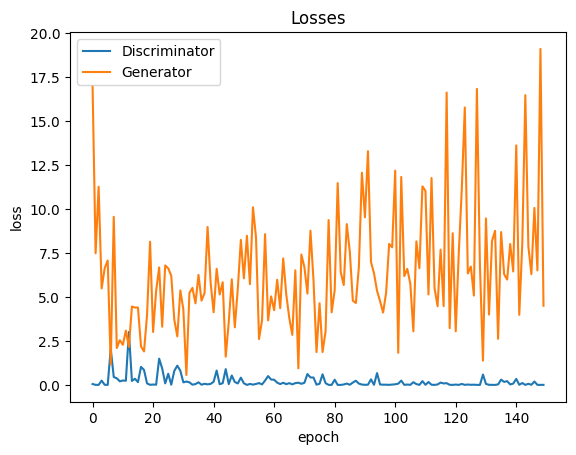

In [34]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

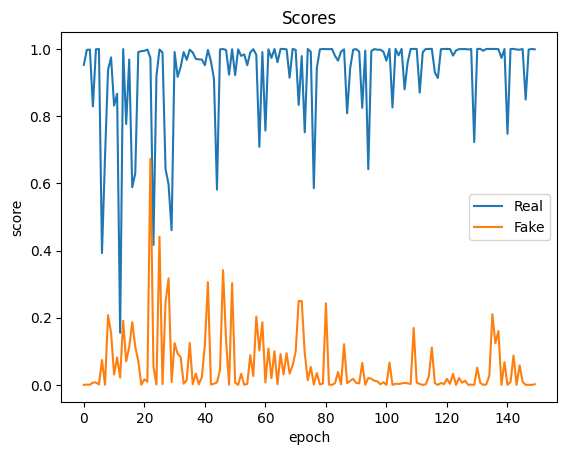

In [35]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');